# Imports

In [15]:
import pandas as pd
import random
import numpy as np
import catboost as cb
from catboost import Pool
import xgboost as xgb
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, mean_squared_error, ConfusionMatrixDisplay
from sklearn.model_selection import ParameterSampler, RandomizedSearchCV
from scipy.stats.distributions import expon
from scipy.stats import uniform
from sklearn.metrics import ConfusionMatrixDisplay
import multiprocessing
import os
import glob
import re
import h2o
from tqdm import tqdm
import pickle
from autoxgb import AutoXGB
from autoxgb.cli.predict import PredictAutoXGBCommand
from optuna.samplers import TPESampler
import optuna
from sklearn.metrics import mean_squared_error as mse
from h2o.automl import H2OAutoML
SEED = 42

%matplotlib notebook
# Function to seed everything
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
seed_everything(SEED)

# Functions

In [2]:
def look_at_anti_dist(all_ASR, col_name, col_order=None):
    col_dist = all_ASR.groupby(by='antibiotic_name')[col_name].apply(lambda x: x.value_counts()).reset_index()
    col_dist.columns = ['antibiotic_name', col_name, 'count']
    order = col_dist.groupby(by='antibiotic_name')['count'].apply(sum).sort_values().index
    col_dist = pd.pivot_table(col_dist, values='count', index=['antibiotic_name'],
                    columns=[col_name], aggfunc=np.sum).fillna(0)
    if col_order is not None:
        col_dist = col_dist[col_order]
    ax = col_dist.loc[order].plot.barh(stacked=True, rot=0, figsize=(20,15))
    plt.title('Distribution of ' + col_name+' for each anti-biotics')
    plt.ylabel('antibiotics')
    plt.xlabel('# of measurements')
    plt.legend(loc='lower right')

In [3]:
def print_anti_measure(all_ASR, anti_index):
    anti = all_ASR['antibiotic_name'].value_counts().index[anti_index]
    anti_MIC = all_ASR[all_ASR['antibiotic_name'] == anti]
    anti_MIC['measurement'] = anti_MIC['measurement'].apply(np.log2)
    low = anti_MIC['measurement'].min().round()
    high = anti_MIC['measurement'].max().round()
    hist_range = np.arange(low-0.5, high+1, 1)
    bins_count = pd.DataFrame(anti_MIC.groupby(by='measurement_sign')['measurement'].apply(lambda x: np.histogram(x, bins=hist_range)[0]))
    bins_count = bins_count.merge(pd.DataFrame({'fill': [np.zeros(len(hist_range)-1)]}, index=['=', '<=', '>=', '<', '>']), left_index=True, right_index=True, how='right')
    bins_count['measurement'].fillna(bins_count['fill'], inplace=True)
    pd.DataFrame(bins_count['measurement'].tolist(), index= bins_count.index, columns=hist_range[:-1]+0.5).T.plot.bar(stacked=True)
    plt.title(anti)
    plt.xlabel('log2(mg//L)')
    plt.ylabel('#')


In [59]:
def strat_id(y, antibiotic_sep=True, seed_add=0):
    train_ids = []
    test_ids = []
    if antibiotic_sep:
        for y_val in set(y.values):    
            sub_value_id = list(y[y == y_val].index)
            if len(sub_value_id) > 1:
                train_id, test_id = train_test_split(sub_value_id, test_size=0.2, random_state=42+seed_add)
                train_ids = train_ids + train_id
                test_ids = test_ids + test_id
            else:
                train_ids = train_ids + sub_value_id
    else:
        tmp_y = y.reset_index()
        for anti_name in set(tmp_y['antibiotic_name']):
            sub_anti_y = y[y['antibiotic_name'] == anti_name].set_index
            
        
    return train_ids, test_ids

In [65]:
def get_filtered_data(
    data = 'tot_filtered_data.csv', 
    features = 'final_features',
    ASR_data = 'filtered_ASR_data.csv', 
    species_sep = True, 
    antibiotic_sep=True,
    species_filter_index=0, 
    antibiotic_index=0,
    naive=True, 
    task='regression', 
    strip_range_train=False,
    distance_range_train=False,
    range_moved=5,
    reg_stratified=True,
    cv_num = 3,
    filter_antibiotics_size=20,
):
    data = pd.read_csv('../resources/'+'tot_filtered_data.csv')
    with open("../resources/"+ 'final_features', "rb") as fp:
        features = pickle.load(fp)
    ASR_data = pd.read_csv('../resources/'+'filtered_ASR_data.csv')

    species2merge = data[['biosample_id', 'species_fam']]
    filtered_ASR = ASR_data.drop('species_fam', axis=1).merge(species2merge, on='biosample_id')
    filtered_ASR.set_index('biosample_id', inplace=True)
    filtered_ASR = filtered_ASR[filtered_ASR['units']=='mg/L']
    filtered_ASR = filtered_ASR[filtered_ASR['ast_standard']=='CLSI']
    filtered_ASR = filtered_ASR[filtered_ASR['species_fam']!='senterica']
    filtered_ASR = filtered_ASR[filtered_ASR['species_fam']!='spneumoniae']
    data.set_index('biosample_id', inplace=True)
    data.drop(['Unnamed: 0', 'species_fam', 'run_id'], axis=1, inplace=True)

    if species_sep:
        species = filtered_ASR['species_fam'].value_counts().reset_index()['index'].iloc[species_filter_index]
        filtered_ASR = filtered_ASR[filtered_ASR['species_fam'] == species]
    else:
        species = None

    if antibiotic_sep:
        anti_list = filtered_ASR['antibiotic_name'].value_counts().index.values
        label = anti_list[antibiotic_index]
        filtered_ASR = filtered_ASR[filtered_ASR['antibiotic_name'] == label]
    else:
        label = 'measurement'
        anti_list = filtered_ASR['antibiotic_name'].value_counts()[filtered_ASR['antibiotic_name'].value_counts() > filter_antibiotics_size].index.values
        filtered_ASR = filtered_ASR[filtered_ASR['antibiotic_name'].apply(lambda x: x in anti_list)]
        filtered_ASR = filtered_ASR.reset_index().set_index(['biosample_id', 'antibiotic_name']).drop('Unnamed: 0', axis=1)
    
    range_ASR = filtered_ASR[filtered_ASR['measurement_sign']!='=']        
    exact_ASR = filtered_ASR[filtered_ASR['measurement_sign']=='=']
    
    if not antibiotic_sep:
        data = data.melt(
            id_vars=features,
            ignore_index=False,
            value_vars=anti_list,
            var_name='antibiotic_name',
            value_name='measurement',
        ).dropna(axis=0, subset=['measurement'])
        data = data.reset_index().set_index(['biosample_id', 'antibiotic_name'])
    
    range_data_values = data.loc[range_ASR.index][label]
    range_labels = pd.DataFrame({
        'values':[],
        'direction': [],
    })
    range_labels['values'] = range_data_values.apply(lambda x: float(x.split(' ')[1]))
    range_labels['direction'] = range_data_values.apply(lambda x: x.split(' ')[0].replace('=', ''))
    
    exact_y = data.loc[exact_ASR.index][label]
    if task == 'regression':
        exact_y = exact_y.apply(lambda x: float(x.split(' ')[1]))
    elif task == 'classification':
        exact_y = exact_y.apply(lambda x: str(x.split(' ')[1]))
    exact_y.name = label
        
    exact_X = data.loc[exact_ASR.index][features]
    exact_X.dropna(axis=1, how='all', inplace=True)
    exact_X.fillna(0, inplace=True) 
    exact = exact_X.merge(exact_y, left_index=True, right_index=True)
    
    if not naive:
        range_y = range_data_values
        if task == 'regression':
            if strip_range_train:
                range_y = range_labels['values']
            elif distance_range_train:
                signs = range_labels['direction']
                range_y = range_labels['values']
                range_y = range_y.mask(signs == '>', range_y + range_moved)
                range_y = range_y.mask(signs == '<', range_y - range_moved)
            else:
                print('regression not in the naive approach is not implemented yet.') 
        range_y.name = label
    else:
        range_y = pd.DataFrame({})
    
    train_features = exact_X.columns.values
    range_X = data.loc[range_ASR.index][train_features]
    range_X.fillna(0, inplace=True)
    range_X = range_X.reset_index().set_index('biosample_id')
    range_data = range_X.merge(range_y, left_index=True, right_index=True)

    range_train_ids = []
    range_test_ids = []
    if reg_stratified:
        exact_train_ids, exact_test_ids = strat_id(exact_y, antibiotic_sep)
        if not naive:
            range_train_ids, range_test_ids = strat_id(range_y, antibiotic_sep)
    else:
        if antibiotic_sep:
            exact_train_ids, exact_test_ids = train_test_split(list(exact_y.index), test_size=0.2, random_state=42)
            if not naive:
                range_train_ids, range_test_ids = train_test_split(list(range_y.index), test_size=0.2, random_state=42)
        else:
            exact_train_ids, exact_test_ids = train_test_split(list(set(exact_y.index.get_level_values(0).values)), test_size=0.2, random_state=42)
            if not naive:
                range_train_ids, range_test_ids = train_test_split(list(set(range_y.index.get_level_values(0).values)), test_size=0.2, random_state=42)
    exact_train = exact.loc[exact_train_ids,]
    range_train = range_data.loc[range_train_ids,]
    train = pd.concat([exact_train, range_train])
    test = pd.concat([exact.loc[exact_test_ids,], range_data.loc[range_test_ids,]])
    if not antibiotic_sep:
        train = train.drop('antibiotic_name', axis=1).reset_index().set_index('biosample_id')
        test = test.drop('antibiotic_name', axis=1).reset_index().set_index('biosample_id')
    
    # generate cv from train that is stratified
    cv = []
    if reg_stratified:    
        train_ref = train.reset_index()
        for i in np.arange(cv_num):
            exact_train_ids, exact_test_ids = strat_id(exact_train[label], antibiotic_sep, seed_add=i)
            range_train_ids, range_test_ids = [], []
            if not naive:
                range_train_ids, range_test_ids = strat_id(range_train[label], antibiotic_sep, seed_add=i)
            cv_train_ids = exact_train_ids+range_train_ids
            cv_test_ids = exact_test_ids+range_test_ids
            cv.append((list(train_ref[train_ref['biosample_id'].isin(cv_train_ids)].index),
                      list(train_ref[train_ref['biosample_id'].isin(cv_test_ids)].index)))
    if not antibiotic_sep:
        train_features = list(train_features) + ['antibiotic_name']
    return train, test, range_X, range_labels, train_features, label, species, cv

# Building models

## CatBoost

In [109]:
def objective(trial):
    X_train, y_train, X_test, y_test, X_range, y_range, features, label, species = get_filtered_data_multi_anti(
        data = 'tot_filtered_data.csv', 
        features = 'final_features',
        ASR_data = 'filtered_ASR_data.csv', 
        species_sep = True, 
        species_filter_index=species_filter_index, 
        naive=naive, 
        strip_range_train=strip_range_train,
        test_range=test_range, 
        task='regression',
    )
    # X_train = np.array(X_train)
    y_train = np.array(y_train['measurement'])
    # X_test = np.array(X_test)
    y_test = np.array(y_test['measurement'])
    
    categorical_features_indices = np.where(X_train.dtypes != np.float)[0]
    train_pool = Pool(X_train, y_train, cat_features=categorical_features_indices)
    test_pool = Pool(X_test, y_test, cat_features=categorical_features_indices)
    # Parameters
    params = set_param(trial)
    # Learning
    
    model = cb.CatBoostRegressor(
        loss_function="RMSE",
        eval_metric="RMSE",
        task_type="GPU",
        l2_leaf_reg=50,
        random_seed=SEED,
        border_count=64,
        cat_features = categorical_features_indices,
        **params
    )
    model.set_feature_names(features)
    model.fit(
        train_pool,
        eval_set=test_pool,
        use_best_model=True,
        verbose=500,
        plot=False,
    )
    # Predict
    preds = model.predict(test_pool)
    y_pred = np.rint(preds)
    
    # Evaluation
    rmse_test = mse(y_test, preds, squared=False)
    rmse_r_test = mse(y_test, y_pred, squared=False)
    print('rmse Score of CatBoost =', rmse_test)
    print('rounded rmse Score of CatBoost =', rmse_r_test)
    return rmse_r_test

In [110]:
def evaluate_best(trial, exp_name):
    # Use same code objective to reproduce the best model
    X_train, y_train, X_test, y_test, X_range, y_range, features, label, species = get_filtered_data_multi_anti(
        data = 'tot_filtered_data.csv', 
        features = 'final_features',
        ASR_data = 'filtered_ASR_data.csv', 
        species_sep = True, 
        species_filter_index=species_filter_index, 
        naive=naive, 
        strip_range_train=strip_range_train,
        test_range=test_range, 
        task='regression',
    )
    
    categorical_features_indices = np.where(X_train.dtypes != np.float)[0]
    train_pool = Pool(X_train, np.array(y_train['measurement']), cat_features=categorical_features_indices)
    test_pool = Pool(X_test, np.array(y_test['measurement']), cat_features=categorical_features_indices)
    range_pool = Pool(X_range, np.array(y_range['values']), cat_features=categorical_features_indices)
    
    # Parameters
    params = set_param(trial)
    # Learning
    model = cb.CatBoostRegressor(
        loss_function="RMSE",
        eval_metric="RMSE",
        task_type="GPU",
        l2_leaf_reg=50,
        random_seed=SEED,
        border_count=64,
        cat_features = categorical_features_indices,
        **params
    )

    # calculate more evaluation metrics
    model.set_feature_names(features)
    model.fit(
        train_pool,
        eval_set=test_pool,
        use_best_model=True,
        verbose=500,
        plot=False,
    )
    pickle.dump(params, open('../experiments/{}/CatBoost_Hyperparameter.pickle'.format(exp_name), 'wb'))
    
    # Predict
    train_preds = model.predict(train_pool)
    pickle.dump(train_preds, open('../experiments/{}/train_pred.pickle'.format(exp_name), 'wb'))
    pickle.dump(y_train, open('../experiments/{}/train_y.pickle'.format(exp_name), 'wb'))
    
    preds = model.predict(test_pool)
    pickle.dump(preds, open('../experiments/{}/test_pred.pickle'.format(exp_name), 'wb'))
    pickle.dump(y_test, open('../experiments/{}/test_y.pickle'.format(exp_name), 'wb'))
    y_pred = np.rint(preds)

    if test_range:
        range_pred = model.predict(range_pool)
        pickle.dump(range_pred, open('../experiments/{}/range_pred.pickle'.format(exp_name), 'wb'))
        pickle.dump(y_range, open('../experiments/{}/range_y.pickle'.format(exp_name), 'wb'))
        
    rmse_test = mse(np.array(y_test['measurement']), preds, squared=False)
    rmse_r_test = mse(np.array(y_test['measurement']), y_pred, squared=False)
        
    return rmse_test, rmse_r_test

In [111]:
species_filter_index_list = [0]
naive = True
strip_range_train=False
train_time = 60
test_range=True
distance_range_train=False
range_moved=5
exp_describtion = 'train_no_range'
n_trials = 1000
def set_param(trial):
    return {
        'iterations' : trial.suggest_int('iterations', 1000, 10000),                                              
        'depth' : trial.suggest_int('depth', 4, 10),                                                    
        'random_strength' :trial.suggest_int('random_strength', 0, 100),                       
        'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),
        'learning_rate' :trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
        'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter'])
    }

In [ ]:
studies = []
for species_filter_index in species_filter_index_list:
    X_train, y_train, X_test, y_test, X_range, y_range, features, label, species = get_filtered_data_multi_anti(
        data = 'tot_filtered_data.csv', 
        features = 'final_features',
        ASR_data = 'filtered_ASR_data.csv', 
        species_sep = True, 
        species_filter_index=species_filter_index, 
        naive=naive, 
        strip_range_train=strip_range_train,
        test_range=test_range, 
        task='regression',
    )
    exp_name = '{}_{}_for_{}_trials'.format(species, exp_describtion, n_trials)
    os.makedirs('../experiments/{}'.format(exp_name), exist_ok=True)
    study = optuna.create_study(direction = "minimize", sampler = TPESampler(seed=int(SEED)))
    study.optimize(objective, n_trials = n_trials, n_jobs = 1)#multiprocessing.cpu_count())
    evaluate_best(study.best_trial, exp_name)
    print('CatBoost Hyperparameter:', study.best_trial.params)
    pickle.dump(study, open('../experiments/{}/hype_search.pickle'.format(exp_name), 'wb'))
    studies.append(study)

/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
  if sys.path[0] == '':
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  if sys.path[0] == '':
[I 2022-03-09 00:32:05,037] A new study created in memory with name: no-name-0aaf3d71-9128-42e7-ac12-3cc6b81d6526
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,6

0:	learn: 1.5286898	test: 1.5236754	best: 1.5236754 (0)	total: 57.9ms	remaining: 4m 13s
500:	learn: 1.2182176	test: 1.2140228	best: 1.2140228 (500)	total: 20s	remaining: 2m 34s
1000:	learn: 1.0808475	test: 1.0832146	best: 1.0832146 (1000)	total: 40.4s	remaining: 2m 16s
1500:	learn: 1.0123617	test: 1.0230711	best: 1.0230711 (1500)	total: 1m 1s	remaining: 1m 57s
2000:	learn: 0.9738477	test: 0.9929342	best: 0.9929342 (2000)	total: 1m 22s	remaining: 1m 37s
2500:	learn: 0.9472742	test: 0.9737054	best: 0.9737054 (2500)	total: 1m 43s	remaining: 1m 17s
3000:	learn: 0.9272138	test: 0.9605585	best: 0.9605585 (3000)	total: 2m 4s	remaining: 56.9s
3500:	learn: 0.9108327	test: 0.9499028	best: 0.9499028 (3500)	total: 2m 26s	remaining: 36.3s
4000:	learn: 0.8973094	test: 0.9418328	best: 0.9418328 (4000)	total: 2m 47s	remaining: 15.5s
4370:	learn: 0.8887973	test: 0.9370625	best: 0.9370600 (4369)	total: 3m 3s	remaining: 0us
bestTest = 0.9370599755
bestIteration = 4369
Shrink model to first 4370 iteration

[I 2022-03-09 00:35:12,008] Trial 0 finished with value: 0.9685314126785629 and parameters: {'iterations': 4371, 'depth': 10, 'random_strength': 73, 'bagging_temperature': 2.481040974867813, 'learning_rate': 0.0020513382630874496, 'od_type': 'IncToDec'}. Best is trial 0 with value: 0.9685314126785629.


rmse Score of CatBoost = 0.9370594480367359
rounded rmse Score of CatBoost = 0.9685314126785629


/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, 

0:	learn: 1.4851971	test: 1.4797844	best: 1.4797844 (0)	total: 18.7ms	remaining: 2m 44s
500:	learn: 0.6588876	test: 0.8058544	best: 0.8057466 (499)	total: 8.23s	remaining: 2m 16s
1000:	learn: 0.5791395	test: 0.7928157	best: 0.7900329 (944)	total: 16.4s	remaining: 2m 7s
1500:	learn: 0.5377283	test: 0.7978651	best: 0.7900329 (944)	total: 24.4s	remaining: 1m 58s
2000:	learn: 0.5016826	test: 0.8056360	best: 0.7900329 (944)	total: 32.9s	remaining: 1m 51s
2500:	learn: 0.4923228	test: 0.8063474	best: 0.7900329 (944)	total: 41.2s	remaining: 1m 43s
3000:	learn: 0.4851724	test: 0.8093764	best: 0.7900329 (944)	total: 49.8s	remaining: 1m 36s
3500:	learn: 0.4778265	test: 0.8119624	best: 0.7900329 (944)	total: 58.3s	remaining: 1m 28s
4000:	learn: 0.4642674	test: 0.8164266	best: 0.7900329 (944)	total: 1m 7s	remaining: 1m 20s
4500:	learn: 0.4552038	test: 0.8217982	best: 0.7900329 (944)	total: 1m 16s	remaining: 1m 12s
5000:	learn: 0.4472652	test: 0.8268017	best: 0.7900329 (944)	total: 1m 25s	remaining:

[I 2022-03-09 00:37:49,213] Trial 1 finished with value: 0.8440316229448832 and parameters: {'iterations': 8796, 'depth': 8, 'random_strength': 71, 'bagging_temperature': 0.012087541473056965, 'learning_rate': 0.08706020878304858, 'od_type': 'IncToDec'}. Best is trial 1 with value: 0.8440316229448832.


8795:	learn: 0.4133410	test: 0.8377191	best: 0.7900329 (944)	total: 2m 33s	remaining: 0us
bestTest = 0.7900329467
bestIteration = 944
Shrink model to first 945 iterations.
rmse Score of CatBoost = 0.790033053039722
rounded rmse Score of CatBoost = 0.8440316229448832


/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, 

0:	learn: 1.5261671	test: 1.5207345	best: 1.5207345 (0)	total: 7.91ms	remaining: 20.8s
500:	learn: 1.0279103	test: 1.0265326	best: 1.0265326 (500)	total: 3.58s	remaining: 15.3s
1000:	learn: 0.9579691	test: 0.9821343	best: 0.9821343 (1000)	total: 7.27s	remaining: 11.9s
1500:	learn: 0.9162209	test: 0.9583852	best: 0.9583852 (1500)	total: 11s	remaining: 8.29s
2000:	learn: 0.8830761	test: 0.9367448	best: 0.9367448 (2000)	total: 14.6s	remaining: 4.63s
2500:	learn: 0.8587536	test: 0.9177445	best: 0.9177445 (2500)	total: 18.2s	remaining: 982ms


[I 2022-03-09 00:38:11,440] Trial 2 finished with value: 0.9407208683835974 and parameters: {'iterations': 2636, 'depth': 5, 'random_strength': 30, 'bagging_temperature': 1.256104370001356, 'learning_rate': 0.007309539835912915, 'od_type': 'Iter'}. Best is trial 1 with value: 0.8440316229448832.


2635:	learn: 0.8529911	test: 0.9137961	best: 0.9137892 (2633)	total: 19.1s	remaining: 0us
bestTest = 0.9137891974
bestIteration = 2633
Shrink model to first 2634 iterations.
rmse Score of CatBoost = 0.913788843318865
rounded rmse Score of CatBoost = 0.9407208683835974


/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, 

0:	learn: 1.5117765	test: 1.5058161	best: 1.5058161 (0)	total: 10.8ms	remaining: 24.3s
500:	learn: 0.8198457	test: 0.8870444	best: 0.8870444 (500)	total: 4.52s	remaining: 15.8s
1000:	learn: 0.7562934	test: 0.8493310	best: 0.8493310 (1000)	total: 8.97s	remaining: 11.2s


[I 2022-03-09 00:38:27,866] Trial 3 finished with value: 0.855745806274125 and parameters: {'iterations': 2255, 'depth': 6, 'random_strength': 37, 'bagging_temperature': 0.6672367170464207, 'learning_rate': 0.037183641805732096, 'od_type': 'Iter'}. Best is trial 1 with value: 0.8440316229448832.


1500:	learn: 0.7135237	test: 0.8295541	best: 0.8293331 (1482)	total: 13.4s	remaining: 6.75s
bestTest = 0.8293330817
bestIteration = 1482
Shrink model to first 1483 iterations.
rmse Score of CatBoost = 0.829332959593949
rounded rmse Score of CatBoost = 0.855745806274125


/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, 

0:	learn: 1.5290275	test: 1.5240461	best: 1.5240461 (0)	total: 6.63ms	remaining: 42s
500:	learn: 1.3268852	test: 1.3141251	best: 1.3141251 (500)	total: 3.05s	remaining: 35.5s
1000:	learn: 1.2143761	test: 1.1979973	best: 1.1979973 (1000)	total: 5.97s	remaining: 31.8s
1500:	learn: 1.1446591	test: 1.1273628	best: 1.1273628 (1500)	total: 8.93s	remaining: 28.7s
2000:	learn: 1.0989534	test: 1.0841746	best: 1.0841746 (2000)	total: 11.9s	remaining: 25.7s
2500:	learn: 1.0667687	test: 1.0547309	best: 1.0547309 (2500)	total: 14.9s	remaining: 22.8s
3000:	learn: 1.0426657	test: 1.0344524	best: 1.0344524 (3000)	total: 17.9s	remaining: 19.8s
3500:	learn: 1.0250559	test: 1.0210009	best: 1.0210009 (3500)	total: 21.3s	remaining: 17.2s
4000:	learn: 1.0106799	test: 1.0105707	best: 1.0105707 (4000)	total: 24.7s	remaining: 14.4s
4500:	learn: 0.9989110	test: 1.0030286	best: 1.0030286 (4500)	total: 28.1s	remaining: 11.4s
5000:	learn: 0.9887403	test: 0.9968583	best: 0.9968583 (5000)	total: 31.6s	remaining: 8.4

[I 2022-03-09 00:39:11,755] Trial 4 finished with value: 1.0066152871296887 and parameters: {'iterations': 6332, 'depth': 4, 'random_strength': 61, 'bagging_temperature': 0.04809461967501574, 'learning_rate': 0.0013492834268013251, 'od_type': 'Iter'}. Best is trial 1 with value: 0.8440316229448832.


6331:	learn: 0.9663556	test: 0.9849248	best: 0.9849248 (6331)	total: 40.5s	remaining: 0us
bestTest = 0.984924823
bestIteration = 6331
rmse Score of CatBoost = 0.9849244533431554
rounded rmse Score of CatBoost = 1.0066152871296887


/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, 

0:	learn: 1.5265642	test: 1.5216191	best: 1.5216191 (0)	total: 10.7ms	remaining: 1m 28s
500:	learn: 1.1176678	test: 1.1265060	best: 1.1265060 (500)	total: 4.53s	remaining: 1m 10s
1000:	learn: 1.0354516	test: 1.0614995	best: 1.0614934 (999)	total: 9.01s	remaining: 1m 5s
1500:	learn: 0.9986706	test: 1.0338773	best: 1.0338450 (1495)	total: 13.5s	remaining: 1m


[I 2022-03-09 00:39:31,207] Trial 5 finished with value: 1.0767042469491008 and parameters: {'iterations': 8276, 'depth': 6, 'random_strength': 9, 'bagging_temperature': 5.456725485601478, 'learning_rate': 0.007591104805282696, 'od_type': 'Iter'}. Best is trial 1 with value: 0.8440316229448832.


bestTest = 1.02417795
bestIteration = 1785
Shrink model to first 1786 iterations.
rmse Score of CatBoost = 1.0241781082227588
rounded rmse Score of CatBoost = 1.0767042469491008


/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, 

0:	learn: 1.5277275	test: 1.5227463	best: 1.5227463 (0)	total: 43.4ms	remaining: 56.7s
500:	learn: 1.1287479	test: 1.1280255	best: 1.1280255 (500)	total: 19.9s	remaining: 32.1s
1000:	learn: 1.0168637	test: 1.0289884	best: 1.0289884 (1000)	total: 40.3s	remaining: 12.4s


[I 2022-03-09 00:40:27,706] Trial 6 finished with value: 1.0736176541286182 and parameters: {'iterations': 1309, 'depth': 10, 'random_strength': 26, 'bagging_temperature': 4.467752817973908, 'learning_rate': 0.004201672054372531, 'od_type': 'Iter'}. Best is trial 1 with value: 0.8440316229448832.


1308:	learn: 0.9852507	test: 1.0050332	best: 1.0050332 (1308)	total: 53.1s	remaining: 0us
bestTest = 1.005033165
bestIteration = 1308
rmse Score of CatBoost = 1.005033049592137
rounded rmse Score of CatBoost = 1.0736176541286182


/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, 

0:	learn: 1.5296012	test: 1.5246879	best: 1.5246879 (0)	total: 4.87ms	remaining: 13s


[I 2022-03-09 00:40:32,895] Trial 7 finished with value: 1.1597985787897966 and parameters: {'iterations': 2663, 'depth': 10, 'random_strength': 78, 'bagging_temperature': 57.27904470799624, 'learning_rate': 0.06161049539380966, 'od_type': 'Iter'}. Best is trial 1 with value: 0.8440316229448832.


500:	learn: 1.1638200	test: 1.1104692	best: 1.1104692 (500)	total: 2.15s	remaining: 9.3s
bestTest = 1.110436989
bestIteration = 502
Shrink model to first 503 iterations.
rmse Score of CatBoost = 1.110436988290255
rounded rmse Score of CatBoost = 1.1597985787897966


/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, 

0:	learn: 1.5264235	test: 1.5213653	best: 1.5213653 (0)	total: 7.41ms	remaining: 13.3s
500:	learn: 1.0326480	test: 1.0412965	best: 1.0412965 (500)	total: 3.54s	remaining: 9.14s
1000:	learn: 0.9498235	test: 0.9920574	best: 0.9920574 (1000)	total: 7.16s	remaining: 5.68s
1500:	learn: 0.9108494	test: 0.9670813	best: 0.9670813 (1500)	total: 10.7s	remaining: 2.1s


[I 2022-03-09 00:40:48,758] Trial 8 finished with value: 0.9899941896674047 and parameters: {'iterations': 1796, 'depth': 5, 'random_strength': 4, 'bagging_temperature': 0.20013420622879985, 'learning_rate': 0.0059890036722543005, 'od_type': 'Iter'}. Best is trial 1 with value: 0.8440316229448832.


1795:	learn: 0.8906880	test: 0.9480519	best: 0.9480519 (1795)	total: 12.8s	remaining: 0us
bestTest = 0.9480519478
bestIteration = 1795
rmse Score of CatBoost = 0.9480516749301022
rounded rmse Score of CatBoost = 0.9899941896674047


/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, 

0:	learn: 1.5116266	test: 1.5049138	best: 1.5049138 (0)	total: 8.12ms	remaining: 34.2s
500:	learn: 0.8399355	test: 0.8935238	best: 0.8935238 (500)	total: 3.54s	remaining: 26.2s


[I 2022-03-09 00:40:57,591] Trial 9 finished with value: 0.9181069403845615 and parameters: {'iterations': 4211, 'depth': 5, 'random_strength': 54, 'bagging_temperature': 0.0366181922039243, 'learning_rate': 0.040215545266902894, 'od_type': 'Iter'}. Best is trial 1 with value: 0.8440316229448832.


bestTest = 0.8701875197
bestIteration = 800
Shrink model to first 801 iterations.
rmse Score of CatBoost = 0.8701875479474903
rounded rmse Score of CatBoost = 0.9181069403845615


/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, 

0:	learn: 1.5191672	test: 1.5141385	best: 1.5141385 (0)	total: 19ms	remaining: 3m 6s
500:	learn: 0.8775032	test: 0.9266952	best: 0.9266805 (498)	total: 8.24s	remaining: 2m 33s
1000:	learn: 0.7829164	test: 0.8741177	best: 0.8740115 (998)	total: 16.3s	remaining: 2m 23s
1500:	learn: 0.7148510	test: 0.8327063	best: 0.8327063 (1500)	total: 24.5s	remaining: 2m 15s
2000:	learn: 0.6900256	test: 0.8261605	best: 0.8261605 (2000)	total: 33s	remaining: 2m 8s
2500:	learn: 0.6646265	test: 0.8152850	best: 0.8152785 (2499)	total: 41.4s	remaining: 2m
3000:	learn: 0.6395376	test: 0.8045861	best: 0.8045861 (3000)	total: 49.9s	remaining: 1m 53s
3500:	learn: 0.6189475	test: 0.7993014	best: 0.7993014 (3500)	total: 58.4s	remaining: 1m 45s
4000:	learn: 0.6020430	test: 0.7943649	best: 0.7943437 (3998)	total: 1m 7s	remaining: 1m 37s
4500:	learn: 0.5879104	test: 0.7967326	best: 0.7943437 (3998)	total: 1m 16s	remaining: 1m 29s
5000:	learn: 0.5775659	test: 0.7988802	best: 0.7943437 (3998)	total: 1m 25s	remaining: 

[I 2022-03-09 00:43:54,623] Trial 10 finished with value: 0.8531565543290928 and parameters: {'iterations': 9810, 'depth': 8, 'random_strength': 97, 'bagging_temperature': 0.011799062523159294, 'learning_rate': 0.02012487082975094, 'od_type': 'IncToDec'}. Best is trial 1 with value: 0.8440316229448832.


9809:	learn: 0.5087017	test: 0.8131852	best: 0.7943437 (3998)	total: 2m 53s	remaining: 0us
bestTest = 0.7943436601
bestIteration = 3998
Shrink model to first 3999 iterations.
rmse Score of CatBoost = 0.794344062288295
rounded rmse Score of CatBoost = 0.8531565543290928


/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, 

0:	learn: 1.5183328	test: 1.5132973	best: 1.5132973 (0)	total: 19.7ms	remaining: 3m 14s
500:	learn: 0.8666659	test: 0.9200987	best: 0.9200987 (500)	total: 8.57s	remaining: 2m 40s
1000:	learn: 0.7712436	test: 0.8687093	best: 0.8687093 (1000)	total: 16.9s	remaining: 2m 30s
1500:	learn: 0.7037503	test: 0.8356174	best: 0.8355926 (1487)	total: 25.4s	remaining: 2m 21s
2000:	learn: 0.6648943	test: 0.8223045	best: 0.8222351 (1994)	total: 34s	remaining: 2m 14s
2500:	learn: 0.6358020	test: 0.8079321	best: 0.8079189 (2498)	total: 42.5s	remaining: 2m 5s
3000:	learn: 0.6176989	test: 0.7973798	best: 0.7973798 (3000)	total: 50.7s	remaining: 1m 56s
3500:	learn: 0.5970818	test: 0.7955228	best: 0.7936505 (3287)	total: 58.9s	remaining: 1m 47s
4000:	learn: 0.5836938	test: 0.7974206	best: 0.7936505 (3287)	total: 1m 7s	remaining: 1m 39s
4500:	learn: 0.5703728	test: 0.8003523	best: 0.7936505 (3287)	total: 1m 16s	remaining: 1m 31s
5000:	learn: 0.5597881	test: 0.8002724	best: 0.7936505 (3287)	total: 1m 24s	rem

[I 2022-03-09 00:46:46,018] Trial 11 finished with value: 0.8466487815452376 and parameters: {'iterations': 9888, 'depth': 8, 'random_strength': 96, 'bagging_temperature': 0.010353204153309653, 'learning_rate': 0.021740731802377535, 'od_type': 'IncToDec'}. Best is trial 1 with value: 0.8440316229448832.


9887:	learn: 0.5076544	test: 0.8103278	best: 0.7936505 (3287)	total: 2m 47s	remaining: 0us
bestTest = 0.7936505478
bestIteration = 3287
Shrink model to first 3288 iterations.
rmse Score of CatBoost = 0.7936503962086157
rounded rmse Score of CatBoost = 0.8466487815452376


/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, 

0:	learn: 1.4825676	test: 1.4771161	best: 1.4771161 (0)	total: 18.9ms	remaining: 3m 4s
500:	learn: 0.6696429	test: 0.8252904	best: 0.8252904 (500)	total: 8.13s	remaining: 2m 30s
1000:	learn: 0.5787299	test: 0.8107017	best: 0.8097007 (900)	total: 16.3s	remaining: 2m 22s
1500:	learn: 0.5427653	test: 0.8160731	best: 0.8086574 (1112)	total: 24.2s	remaining: 2m 13s
2000:	learn: 0.5172119	test: 0.8189819	best: 0.8086574 (1112)	total: 32.3s	remaining: 2m 5s
2500:	learn: 0.5003047	test: 0.8282706	best: 0.8086574 (1112)	total: 40.4s	remaining: 1m 57s
3000:	learn: 0.4870337	test: 0.8321371	best: 0.8086574 (1112)	total: 48.6s	remaining: 1m 49s
3500:	learn: 0.4716729	test: 0.8311802	best: 0.8086574 (1112)	total: 57s	remaining: 1m 42s
4000:	learn: 0.4602936	test: 0.8337440	best: 0.8086574 (1112)	total: 1m 5s	remaining: 1m 34s
4500:	learn: 0.4511652	test: 0.8367728	best: 0.8086574 (1112)	total: 1m 15s	remaining: 1m 27s
5000:	learn: 0.4454424	test: 0.8395154	best: 0.8086574 (1112)	total: 1m 24s	remai

[I 2022-03-09 00:49:39,831] Trial 12 finished with value: 0.8479543317140177 and parameters: {'iterations': 9768, 'depth': 8, 'random_strength': 99, 'bagging_temperature': 0.011028928813293946, 'learning_rate': 0.09234573550574587, 'od_type': 'IncToDec'}. Best is trial 1 with value: 0.8440316229448832.


9767:	learn: 0.4056495	test: 0.8438236	best: 0.8086574 (1112)	total: 2m 50s	remaining: 0us
bestTest = 0.8086574155
bestIteration = 1112
Shrink model to first 1113 iterations.
rmse Score of CatBoost = 0.8086573431772839
rounded rmse Score of CatBoost = 0.8479543317140177


/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, 

0:	learn: 1.5204475	test: 1.5154293	best: 1.5154293 (0)	total: 18.4ms	remaining: 2m 23s
500:	learn: 0.8918051	test: 0.9389274	best: 0.9389237 (499)	total: 8.4s	remaining: 2m 1s
1000:	learn: 0.7997777	test: 0.8793281	best: 0.8793281 (1000)	total: 16.7s	remaining: 1m 52s
1500:	learn: 0.7439906	test: 0.8496318	best: 0.8496318 (1500)	total: 24.9s	remaining: 1m 44s
2000:	learn: 0.6962803	test: 0.8291664	best: 0.8291664 (2000)	total: 33.1s	remaining: 1m 35s
2500:	learn: 0.6659719	test: 0.8186970	best: 0.8186970 (2500)	total: 41.3s	remaining: 1m 27s
3000:	learn: 0.6431534	test: 0.8108246	best: 0.8107761 (2996)	total: 49.6s	remaining: 1m 18s
3500:	learn: 0.6240474	test: 0.8045587	best: 0.8045457 (3499)	total: 57.8s	remaining: 1m 10s
4000:	learn: 0.6083110	test: 0.8008130	best: 0.8008049 (3999)	total: 1m 6s	remaining: 1m 2s
4500:	learn: 0.5939331	test: 0.7999976	best: 0.7999173 (4475)	total: 1m 14s	remaining: 54.4s
5000:	learn: 0.5804155	test: 0.8006721	best: 0.7997366 (4574)	total: 1m 23s	rema

[I 2022-03-09 00:51:53,977] Trial 13 finished with value: 0.8621849174384849 and parameters: {'iterations': 7775, 'depth': 8, 'random_strength': 81, 'bagging_temperature': 0.09188227716652778, 'learning_rate': 0.017648024594344395, 'od_type': 'IncToDec'}. Best is trial 1 with value: 0.8440316229448832.


rmse Score of CatBoost = 0.7997369654794068
rounded rmse Score of CatBoost = 0.8621849174384849


/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, 

0:	learn: 1.5193903	test: 1.5143213	best: 1.5143213 (0)	total: 31.8ms	remaining: 4m 13s
500:	learn: 0.8640394	test: 0.9206340	best: 0.9206203 (499)	total: 12.5s	remaining: 3m 6s
1000:	learn: 0.7689861	test: 0.8594108	best: 0.8594027 (999)	total: 25.4s	remaining: 2m 57s
1500:	learn: 0.7098400	test: 0.8298644	best: 0.8298644 (1500)	total: 38.5s	remaining: 2m 46s
2000:	learn: 0.6708222	test: 0.8144665	best: 0.8144665 (2000)	total: 51.6s	remaining: 2m 34s
2500:	learn: 0.6367679	test: 0.8045612	best: 0.8045542 (2499)	total: 1m 5s	remaining: 2m 23s
3000:	learn: 0.6140338	test: 0.7999805	best: 0.7999087 (2994)	total: 1m 19s	remaining: 2m 11s
3500:	learn: 0.5961169	test: 0.7985430	best: 0.7983849 (3418)	total: 1m 33s	remaining: 1m 59s
4000:	learn: 0.5799856	test: 0.7977143	best: 0.7976525 (3978)	total: 1m 47s	remaining: 1m 47s
4500:	learn: 0.5671196	test: 0.7979502	best: 0.7974046 (4233)	total: 2m 1s	remaining: 1m 34s
5000:	learn: 0.5563201	test: 0.7979768	best: 0.7974046 (4233)	total: 2m 15s	

[I 2022-03-09 00:55:36,952] Trial 14 finished with value: 0.8440316229448832 and parameters: {'iterations': 7982, 'depth': 9, 'random_strength': 90, 'bagging_temperature': 0.23506997063237167, 'learning_rate': 0.020046179107204475, 'od_type': 'IncToDec'}. Best is trial 1 with value: 0.8440316229448832.


rmse Score of CatBoost = 0.7974046466821336
rounded rmse Score of CatBoost = 0.8440316229448832


/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, 

0:	learn: 1.4817008	test: 1.4760421	best: 1.4760421 (0)	total: 27.5ms	remaining: 3m 28s
500:	learn: 0.6503509	test: 0.8109906	best: 0.8109906 (500)	total: 12.8s	remaining: 3m
1000:	learn: 0.5731127	test: 0.8060087	best: 0.8041076 (689)	total: 26s	remaining: 2m 51s
1500:	learn: 0.5376539	test: 0.8123377	best: 0.8041076 (689)	total: 39.2s	remaining: 2m 38s
2000:	learn: 0.5153125	test: 0.8156293	best: 0.8041076 (689)	total: 52.4s	remaining: 2m 25s
2500:	learn: 0.4968810	test: 0.8181803	best: 0.8041076 (689)	total: 1m 5s	remaining: 2m 13s
3000:	learn: 0.4844389	test: 0.8199537	best: 0.8041076 (689)	total: 1m 19s	remaining: 2m 1s
3500:	learn: 0.4734271	test: 0.8223890	best: 0.8041076 (689)	total: 1m 33s	remaining: 1m 48s
4000:	learn: 0.4638687	test: 0.8263077	best: 0.8041076 (689)	total: 1m 46s	remaining: 1m 35s
4500:	learn: 0.4540827	test: 0.8280969	best: 0.8041076 (689)	total: 2m	remaining: 1m 22s
5000:	learn: 0.4469359	test: 0.8304905	best: 0.8041076 (689)	total: 2m 14s	remaining: 1m 9s


[I 2022-03-09 00:59:05,549] Trial 15 finished with value: 0.8466487815452376 and parameters: {'iterations': 7578, 'depth': 9, 'random_strength': 67, 'bagging_temperature': 0.27285244971606315, 'learning_rate': 0.09573802256314297, 'od_type': 'IncToDec'}. Best is trial 1 with value: 0.8440316229448832.


7577:	learn: 0.4203503	test: 0.8365963	best: 0.8041076 (689)	total: 3m 23s	remaining: 0us
bestTest = 0.804107596
bestIteration = 689
Shrink model to first 690 iterations.
rmse Score of CatBoost = 0.804107626005214
rounded rmse Score of CatBoost = 0.8466487815452376


/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, 

0:	learn: 1.5283658	test: 1.5237989	best: 1.5237989 (0)	total: 26.2ms	remaining: 2m 54s
500:	learn: 1.3599577	test: 1.3770625	best: 1.3770625 (500)	total: 11.3s	remaining: 2m 18s
1000:	learn: 1.3129670	test: 1.3488003	best: 1.3487658 (989)	total: 22.6s	remaining: 2m 8s
1500:	learn: 1.2784007	test: 1.3251467	best: 1.3251407 (1499)	total: 33.8s	remaining: 1m 56s
2000:	learn: 1.2585044	test: 1.3140838	best: 1.3138442 (1972)	total: 44.3s	remaining: 1m 43s
2500:	learn: 1.2427452	test: 1.3070635	best: 1.3065866 (2250)	total: 54.9s	remaining: 1m 31s
3000:	learn: 1.2266948	test: 1.2973413	best: 1.2971624 (2949)	total: 1m 5s	remaining: 1m 19s
3500:	learn: 1.2133880	test: 1.2876773	best: 1.2876630 (3497)	total: 1m 15s	remaining: 1m 8s
4000:	learn: 1.1994971	test: 1.2773085	best: 1.2771723 (3860)	total: 1m 25s	remaining: 56.9s
4500:	learn: 1.1888248	test: 1.2704425	best: 1.2703407 (4485)	total: 1m 35s	remaining: 46s
5000:	learn: 1.1803022	test: 1.2637667	best: 1.2634929 (4832)	total: 1m 45s	remai

[I 2022-03-09 01:01:28,060] Trial 16 finished with value: 1.3270500920849426 and parameters: {'iterations': 6675, 'depth': 9, 'random_strength': 85, 'bagging_temperature': 26.46393261348199, 'learning_rate': 0.013375985712072148, 'od_type': 'IncToDec'}. Best is trial 1 with value: 0.8440316229448832.


rmse Score of CatBoost = 1.2466280753994154
rounded rmse Score of CatBoost = 1.3270500920849426


/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, 

0:	learn: 1.5121093	test: 1.5052196	best: 1.5052196 (0)	total: 13.8ms	remaining: 1m 59s
500:	learn: 0.8074018	test: 0.8758686	best: 0.8758686 (500)	total: 5.75s	remaining: 1m 33s
1000:	learn: 0.7176857	test: 0.8314579	best: 0.8314579 (1000)	total: 11.4s	remaining: 1m 27s
1500:	learn: 0.6712915	test: 0.8158585	best: 0.8158585 (1500)	total: 17.1s	remaining: 1m 21s
2000:	learn: 0.6377129	test: 0.8094906	best: 0.8094906 (2000)	total: 22.7s	remaining: 1m 15s
2500:	learn: 0.6121323	test: 0.8061980	best: 0.8061552 (2498)	total: 28.5s	remaining: 1m 10s
3000:	learn: 0.5939926	test: 0.8061090	best: 0.8055551 (2584)	total: 34.3s	remaining: 1m 4s
3500:	learn: 0.5824057	test: 0.8069609	best: 0.8055551 (2584)	total: 40s	remaining: 59.1s
4000:	learn: 0.5700754	test: 0.8082715	best: 0.8055551 (2584)	total: 45.7s	remaining: 53.4s
4500:	learn: 0.5600227	test: 0.8085177	best: 0.8055551 (2584)	total: 51.4s	remaining: 47.7s
5000:	learn: 0.5513930	test: 0.8102905	best: 0.8055551 (2584)	total: 57.1s	remainin

[I 2022-03-09 01:03:12,711] Trial 17 finished with value: 0.8531565543290928 and parameters: {'iterations': 8676, 'depth': 7, 'random_strength': 46, 'bagging_temperature': 0.34657434197650394, 'learning_rate': 0.03743309561243856, 'od_type': 'IncToDec'}. Best is trial 1 with value: 0.8440316229448832.


8675:	learn: 0.5130511	test: 0.8162167	best: 0.8055551 (2584)	total: 1m 41s	remaining: 0us
bestTest = 0.8055550646
bestIteration = 2584
Shrink model to first 2585 iterations.
rmse Score of CatBoost = 0.8055551779997191
rounded rmse Score of CatBoost = 0.8531565543290928


/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, 

0:	learn: 1.5277043	test: 1.5227325	best: 1.5227325 (0)	total: 34.5ms	remaining: 3m 46s
500:	learn: 1.0899976	test: 1.0892169	best: 1.0892169 (500)	total: 12.4s	remaining: 2m 29s
1000:	learn: 0.9810982	test: 0.9976331	best: 0.9976331 (1000)	total: 24.8s	remaining: 2m 17s
1500:	learn: 0.9327011	test: 0.9636664	best: 0.9636664 (1500)	total: 37.5s	remaining: 2m 6s
2000:	learn: 0.9003923	test: 0.9435013	best: 0.9435013 (2000)	total: 50.7s	remaining: 1m 55s
2500:	learn: 0.8757722	test: 0.9284717	best: 0.9284717 (2500)	total: 1m 4s	remaining: 1m 44s
3000:	learn: 0.8513710	test: 0.9139210	best: 0.9139210 (3000)	total: 1m 18s	remaining: 1m 32s
3500:	learn: 0.8275393	test: 0.8977666	best: 0.8977666 (3500)	total: 1m 32s	remaining: 1m 20s
4000:	learn: 0.8101080	test: 0.8845080	best: 0.8845080 (4000)	total: 1m 46s	remaining: 1m 7s
4500:	learn: 0.7971738	test: 0.8777426	best: 0.8777426 (4500)	total: 2m	remaining: 55.1s
5000:	learn: 0.7824051	test: 0.8726240	best: 0.8726234 (4999)	total: 2m 15s	rema

[I 2022-03-09 01:06:16,183] Trial 18 finished with value: 0.8736557309851437 and parameters: {'iterations': 6554, 'depth': 9, 'random_strength': 86, 'bagging_temperature': 0.04508093250970681, 'learning_rate': 0.0037328592333704743, 'od_type': 'IncToDec'}. Best is trial 1 with value: 0.8440316229448832.


rmse Score of CatBoost = 0.8470819969680013
rounded rmse Score of CatBoost = 0.8736557309851437


/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, 

0:	learn: 1.5002485	test: 1.4950778	best: 1.4950778 (0)	total: 15.2ms	remaining: 2m 12s
500:	learn: 0.7525370	test: 0.8574045	best: 0.8574045 (500)	total: 5.74s	remaining: 1m 34s
1000:	learn: 0.6560489	test: 0.8134879	best: 0.8134207 (995)	total: 11.4s	remaining: 1m 28s
1500:	learn: 0.6105627	test: 0.8027461	best: 0.8027163 (1497)	total: 17.3s	remaining: 1m 23s
2000:	learn: 0.5845618	test: 0.8045789	best: 0.8009070 (1579)	total: 23s	remaining: 1m 17s
2500:	learn: 0.5638042	test: 0.8073165	best: 0.8009070 (1579)	total: 28.7s	remaining: 1m 11s
3000:	learn: 0.5436478	test: 0.8152323	best: 0.8009070 (1579)	total: 34.4s	remaining: 1m 6s
3500:	learn: 0.5315275	test: 0.8191169	best: 0.8009070 (1579)	total: 40.2s	remaining: 1m
4000:	learn: 0.5234943	test: 0.8224218	best: 0.8009070 (1579)	total: 45.9s	remaining: 54.8s
4500:	learn: 0.5164046	test: 0.8221090	best: 0.8009070 (1579)	total: 51.7s	remaining: 49s
5000:	learn: 0.5101677	test: 0.8234230	best: 0.8009070 (1579)	total: 57.4s	remaining: 43.

[I 2022-03-09 01:08:02,170] Trial 19 finished with value: 0.8609009481223006 and parameters: {'iterations': 8770, 'depth': 7, 'random_strength': 66, 'bagging_temperature': 0.09134822233894005, 'learning_rate': 0.056995890640352216, 'od_type': 'IncToDec'}. Best is trial 1 with value: 0.8440316229448832.


8769:	learn: 0.4767852	test: 0.8306854	best: 0.8009070 (1579)	total: 1m 42s	remaining: 0us
bestTest = 0.800907036
bestIteration = 1579
Shrink model to first 1580 iterations.
rmse Score of CatBoost = 0.8009068397110818
rounded rmse Score of CatBoost = 0.8609009481223006


/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, 

0:	learn: 1.5169685	test: 1.5118691	best: 1.5118691 (0)	total: 32ms	remaining: 3m 3s
500:	learn: 0.8287117	test: 0.9032992	best: 0.9032992 (500)	total: 12.5s	remaining: 2m 10s
1000:	learn: 0.7332722	test: 0.8499149	best: 0.8499149 (1000)	total: 24.9s	remaining: 1m 58s
1500:	learn: 0.6701092	test: 0.8187551	best: 0.8187533 (1499)	total: 37.5s	remaining: 1m 46s
2000:	learn: 0.6298324	test: 0.8033659	best: 0.8033659 (2000)	total: 50.5s	remaining: 1m 34s
2500:	learn: 0.6056466	test: 0.7950999	best: 0.7950999 (2500)	total: 1m 3s	remaining: 1m 22s
3000:	learn: 0.5840899	test: 0.7934108	best: 0.7932053 (2916)	total: 1m 17s	remaining: 1m 10s
3500:	learn: 0.5696715	test: 0.7948632	best: 0.7931578 (3236)	total: 1m 30s	remaining: 58.4s
4000:	learn: 0.5556444	test: 0.7973449	best: 0.7931578 (3236)	total: 1m 44s	remaining: 45.9s
4500:	learn: 0.5438420	test: 0.7992488	best: 0.7931578 (3236)	total: 1m 59s	remaining: 33.1s
5000:	learn: 0.5308519	test: 0.8011612	best: 0.7931578 (3236)	total: 2m 12s	rem

[I 2022-03-09 01:10:40,317] Trial 20 finished with value: 0.8400905977270431 and parameters: {'iterations': 5751, 'depth': 9, 'random_strength': 54, 'bagging_temperature': 0.02462971549617271, 'learning_rate': 0.024822670367676467, 'od_type': 'IncToDec'}. Best is trial 20 with value: 0.8400905977270431.


rmse Score of CatBoost = 0.7931581957319458
rounded rmse Score of CatBoost = 0.8400905977270431


/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, 

0:	learn: 1.5233865	test: 1.5183656	best: 1.5183656 (0)	total: 30.9ms	remaining: 2m 46s
500:	learn: 0.9205122	test: 0.9569426	best: 0.9569426 (500)	total: 13.1s	remaining: 2m 7s
1000:	learn: 0.8358393	test: 0.9063125	best: 0.9063125 (1000)	total: 26s	remaining: 1m 53s
1500:	learn: 0.7871247	test: 0.8758676	best: 0.8758676 (1500)	total: 39s	remaining: 1m 41s
2000:	learn: 0.7536067	test: 0.8604008	best: 0.8604008 (2000)	total: 52.2s	remaining: 1m 28s
2500:	learn: 0.7055543	test: 0.8383572	best: 0.8383572 (2500)	total: 1m 5s	remaining: 1m 15s
3000:	learn: 0.6820412	test: 0.8243632	best: 0.8243581 (2999)	total: 1m 19s	remaining: 1m 3s
3500:	learn: 0.6568548	test: 0.8165223	best: 0.8165223 (3500)	total: 1m 32s	remaining: 50.2s
4000:	learn: 0.6348815	test: 0.8059658	best: 0.8059658 (4000)	total: 1m 46s	remaining: 37s
4500:	learn: 0.6191586	test: 0.8030535	best: 0.8028609 (4409)	total: 1m 59s	remaining: 23.7s
5000:	learn: 0.6106532	test: 0.8007818	best: 0.8007818 (5000)	total: 2m 13s	remainin

[I 2022-03-09 01:13:08,345] Trial 21 finished with value: 0.8387728077428652 and parameters: {'iterations': 5392, 'depth': 9, 'random_strength': 53, 'bagging_temperature': 0.02664874466653568, 'learning_rate': 0.012189001735798444, 'od_type': 'IncToDec'}. Best is trial 21 with value: 0.8387728077428652.


rmse Score of CatBoost = 0.7972723545028094
rounded rmse Score of CatBoost = 0.8387728077428652


/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, 

0:	learn: 1.5242292	test: 1.5192182	best: 1.5192182 (0)	total: 28.4ms	remaining: 2m 23s
500:	learn: 0.9378478	test: 0.9665641	best: 0.9665641 (500)	total: 12.7s	remaining: 1m 55s
1000:	learn: 0.8555553	test: 0.9175582	best: 0.9175431 (999)	total: 25.5s	remaining: 1m 43s
1500:	learn: 0.8005382	test: 0.8770207	best: 0.8770207 (1500)	total: 38.5s	remaining: 1m 31s
2000:	learn: 0.7658801	test: 0.8650683	best: 0.8650683 (2000)	total: 51.7s	remaining: 1m 18s
2500:	learn: 0.7363825	test: 0.8491468	best: 0.8491468 (2500)	total: 1m 4s	remaining: 1m 6s
3000:	learn: 0.7029778	test: 0.8292136	best: 0.8292136 (3000)	total: 1m 18s	remaining: 53.7s
3500:	learn: 0.6850886	test: 0.8194200	best: 0.8194080 (3499)	total: 1m 31s	remaining: 40.7s
4000:	learn: 0.6637805	test: 0.8123046	best: 0.8123046 (4000)	total: 1m 45s	remaining: 27.6s
4500:	learn: 0.6435102	test: 0.8089666	best: 0.8089405 (4495)	total: 1m 58s	remaining: 14.5s
5000:	learn: 0.6279387	test: 0.8054901	best: 0.8054493 (4996)	total: 2m 12s	rem

[I 2022-03-09 01:15:26,234] Trial 22 finished with value: 0.8634669775034469 and parameters: {'iterations': 5053, 'depth': 9, 'random_strength': 49, 'bagging_temperature': 0.026122417935335686, 'learning_rate': 0.010535823872082285, 'od_type': 'IncToDec'}. Best is trial 21 with value: 0.8387728077428652.


rmse Score of CatBoost = 0.8051838636907034
rounded rmse Score of CatBoost = 0.8634669775034469


/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, 

0:	learn: 1.5129605	test: 1.5078772	best: 1.5078772 (0)	total: 20.8ms	remaining: 1m 56s
500:	learn: 0.8162735	test: 0.8892774	best: 0.8892774 (500)	total: 8.62s	remaining: 1m 27s
1000:	learn: 0.7109415	test: 0.8292226	best: 0.8291517 (999)	total: 17s	remaining: 1m 18s
1500:	learn: 0.6517217	test: 0.8140218	best: 0.8140218 (1500)	total: 25.4s	remaining: 1m 9s
2000:	learn: 0.6157103	test: 0.8040658	best: 0.8036542 (1968)	total: 34s	remaining: 1m 1s
2500:	learn: 0.5923709	test: 0.8057806	best: 0.8019819 (2146)	total: 42.5s	remaining: 52.8s
3000:	learn: 0.5752241	test: 0.8080321	best: 0.8019819 (2146)	total: 50.9s	remaining: 44.2s
3500:	learn: 0.5589963	test: 0.8118568	best: 0.8019819 (2146)	total: 59.2s	remaining: 35.6s
4000:	learn: 0.5477559	test: 0.8144554	best: 0.8019819 (2146)	total: 1m 7s	remaining: 27.1s
4500:	learn: 0.5364174	test: 0.8157756	best: 0.8019819 (2146)	total: 1m 16s	remaining: 18.7s
5000:	learn: 0.5282587	test: 0.8189346	best: 0.8019819 (2146)	total: 1m 24s	remaining: 1

[I 2022-03-09 01:17:04,632] Trial 23 finished with value: 0.8583272474510023 and parameters: {'iterations': 5605, 'depth': 8, 'random_strength': 56, 'bagging_temperature': 0.021761942422582357, 'learning_rate': 0.03217769300598429, 'od_type': 'IncToDec'}. Best is trial 21 with value: 0.8387728077428652.


5604:	learn: 0.5216397	test: 0.8225058	best: 0.8019819 (2146)	total: 1m 34s	remaining: 0us
bestTest = 0.8019818612
bestIteration = 2146
Shrink model to first 2147 iterations.
rmse Score of CatBoost = 0.8019819277316833
rounded rmse Score of CatBoost = 0.8583272474510023


/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, 

0:	learn: 1.5237969	test: 1.5181329	best: 1.5181329 (0)	total: 51.4ms	remaining: 3m 10s
500:	learn: 0.9030833	test: 0.9462624	best: 0.9462624 (500)	total: 20.7s	remaining: 2m 12s
1000:	learn: 0.8154589	test: 0.8910337	best: 0.8910337 (1000)	total: 41.6s	remaining: 1m 52s
1500:	learn: 0.7678206	test: 0.8625400	best: 0.8625400 (1500)	total: 1m 4s	remaining: 1m 34s
2000:	learn: 0.7215590	test: 0.8441760	best: 0.8441760 (2000)	total: 1m 27s	remaining: 1m 14s
2500:	learn: 0.6840532	test: 0.8246139	best: 0.8246139 (2500)	total: 1m 50s	remaining: 53.5s
3000:	learn: 0.6593405	test: 0.8179966	best: 0.8179778 (2993)	total: 2m 14s	remaining: 31.7s
3500:	learn: 0.6371592	test: 0.8097347	best: 0.8097347 (3500)	total: 2m 37s	remaining: 9.38s
3708:	learn: 0.6306177	test: 0.8067134	best: 0.8067097 (3706)	total: 2m 47s	remaining: 0us
bestTest = 0.8067097383
bestIteration = 3706
Shrink model to first 3707 iterations.


[I 2022-03-09 01:19:55,671] Trial 24 finished with value: 0.868576294150987 and parameters: {'iterations': 3709, 'depth': 10, 'random_strength': 41, 'bagging_temperature': 0.07801059447128693, 'learning_rate': 0.01273780700390387, 'od_type': 'IncToDec'}. Best is trial 21 with value: 0.8387728077428652.


rmse Score of CatBoost = 0.8067097741298025
rounded rmse Score of CatBoost = 0.868576294150987


/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, 

0:	learn: 1.5009278	test: 1.4957639	best: 1.4957639 (0)	total: 14.9ms	remaining: 1m 26s
500:	learn: 0.7542412	test: 0.8536045	best: 0.8535639 (498)	total: 5.74s	remaining: 1m
1000:	learn: 0.6680618	test: 0.8129612	best: 0.8128496 (995)	total: 11.5s	remaining: 55s
1500:	learn: 0.6148450	test: 0.7976581	best: 0.7976581 (1500)	total: 17.2s	remaining: 49.1s
2000:	learn: 0.5973894	test: 0.8011739	best: 0.7969215 (1542)	total: 22.8s	remaining: 43.2s
2500:	learn: 0.5717019	test: 0.8089551	best: 0.7969215 (1542)	total: 28.6s	remaining: 37.6s
3000:	learn: 0.5559307	test: 0.8159015	best: 0.7969215 (1542)	total: 34.3s	remaining: 31.9s
3500:	learn: 0.5399113	test: 0.8186434	best: 0.7969215 (1542)	total: 40s	remaining: 26.2s
4000:	learn: 0.5303701	test: 0.8177505	best: 0.7969215 (1542)	total: 45.8s	remaining: 20.5s
4500:	learn: 0.5221909	test: 0.8171549	best: 0.7969215 (1542)	total: 51.8s	remaining: 14.9s
5000:	learn: 0.5146067	test: 0.8180850	best: 0.7969215 (1542)	total: 57.7s	remaining: 9.13s
55

[I 2022-03-09 01:21:06,179] Trial 25 finished with value: 0.8479543317140177 and parameters: {'iterations': 5792, 'depth': 7, 'random_strength': 69, 'bagging_temperature': 0.019303336273899088, 'learning_rate': 0.055658004891784796, 'od_type': 'IncToDec'}. Best is trial 21 with value: 0.8387728077428652.


5791:	learn: 0.5090631	test: 0.8217830	best: 0.7969215 (1542)	total: 1m 7s	remaining: 0us
bestTest = 0.7969215137
bestIteration = 1542
Shrink model to first 1543 iterations.
rmse Score of CatBoost = 0.7969213374742218
rounded rmse Score of CatBoost = 0.8479543317140177


/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, 

0:	learn: 1.5148066	test: 1.5096793	best: 1.5096793 (0)	total: 27.7ms	remaining: 3m 20s
500:	learn: 0.8103616	test: 0.8875685	best: 0.8875685 (500)	total: 12.3s	remaining: 2m 45s
1000:	learn: 0.7093186	test: 0.8339207	best: 0.8338868 (998)	total: 24.9s	remaining: 2m 35s
1500:	learn: 0.6507503	test: 0.8141391	best: 0.8141334 (1498)	total: 38s	remaining: 2m 25s
2000:	learn: 0.6120539	test: 0.8061659	best: 0.8061659 (2000)	total: 51.4s	remaining: 2m 14s
2500:	learn: 0.5865382	test: 0.8038061	best: 0.8035709 (2491)	total: 1m 4s	remaining: 2m 2s
3000:	learn: 0.5674003	test: 0.8023976	best: 0.8022537 (2851)	total: 1m 17s	remaining: 1m 49s
3500:	learn: 0.5501106	test: 0.8031254	best: 0.8022271 (3285)	total: 1m 31s	remaining: 1m 37s
4000:	learn: 0.5378940	test: 0.8067488	best: 0.8022271 (3285)	total: 1m 44s	remaining: 1m 24s
4500:	learn: 0.5267079	test: 0.8082612	best: 0.8022271 (3285)	total: 1m 58s	remaining: 1m 11s
5000:	learn: 0.5215863	test: 0.8112610	best: 0.8022271 (3285)	total: 2m 12s	r

[I 2022-03-09 01:24:23,649] Trial 26 finished with value: 0.8374529441277991 and parameters: {'iterations': 7225, 'depth': 9, 'random_strength': 60, 'bagging_temperature': 0.09903281752862719, 'learning_rate': 0.02909604003142706, 'od_type': 'IncToDec'}. Best is trial 26 with value: 0.8374529441277991.


rmse Score of CatBoost = 0.8022268318110041
rounded rmse Score of CatBoost = 0.8374529441277991


/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, 

0:	learn: 1.5164531	test: 1.5098870	best: 1.5098870 (0)	total: 31ms	remaining: 3m 37s
500:	learn: 0.8082868	test: 0.8830201	best: 0.8830201 (500)	total: 12.9s	remaining: 2m 46s
1000:	learn: 0.7027664	test: 0.8331133	best: 0.8330901 (999)	total: 26.1s	remaining: 2m 36s
1500:	learn: 0.6491286	test: 0.8136116	best: 0.8136116 (1500)	total: 39.5s	remaining: 2m 24s
2000:	learn: 0.6162991	test: 0.8051056	best: 0.8049721 (1991)	total: 52.5s	remaining: 2m 11s
2500:	learn: 0.5938478	test: 0.8015926	best: 0.8015245 (2346)	total: 1m 5s	remaining: 1m 58s
3000:	learn: 0.5772347	test: 0.8007678	best: 0.7996022 (2695)	total: 1m 19s	remaining: 1m 45s
3500:	learn: 0.5628652	test: 0.8011084	best: 0.7996022 (2695)	total: 1m 32s	remaining: 1m 32s
4000:	learn: 0.5510348	test: 0.8016577	best: 0.7996022 (2695)	total: 1m 46s	remaining: 1m 19s
4500:	learn: 0.5395195	test: 0.8022523	best: 0.7996022 (2695)	total: 2m	remaining: 1m 6s
5000:	learn: 0.5308981	test: 0.8045481	best: 0.7996022 (2695)	total: 2m 14s	remai

[I 2022-03-09 01:27:36,501] Trial 27 finished with value: 0.8570374987923709 and parameters: {'iterations': 7001, 'depth': 9, 'random_strength': 19, 'bagging_temperature': 0.11139647118209899, 'learning_rate': 0.028912401858476922, 'od_type': 'IncToDec'}. Best is trial 26 with value: 0.8374529441277991.
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitd

0:	learn: 1.5229410	test: 1.5174919	best: 1.5174919 (0)	total: 51.3ms	remaining: 4m 13s
500:	learn: 0.9019584	test: 0.9478911	best: 0.9478911 (500)	total: 21.2s	remaining: 3m 8s
1000:	learn: 0.8099191	test: 0.8845675	best: 0.8845675 (1000)	total: 42.9s	remaining: 2m 49s
1500:	learn: 0.7578420	test: 0.8510625	best: 0.8510625 (1500)	total: 1m 5s	remaining: 2m 29s
2000:	learn: 0.7282756	test: 0.8363499	best: 0.8363466 (1999)	total: 1m 28s	remaining: 2m 9s
2500:	learn: 0.7013556	test: 0.8243444	best: 0.8243444 (2500)	total: 1m 50s	remaining: 1m 48s
3000:	learn: 0.6813271	test: 0.8178705	best: 0.8178526 (2994)	total: 2m 13s	remaining: 1m 26s
3500:	learn: 0.6639957	test: 0.8136437	best: 0.8136395 (3499)	total: 2m 35s	remaining: 1m 4s
4000:	learn: 0.6505611	test: 0.8109813	best: 0.8109666 (3996)	total: 2m 58s	remaining: 42.2s
4500:	learn: 0.6386140	test: 0.8089844	best: 0.8089833 (4499)	total: 3m 21s	remaining: 20s
4946:	learn: 0.6303958	test: 0.8082389	best: 0.8082115 (4908)	total: 3m 41s	re

[I 2022-03-09 01:31:22,183] Trial 28 finished with value: 0.8609009481223006 and parameters: {'iterations': 4947, 'depth': 10, 'random_strength': 58, 'bagging_temperature': 0.7923348977946836, 'learning_rate': 0.014381681829320325, 'od_type': 'IncToDec'}. Best is trial 26 with value: 0.8374529441277991.


rmse Score of CatBoost = 0.8082111856404472
rounded rmse Score of CatBoost = 0.8609009481223006


/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, 

0:	learn: 1.5189230	test: 1.5126560	best: 1.5126560 (0)	total: 51.4ms	remaining: 3m 1s
500:	learn: 0.8331647	test: 0.9059514	best: 0.9059514 (500)	total: 20.8s	remaining: 2m 5s
1000:	learn: 0.7331897	test: 0.8470970	best: 0.8470970 (1000)	total: 42.9s	remaining: 1m 48s
1500:	learn: 0.6719803	test: 0.8192306	best: 0.8192306 (1500)	total: 1m 5s	remaining: 1m 28s
2000:	learn: 0.6276056	test: 0.8052780	best: 0.8052600 (1998)	total: 1m 28s	remaining: 1m 7s
2500:	learn: 0.5978731	test: 0.7996005	best: 0.7995570 (2469)	total: 1m 51s	remaining: 46s
3000:	learn: 0.5793688	test: 0.7976437	best: 0.7975457 (2984)	total: 2m 14s	remaining: 23.8s
3500:	learn: 0.5651085	test: 0.7975716	best: 0.7969478 (3081)	total: 2m 36s	remaining: 1.43s
3532:	learn: 0.5644279	test: 0.7976228	best: 0.7969478 (3081)	total: 2m 38s	remaining: 0us
bestTest = 0.7969477771
bestIteration = 3081
Shrink model to first 3082 iterations.


[I 2022-03-09 01:34:04,185] Trial 29 finished with value: 0.8466487815452376 and parameters: {'iterations': 3533, 'depth': 10, 'random_strength': 36, 'bagging_temperature': 0.1423526962373708, 'learning_rate': 0.023466423185871357, 'od_type': 'IncToDec'}. Best is trial 26 with value: 0.8374529441277991.


rmse Score of CatBoost = 0.7969481321462997
rounded rmse Score of CatBoost = 0.8466487815452376


/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, 

0:	learn: 1.5275157	test: 1.5223095	best: 1.5223095 (0)	total: 27.2ms	remaining: 3m 12s
500:	learn: 1.0497159	test: 1.0565915	best: 1.0565915 (500)	total: 12.5s	remaining: 2m 45s
1000:	learn: 0.9512014	test: 0.9766232	best: 0.9766232 (1000)	total: 25.3s	remaining: 2m 34s
1500:	learn: 0.9059824	test: 0.9478271	best: 0.9478271 (1500)	total: 38.1s	remaining: 2m 22s
2000:	learn: 0.8714326	test: 0.9270863	best: 0.9270863 (2000)	total: 51.2s	remaining: 2m 10s
2500:	learn: 0.8421550	test: 0.9090414	best: 0.9090414 (2500)	total: 1m 4s	remaining: 1m 57s
3000:	learn: 0.8149862	test: 0.8887916	best: 0.8887916 (3000)	total: 1m 17s	remaining: 1m 45s
3500:	learn: 0.7945006	test: 0.8746372	best: 0.8746372 (3500)	total: 1m 31s	remaining: 1m 33s
4000:	learn: 0.7779649	test: 0.8654641	best: 0.8654641 (4000)	total: 1m 44s	remaining: 1m 21s
4500:	learn: 0.7655212	test: 0.8589047	best: 0.8588958 (4498)	total: 1m 58s	remaining: 1m 8s
5000:	learn: 0.7540606	test: 0.8530768	best: 0.8530768 (5000)	total: 2m 12

[I 2022-03-09 01:37:18,211] Trial 30 finished with value: 0.8634669775034469 and parameters: {'iterations': 7099, 'depth': 9, 'random_strength': 47, 'bagging_temperature': 0.45537273739305417, 'learning_rate': 0.004586703461343065, 'od_type': 'IncToDec'}. Best is trial 26 with value: 0.8374529441277991.


rmse Score of CatBoost = 0.8302927809633919
rounded rmse Score of CatBoost = 0.8634669775034469


/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, 

0:	learn: 1.4909888	test: 1.4856567	best: 1.4856567 (0)	total: 21.2ms	remaining: 2m 7s
500:	learn: 0.6903369	test: 0.8278026	best: 0.8278020 (498)	total: 8.18s	remaining: 1m 29s
1000:	learn: 0.6080776	test: 0.7993815	best: 0.7993815 (1000)	total: 16.6s	remaining: 1m 22s
1500:	learn: 0.5734804	test: 0.7981239	best: 0.7965752 (1288)	total: 25s	remaining: 1m 14s
2000:	learn: 0.5474525	test: 0.8009252	best: 0.7965752 (1288)	total: 33.4s	remaining: 1m 6s
2500:	learn: 0.5305806	test: 0.8061341	best: 0.7965752 (1288)	total: 42s	remaining: 58.6s
3000:	learn: 0.5199529	test: 0.8105589	best: 0.7965752 (1288)	total: 50.4s	remaining: 50.2s
3500:	learn: 0.5099824	test: 0.8126526	best: 0.7965752 (1288)	total: 58.9s	remaining: 41.8s
4000:	learn: 0.5020726	test: 0.8139639	best: 0.7965752 (1288)	total: 1m 7s	remaining: 33.7s
4500:	learn: 0.4917952	test: 0.8160285	best: 0.7965752 (1288)	total: 1m 16s	remaining: 25.4s
5000:	learn: 0.4866162	test: 0.8181746	best: 0.7965752 (1288)	total: 1m 25s	remaining: 

[I 2022-03-09 01:39:05,297] Trial 31 finished with value: 0.8254792118542658 and parameters: {'iterations': 5988, 'depth': 8, 'random_strength': 73, 'bagging_temperature': 0.05251730573523948, 'learning_rate': 0.07547418491946087, 'od_type': 'IncToDec'}. Best is trial 31 with value: 0.8254792118542658.


5987:	learn: 0.4693393	test: 0.8217908	best: 0.7965752 (1288)	total: 1m 43s	remaining: 0us
bestTest = 0.7965751797
bestIteration = 1288
Shrink model to first 1289 iterations.
rmse Score of CatBoost = 0.7965754839711112
rounded rmse Score of CatBoost = 0.8254792118542658


/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, 

0:	learn: 1.5061647	test: 1.5009176	best: 1.5009176 (0)	total: 32.3ms	remaining: 3m 14s
500:	learn: 0.7602536	test: 0.8621515	best: 0.8619349 (496)	total: 12.4s	remaining: 2m 16s
1000:	learn: 0.6456669	test: 0.8097656	best: 0.8097656 (1000)	total: 25s	remaining: 2m 5s
1500:	learn: 0.5918343	test: 0.7990648	best: 0.7987969 (1480)	total: 38.1s	remaining: 1m 55s
2000:	learn: 0.5635685	test: 0.7986578	best: 0.7969187 (1631)	total: 51.2s	remaining: 1m 43s
2500:	learn: 0.5371953	test: 0.8023418	best: 0.7969187 (1631)	total: 1m 4s	remaining: 1m 30s
3000:	learn: 0.5296622	test: 0.8027754	best: 0.7969187 (1631)	total: 1m 17s	remaining: 1m 17s
3500:	learn: 0.5165707	test: 0.8047837	best: 0.7969187 (1631)	total: 1m 30s	remaining: 1m 5s
4000:	learn: 0.5024387	test: 0.8061133	best: 0.7969187 (1631)	total: 1m 43s	remaining: 52.4s
4500:	learn: 0.4961275	test: 0.8069336	best: 0.7969187 (1631)	total: 1m 56s	remaining: 39.6s
5000:	learn: 0.4866485	test: 0.8096087	best: 0.7969187 (1631)	total: 2m 9s	rema

[I 2022-03-09 01:41:45,999] Trial 32 finished with value: 0.8531565543290928 and parameters: {'iterations': 6027, 'depth': 9, 'random_strength': 75, 'bagging_temperature': 0.0235545060511255, 'learning_rate': 0.046270672901578214, 'od_type': 'IncToDec'}. Best is trial 31 with value: 0.8254792118542658.


rmse Score of CatBoost = 0.7969187217959416
rounded rmse Score of CatBoost = 0.8531565543290928


/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, 

0:	learn: 1.4938408	test: 1.4885462	best: 1.4885462 (0)	total: 20.4ms	remaining: 1m 41s
500:	learn: 0.7092316	test: 0.8193836	best: 0.8189509 (495)	total: 8.14s	remaining: 1m 12s
1000:	learn: 0.6145656	test: 0.7989587	best: 0.7989074 (989)	total: 16.4s	remaining: 1m 5s
1500:	learn: 0.5744851	test: 0.8001478	best: 0.7972430 (1107)	total: 24.4s	remaining: 56.6s
2000:	learn: 0.5456964	test: 0.8097645	best: 0.7972430 (1107)	total: 32.6s	remaining: 48.4s
2500:	learn: 0.5312826	test: 0.8153516	best: 0.7972430 (1107)	total: 40.8s	remaining: 40.4s
3000:	learn: 0.5204171	test: 0.8172863	best: 0.7972430 (1107)	total: 49s	remaining: 32.3s
3500:	learn: 0.5039836	test: 0.8204680	best: 0.7972430 (1107)	total: 57.1s	remaining: 24.1s
4000:	learn: 0.4970178	test: 0.8213014	best: 0.7972430 (1107)	total: 1m 5s	remaining: 16s
4500:	learn: 0.4840315	test: 0.8230769	best: 0.7972430 (1107)	total: 1m 14s	remaining: 7.88s


[I 2022-03-09 01:43:12,052] Trial 33 finished with value: 0.8531565543290928 and parameters: {'iterations': 4979, 'depth': 8, 'random_strength': 51, 'bagging_temperature': 0.048262995141393816, 'learning_rate': 0.06979615458591215, 'od_type': 'IncToDec'}. Best is trial 31 with value: 0.8254792118542658.


4978:	learn: 0.4732885	test: 0.8235581	best: 0.7972430 (1107)	total: 1m 22s	remaining: 0us
bestTest = 0.7972429688
bestIteration = 1107
Shrink model to first 1108 iterations.
rmse Score of CatBoost = 0.7972428494686795
rounded rmse Score of CatBoost = 0.8531565543290928


/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, 

0:	learn: 1.5145790	test: 1.5095339	best: 1.5095339 (0)	total: 14.8ms	remaining: 1m 19s
500:	learn: 0.8393902	test: 0.9003253	best: 0.9003253 (500)	total: 6.06s	remaining: 59.1s
1000:	learn: 0.7415323	test: 0.8530949	best: 0.8527462 (988)	total: 12s	remaining: 52.4s
1500:	learn: 0.6950838	test: 0.8320936	best: 0.8320936 (1500)	total: 18s	remaining: 46.5s
2000:	learn: 0.6574741	test: 0.8135864	best: 0.8135778 (1999)	total: 24s	remaining: 40.6s
2500:	learn: 0.6371928	test: 0.8091789	best: 0.8091789 (2500)	total: 30s	remaining: 34.6s
3000:	learn: 0.6119586	test: 0.8078742	best: 0.8075477 (2674)	total: 35.9s	remaining: 28.6s
3500:	learn: 0.5904842	test: 0.8060503	best: 0.8036085 (3236)	total: 42s	remaining: 22.6s
4000:	learn: 0.5783508	test: 0.8057173	best: 0.8036085 (3236)	total: 48.1s	remaining: 16.6s
4500:	learn: 0.5686097	test: 0.8086670	best: 0.8036085 (3236)	total: 54.1s	remaining: 10.6s
5000:	learn: 0.5608675	test: 0.8123499	best: 0.8036085 (3236)	total: 1m	remaining: 4.64s


[I 2022-03-09 01:44:20,657] Trial 34 finished with value: 0.8492578748843589 and parameters: {'iterations': 5386, 'depth': 7, 'random_strength': 61, 'bagging_temperature': 0.042959366337974696, 'learning_rate': 0.02897341672046483, 'od_type': 'IncToDec'}. Best is trial 31 with value: 0.8254792118542658.


5385:	learn: 0.5539226	test: 0.8146199	best: 0.8036085 (3236)	total: 1m 5s	remaining: 0us
bestTest = 0.8036084801
bestIteration = 3236
Shrink model to first 3237 iterations.
rmse Score of CatBoost = 0.8036087686546867
rounded rmse Score of CatBoost = 0.8492578748843589


/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, 

0:	learn: 1.5253998	test: 1.5201732	best: 1.5201732 (0)	total: 20ms	remaining: 2m 25s
500:	learn: 0.9671476	test: 0.9812121	best: 0.9812121 (500)	total: 8.82s	remaining: 1m 59s
1000:	learn: 0.8972103	test: 0.9403111	best: 0.9403111 (1000)	total: 17.3s	remaining: 1m 48s
1500:	learn: 0.8526186	test: 0.9129559	best: 0.9129559 (1500)	total: 25.9s	remaining: 1m 39s
2000:	learn: 0.8223105	test: 0.8897644	best: 0.8897644 (2000)	total: 34.5s	remaining: 1m 30s
2500:	learn: 0.8037714	test: 0.8769038	best: 0.8769020 (2498)	total: 43.2s	remaining: 1m 22s
3000:	learn: 0.7875212	test: 0.8670501	best: 0.8670472 (2998)	total: 51.8s	remaining: 1m 13s
3500:	learn: 0.7747852	test: 0.8590163	best: 0.8590163 (3500)	total: 1m	remaining: 1m 5s
4000:	learn: 0.7651377	test: 0.8545823	best: 0.8545778 (3998)	total: 1m 9s	remaining: 57.1s
4500:	learn: 0.7560399	test: 0.8504083	best: 0.8504079 (4498)	total: 1m 18s	remaining: 48.5s
5000:	learn: 0.7486251	test: 0.8470939	best: 0.8470752 (4999)	total: 1m 27s	remainin

[I 2022-03-09 01:46:31,094] Trial 35 finished with value: 0.8723886444140907 and parameters: {'iterations': 7267, 'depth': 8, 'random_strength': 73, 'bagging_temperature': 1.7175729935836572, 'learning_rate': 0.009273442917455403, 'od_type': 'IncToDec'}. Best is trial 31 with value: 0.8254792118542658.


rmse Score of CatBoost = 0.8368421010557084
rounded rmse Score of CatBoost = 0.8723886444140907


/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, 

0:	learn: 1.4929280	test: 1.4874721	best: 1.4874721 (0)	total: 32.3ms	remaining: 2m 26s
500:	learn: 0.6873748	test: 0.8236934	best: 0.8236934 (500)	total: 12.5s	remaining: 1m 41s
1000:	learn: 0.5868225	test: 0.7964836	best: 0.7964836 (1000)	total: 25.1s	remaining: 1m 28s
1500:	learn: 0.5439093	test: 0.8000893	best: 0.7951197 (1032)	total: 37.8s	remaining: 1m 16s
2000:	learn: 0.5284899	test: 0.8073985	best: 0.7951197 (1032)	total: 50.6s	remaining: 1m 4s
2500:	learn: 0.5061832	test: 0.8111305	best: 0.7951197 (1032)	total: 1m 3s	remaining: 52.1s
3000:	learn: 0.4926923	test: 0.8135016	best: 0.7951197 (1032)	total: 1m 16s	remaining: 39.6s
3500:	learn: 0.4804627	test: 0.8140043	best: 0.7951197 (1032)	total: 1m 30s	remaining: 26.9s
4000:	learn: 0.4694928	test: 0.8154323	best: 0.7951197 (1032)	total: 1m 43s	remaining: 14.1s
4500:	learn: 0.4582643	test: 0.8168874	best: 0.7951197 (1032)	total: 1m 56s	remaining: 1.14s


[I 2022-03-09 01:48:32,719] Trial 36 finished with value: 0.8374529441277991 and parameters: {'iterations': 4545, 'depth': 9, 'random_strength': 64, 'bagging_temperature': 0.0667274742370889, 'learning_rate': 0.07287429743642689, 'od_type': 'IncToDec'}. Best is trial 31 with value: 0.8254792118542658.


4544:	learn: 0.4572308	test: 0.8174117	best: 0.7951197 (1032)	total: 1m 57s	remaining: 0us
bestTest = 0.7951196855
bestIteration = 1032
Shrink model to first 1033 iterations.
rmse Score of CatBoost = 0.7951196193505348
rounded rmse Score of CatBoost = 0.8374529441277991


/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, 

0:	learn: 1.4892909	test: 1.4840370	best: 1.4840370 (0)	total: 12.2ms	remaining: 51.8s
500:	learn: 0.7265115	test: 0.8363677	best: 0.8363677 (500)	total: 4.3s	remaining: 32.1s
1000:	learn: 0.6484221	test: 0.8073223	best: 0.8070178 (997)	total: 8.74s	remaining: 28.3s
1500:	learn: 0.6092625	test: 0.8034073	best: 0.8029310 (1361)	total: 13.2s	remaining: 24s
2000:	learn: 0.5832696	test: 0.8094559	best: 0.8029310 (1361)	total: 17.7s	remaining: 19.8s
2500:	learn: 0.5627613	test: 0.8145229	best: 0.8029310 (1361)	total: 22.2s	remaining: 15.4s
3000:	learn: 0.5502095	test: 0.8188322	best: 0.8029310 (1361)	total: 26.8s	remaining: 11.1s
3500:	learn: 0.5389889	test: 0.8186818	best: 0.8029310 (1361)	total: 31.4s	remaining: 6.6s
4000:	learn: 0.5295101	test: 0.8197081	best: 0.8029310 (1361)	total: 35.8s	remaining: 2.12s


[I 2022-03-09 01:49:13,891] Trial 37 finished with value: 0.8492578748843589 and parameters: {'iterations': 4238, 'depth': 6, 'random_strength': 61, 'bagging_temperature': 0.06611318288207722, 'learning_rate': 0.07860842424821485, 'od_type': 'IncToDec'}. Best is trial 31 with value: 0.8254792118542658.


4237:	learn: 0.5256083	test: 0.8206008	best: 0.8029310 (1361)	total: 37.9s	remaining: 0us
bestTest = 0.8029309755
bestIteration = 1361
Shrink model to first 1362 iterations.
rmse Score of CatBoost = 0.8029311734765564
rounded rmse Score of CatBoost = 0.8492578748843589


/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, 

0:	learn: 1.5056125	test: 1.5003474	best: 1.5003474 (0)	total: 43.5ms	remaining: 2m 22s
500:	learn: 0.7329889	test: 0.8527753	best: 0.8527601 (498)	total: 21.1s	remaining: 1m 56s
1000:	learn: 0.6304691	test: 0.8081639	best: 0.8078723 (985)	total: 43.6s	remaining: 1m 38s


[I 2022-03-09 01:50:00,961] Trial 38 finished with value: 0.8698489340923473 and parameters: {'iterations': 3274, 'depth': 10, 'random_strength': 65, 'bagging_temperature': 0.1484280647080934, 'learning_rate': 0.047392749242914235, 'od_type': 'Iter'}. Best is trial 31 with value: 0.8254792118542658.


bestTest = 0.8078723309
bestIteration = 985
Shrink model to first 986 iterations.
rmse Score of CatBoost = 0.807872105699801
rounded rmse Score of CatBoost = 0.8698489340923473


/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, 

0:	learn: 1.5291222	test: 1.5241172	best: 1.5241172 (0)	total: 20.4ms	remaining: 1m 33s
500:	learn: 1.3301001	test: 1.3233665	best: 1.3233665 (500)	total: 8.52s	remaining: 1m 9s
1000:	learn: 1.2059127	test: 1.2013405	best: 1.2013405 (1000)	total: 17.1s	remaining: 1m
1500:	learn: 1.1263361	test: 1.1253059	best: 1.1253059 (1500)	total: 25.7s	remaining: 52.3s
2000:	learn: 1.0738292	test: 1.0761475	best: 1.0761475 (2000)	total: 34.5s	remaining: 44.1s
2500:	learn: 1.0379422	test: 1.0445059	best: 1.0445059 (2500)	total: 43.2s	remaining: 35.6s
3000:	learn: 1.0109708	test: 1.0218739	best: 1.0218739 (3000)	total: 52.1s	remaining: 27s
3500:	learn: 0.9893073	test: 1.0047630	best: 1.0047630 (3500)	total: 1m 1s	remaining: 18.6s
4000:	learn: 0.9729594	test: 0.9925178	best: 0.9925178 (4000)	total: 1m 10s	remaining: 9.83s
4500:	learn: 0.9593119	test: 0.9828962	best: 0.9828942 (4499)	total: 1m 19s	remaining: 1.02s
4558:	learn: 0.9577592	test: 0.9818433	best: 0.9818433 (4558)	total: 1m 20s	remaining: 0u

[I 2022-03-09 01:51:25,392] Trial 39 finished with value: 1.0120949971153106 and parameters: {'iterations': 4559, 'depth': 8, 'random_strength': 41, 'bagging_temperature': 0.47601001591033343, 'learning_rate': 0.0010488101410479327, 'od_type': 'IncToDec'}. Best is trial 31 with value: 0.8254792118542658.


rmse Score of CatBoost = 0.9818440613856357
rounded rmse Score of CatBoost = 1.0120949971153106


/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, 

0:	learn: 1.4987535	test: 1.4915667	best: 1.4915667 (0)	total: 46.1ms	remaining: 4m 45s


[I 2022-03-09 01:51:47,945] Trial 40 finished with value: 0.9395442314398287 and parameters: {'iterations': 6203, 'depth': 10, 'random_strength': 78, 'bagging_temperature': 3.943203508652822, 'learning_rate': 0.06905432578652625, 'od_type': 'Iter'}. Best is trial 31 with value: 0.8254792118542658.


bestTest = 0.8966544717
bestIteration = 460
Shrink model to first 461 iterations.
rmse Score of CatBoost = 0.8966544503421869
rounded rmse Score of CatBoost = 0.9395442314398287


/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, 

0:	learn: 1.5151723	test: 1.5100497	best: 1.5100497 (0)	total: 28.7ms	remaining: 2m 41s
500:	learn: 0.8142379	test: 0.8876418	best: 0.8876418 (500)	total: 12.4s	remaining: 2m 6s
1000:	learn: 0.7105130	test: 0.8334552	best: 0.8334180 (997)	total: 25.3s	remaining: 1m 56s
1500:	learn: 0.6505876	test: 0.8131607	best: 0.8131607 (1500)	total: 38.4s	remaining: 1m 45s
2000:	learn: 0.6120033	test: 0.8021213	best: 0.8021213 (2000)	total: 51.6s	remaining: 1m 33s
2500:	learn: 0.5811447	test: 0.8004141	best: 0.7996440 (2313)	total: 1m 4s	remaining: 1m 21s
3000:	learn: 0.5609461	test: 0.8072957	best: 0.7996440 (2313)	total: 1m 18s	remaining: 1m 8s
3500:	learn: 0.5465971	test: 0.8094354	best: 0.7996440 (2313)	total: 1m 31s	remaining: 55.4s
4000:	learn: 0.5334966	test: 0.8119015	best: 0.7996440 (2313)	total: 1m 44s	remaining: 42.4s
4500:	learn: 0.5234411	test: 0.8159393	best: 0.7996440 (2313)	total: 1m 57s	remaining: 29.4s
5000:	learn: 0.5148148	test: 0.8202323	best: 0.7996440 (2313)	total: 2m 11s	rem

[I 2022-03-09 01:54:19,079] Trial 41 finished with value: 0.8583272474510023 and parameters: {'iterations': 5623, 'depth': 9, 'random_strength': 54, 'bagging_temperature': 0.019094849102883317, 'learning_rate': 0.028372542693798027, 'od_type': 'IncToDec'}. Best is trial 31 with value: 0.8254792118542658.


5622:	learn: 0.5058118	test: 0.8229672	best: 0.7996440 (2313)	total: 2m 27s	remaining: 0us
bestTest = 0.7996440214
bestIteration = 2313
Shrink model to first 2314 iterations.
rmse Score of CatBoost = 0.7996435063045304
rounded rmse Score of CatBoost = 0.8583272474510023


/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, 

0:	learn: 1.5210660	test: 1.5160175	best: 1.5160175 (0)	total: 31.1ms	remaining: 3m 27s
500:	learn: 0.8859821	test: 0.9368686	best: 0.9368686 (500)	total: 12.6s	remaining: 2m 34s
1000:	learn: 0.7934075	test: 0.8782269	best: 0.8782208 (999)	total: 25.1s	remaining: 2m 21s
1500:	learn: 0.7430455	test: 0.8593334	best: 0.8593334 (1500)	total: 38.1s	remaining: 2m 10s
2000:	learn: 0.6908464	test: 0.8321287	best: 0.8321287 (2000)	total: 51.1s	remaining: 1m 59s
2500:	learn: 0.6478847	test: 0.8171719	best: 0.8171490 (2499)	total: 1m 4s	remaining: 1m 47s
3000:	learn: 0.6229458	test: 0.8092772	best: 0.8091805 (2997)	total: 1m 18s	remaining: 1m 35s
3500:	learn: 0.6088135	test: 0.8007872	best: 0.8007872 (3500)	total: 1m 32s	remaining: 1m 23s
4000:	learn: 0.5912482	test: 0.7988312	best: 0.7985469 (3639)	total: 1m 46s	remaining: 1m 10s
4500:	learn: 0.5789437	test: 0.7978177	best: 0.7974006 (4365)	total: 2m	remaining: 57.6s
5000:	learn: 0.5691119	test: 0.7993109	best: 0.7974006 (4365)	total: 2m 13s	rem

[I 2022-03-09 01:57:20,182] Trial 42 finished with value: 0.833480812908567 and parameters: {'iterations': 6657, 'depth': 9, 'random_strength': 61, 'bagging_temperature': 0.032518413711395994, 'learning_rate': 0.016747825513871082, 'od_type': 'IncToDec'}. Best is trial 31 with value: 0.8254792118542658.


rmse Score of CatBoost = 0.7974006233794412
rounded rmse Score of CatBoost = 0.833480812908567


/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, 

0:	learn: 1.5215015	test: 1.5164582	best: 1.5164582 (0)	total: 27.3ms	remaining: 3m 2s
500:	learn: 0.8925119	test: 0.9405911	best: 0.9405911 (500)	total: 12.5s	remaining: 2m 34s
1000:	learn: 0.8015379	test: 0.8792193	best: 0.8792193 (1000)	total: 24.9s	remaining: 2m 21s
1500:	learn: 0.7392452	test: 0.8447809	best: 0.8447809 (1500)	total: 37.9s	remaining: 2m 11s
2000:	learn: 0.6901914	test: 0.8234754	best: 0.8234754 (2000)	total: 50.7s	remaining: 1m 58s
2500:	learn: 0.6563811	test: 0.8133162	best: 0.8133162 (2500)	total: 1m 3s	remaining: 1m 46s
3000:	learn: 0.6321093	test: 0.8068816	best: 0.8068816 (3000)	total: 1m 17s	remaining: 1m 34s
3500:	learn: 0.6123993	test: 0.8031572	best: 0.8031572 (3500)	total: 1m 30s	remaining: 1m 22s
4000:	learn: 0.5979699	test: 0.7978584	best: 0.7978191 (3992)	total: 1m 43s	remaining: 1m 9s
4500:	learn: 0.5861067	test: 0.7982964	best: 0.7973441 (4191)	total: 1m 57s	remaining: 57s
5000:	learn: 0.5742758	test: 0.7996120	best: 0.7973441 (4191)	total: 2m 10s	re

[I 2022-03-09 02:00:19,779] Trial 43 finished with value: 0.8583272474510023 and parameters: {'iterations': 6695, 'depth': 9, 'random_strength': 62, 'bagging_temperature': 0.05510813859384412, 'learning_rate': 0.015891459662123315, 'od_type': 'IncToDec'}. Best is trial 31 with value: 0.8254792118542658.


rmse Score of CatBoost = 0.7973440920840443
rounded rmse Score of CatBoost = 0.8583272474510023


/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, 

0:	learn: 1.5285946	test: 1.5235907	best: 1.5235907 (0)	total: 6.79ms	remaining: 41.9s
500:	learn: 1.2477184	test: 1.2337678	best: 1.2337678 (500)	total: 2.99s	remaining: 33.8s
1000:	learn: 1.1271327	test: 1.1127306	best: 1.1127306 (1000)	total: 5.93s	remaining: 30.6s
1500:	learn: 1.0648549	test: 1.0546951	best: 1.0546951 (1500)	total: 9.03s	remaining: 28s
2000:	learn: 1.0294294	test: 1.0250261	best: 1.0250261 (2000)	total: 12.1s	remaining: 25.2s
2500:	learn: 1.0064173	test: 1.0094224	best: 1.0094224 (2500)	total: 15.1s	remaining: 22.2s
3000:	learn: 0.9878777	test: 0.9973238	best: 0.9973238 (3000)	total: 18.1s	remaining: 19.1s
3500:	learn: 0.9736324	test: 0.9895509	best: 0.9895470 (3498)	total: 21.1s	remaining: 16.1s
4000:	learn: 0.9597097	test: 0.9823102	best: 0.9823102 (4000)	total: 24.1s	remaining: 13s
4500:	learn: 0.9436799	test: 0.9758959	best: 0.9758959 (4500)	total: 27.1s	remaining: 10s
5000:	learn: 0.9276287	test: 0.9680288	best: 0.9680288 (5000)	total: 30.1s	remaining: 6.99s
5

[I 2022-03-09 02:01:00,175] Trial 44 finished with value: 0.9753601558543996 and parameters: {'iterations': 6162, 'depth': 4, 'random_strength': 75, 'bagging_temperature': 0.02979264268284058, 'learning_rate': 0.002342835840141015, 'od_type': 'IncToDec'}. Best is trial 31 with value: 0.8254792118542658.


6161:	learn: 0.8991068	test: 0.9418925	best: 0.9418925 (6161)	total: 37s	remaining: 0us
bestTest = 0.9418924872
bestIteration = 6161
rmse Score of CatBoost = 0.9418926453868088
rounded rmse Score of CatBoost = 0.9753601558543996


/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, 

0:	learn: 1.5252808	test: 1.5202998	best: 1.5202998 (0)	total: 18ms	remaining: 1m 34s
500:	learn: 0.9771044	test: 0.9909738	best: 0.9909738 (500)	total: 8.5s	remaining: 1m 20s
1000:	learn: 0.8989296	test: 0.9429553	best: 0.9429553 (1000)	total: 17.2s	remaining: 1m 12s
1500:	learn: 0.8456938	test: 0.9096273	best: 0.9096273 (1500)	total: 26.4s	remaining: 1m 5s
2000:	learn: 0.8092827	test: 0.8837584	best: 0.8837584 (2000)	total: 35.6s	remaining: 57.5s
2500:	learn: 0.7831182	test: 0.8706346	best: 0.8706312 (2498)	total: 44.7s	remaining: 48.8s
3000:	learn: 0.7610573	test: 0.8574058	best: 0.8574058 (3000)	total: 53.9s	remaining: 40.1s
3500:	learn: 0.7292979	test: 0.8390720	best: 0.8390416 (3499)	total: 1m 3s	remaining: 31.3s
4000:	learn: 0.7109541	test: 0.8301856	best: 0.8301856 (4000)	total: 1m 12s	remaining: 22.3s
4500:	learn: 0.6967323	test: 0.8241866	best: 0.8241724 (4494)	total: 1m 21s	remaining: 13.3s
bestTest = 0.8233683501
bestIteration = 4555
Shrink model to first 4556 iterations.


[I 2022-03-09 02:02:26,731] Trial 45 finished with value: 0.8583272474510023 and parameters: {'iterations': 5234, 'depth': 8, 'random_strength': 70, 'bagging_temperature': 0.17147344265064526, 'learning_rate': 0.008325109895457943, 'od_type': 'Iter'}. Best is trial 31 with value: 0.8254792118542658.


rmse Score of CatBoost = 0.823368179788012
rounded rmse Score of CatBoost = 0.8583272474510023


/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, 

0:	learn: 1.5265558	test: 1.5212308	best: 1.5212308 (0)	total: 51.4ms	remaining: 3m 54s
500:	learn: 0.9859571	test: 1.0027262	best: 1.0027262 (500)	total: 20.1s	remaining: 2m 43s
1000:	learn: 0.8979907	test: 0.9434987	best: 0.9434933 (999)	total: 40.3s	remaining: 2m 23s
1500:	learn: 0.8486888	test: 0.9133103	best: 0.9133103 (1500)	total: 1m 1s	remaining: 2m 5s
2000:	learn: 0.8105065	test: 0.8859473	best: 0.8859473 (2000)	total: 1m 23s	remaining: 1m 46s
2500:	learn: 0.7818993	test: 0.8686710	best: 0.8686710 (2500)	total: 1m 45s	remaining: 1m 27s
3000:	learn: 0.7678820	test: 0.8642618	best: 0.8642618 (3000)	total: 2m 8s	remaining: 1m 6s
3500:	learn: 0.7375132	test: 0.8516236	best: 0.8516236 (3500)	total: 2m 30s	remaining: 45.8s
4000:	learn: 0.7095264	test: 0.8389514	best: 0.8389514 (4000)	total: 2m 53s	remaining: 24.5s
4500:	learn: 0.6902352	test: 0.8293913	best: 0.8293913 (4500)	total: 3m 16s	remaining: 2.87s
4566:	learn: 0.6880295	test: 0.8280419	best: 0.8280404 (4565)	total: 3m 19s	re

[I 2022-03-09 02:05:49,715] Trial 46 finished with value: 0.8634669775034469 and parameters: {'iterations': 4567, 'depth': 10, 'random_strength': 28, 'bagging_temperature': 0.01611996783975734, 'learning_rate': 0.0066890058795305435, 'od_type': 'IncToDec'}. Best is trial 31 with value: 0.8254792118542658.


rmse Score of CatBoost = 0.8280410130961187
rounded rmse Score of CatBoost = 0.8634669775034469


/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, 

0:	learn: 1.5240878	test: 1.5190980	best: 1.5190980 (0)	total: 20.4ms	remaining: 2m 49s
500:	learn: 0.9482861	test: 0.9742331	best: 0.9742331 (500)	total: 8.64s	remaining: 2m 14s
1000:	learn: 0.8675123	test: 0.9282322	best: 0.9282322 (1000)	total: 17.1s	remaining: 2m 4s
1500:	learn: 0.8142680	test: 0.8872386	best: 0.8872249 (1499)	total: 25.5s	remaining: 1m 55s
2000:	learn: 0.7795404	test: 0.8753411	best: 0.8753411 (2000)	total: 34s	remaining: 1m 46s
2500:	learn: 0.7430549	test: 0.8538524	best: 0.8538524 (2500)	total: 42.6s	remaining: 1m 38s
3000:	learn: 0.7170683	test: 0.8370607	best: 0.8370607 (3000)	total: 51s	remaining: 1m 30s
3500:	learn: 0.6947629	test: 0.8294602	best: 0.8294602 (3500)	total: 59.7s	remaining: 1m 21s
4000:	learn: 0.6786110	test: 0.8245811	best: 0.8245780 (3998)	total: 1m 8s	remaining: 1m 13s
4500:	learn: 0.6626318	test: 0.8199631	best: 0.8199631 (4500)	total: 1m 18s	remaining: 1m 5s
5000:	learn: 0.6451952	test: 0.8134004	best: 0.8133894 (4989)	total: 1m 27s	remain

[I 2022-03-09 02:08:21,203] Trial 47 finished with value: 0.8492578748843589 and parameters: {'iterations': 8293, 'depth': 8, 'random_strength': 59, 'bagging_temperature': 0.03487451538201187, 'learning_rate': 0.010622085582885167, 'od_type': 'IncToDec'}. Best is trial 31 with value: 0.8254792118542658.


rmse Score of CatBoost = 0.805851029376583
rounded rmse Score of CatBoost = 0.8492578748843589


/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, 

0:	learn: 1.5063354	test: 1.4985013	best: 1.4985013 (0)	total: 28ms	remaining: 1m 45s
500:	learn: 0.7370782	test: 0.8421513	best: 0.8421513 (500)	total: 13s	remaining: 1m 24s
1000:	learn: 0.6324426	test: 0.7984991	best: 0.7984965 (999)	total: 25.8s	remaining: 1m 11s
1500:	learn: 0.5845501	test: 0.7902653	best: 0.7888798 (1329)	total: 38.8s	remaining: 59s
2000:	learn: 0.5549597	test: 0.7941572	best: 0.7888798 (1329)	total: 51.7s	remaining: 46s
2500:	learn: 0.5329424	test: 0.7965895	best: 0.7888798 (1329)	total: 1m 5s	remaining: 33.3s
3000:	learn: 0.5115152	test: 0.8009174	best: 0.7888798 (1329)	total: 1m 18s	remaining: 20.5s
3500:	learn: 0.5005521	test: 0.8049830	best: 0.7888798 (1329)	total: 1m 32s	remaining: 7.4s


[I 2022-03-09 02:10:04,974] Trial 48 finished with value: 0.8518589770696552 and parameters: {'iterations': 3781, 'depth': 9, 'random_strength': 44, 'bagging_temperature': 0.06670920378527617, 'learning_rate': 0.051416253815428525, 'od_type': 'IncToDec'}. Best is trial 31 with value: 0.8254792118542658.


3780:	learn: 0.4966023	test: 0.8058401	best: 0.7888798 (1329)	total: 1m 40s	remaining: 0us
bestTest = 0.7888798387
bestIteration = 1329
Shrink model to first 1330 iterations.
rmse Score of CatBoost = 0.7888799203276908
rounded rmse Score of CatBoost = 0.8518589770696552


/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, 

0:	learn: 1.5097010	test: 1.5045044	best: 1.5045044 (0)	total: 31.2ms	remaining: 1m 29s
500:	learn: 0.7763024	test: 0.8653881	best: 0.8653881 (500)	total: 12.7s	remaining: 1m


[I 2022-03-09 02:10:29,488] Trial 49 finished with value: 0.8583272474510023 and parameters: {'iterations': 2876, 'depth': 9, 'random_strength': 81, 'bagging_temperature': 0.014427991267978415, 'learning_rate': 0.03922487415623273, 'od_type': 'Iter'}. Best is trial 31 with value: 0.8254792118542658.


bestTest = 0.8309321194
bestIteration = 807
Shrink model to first 808 iterations.
rmse Score of CatBoost = 0.8309321255746434
rounded rmse Score of CatBoost = 0.8583272474510023


/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, 

0:	learn: 1.5200216	test: 1.5150001	best: 1.5150001 (0)	total: 18.7ms	remaining: 2m 19s
500:	learn: 0.8856706	test: 0.9362396	best: 0.9362396 (500)	total: 8.54s	remaining: 1m 58s
1000:	learn: 0.7919480	test: 0.8807884	best: 0.8807884 (1000)	total: 17s	remaining: 1m 49s
1500:	learn: 0.7291390	test: 0.8446759	best: 0.8446759 (1500)	total: 25.5s	remaining: 1m 40s
2000:	learn: 0.6978301	test: 0.8327049	best: 0.8325032 (1988)	total: 34.1s	remaining: 1m 32s
2500:	learn: 0.6617237	test: 0.8208221	best: 0.8208221 (2500)	total: 43.2s	remaining: 1m 25s
3000:	learn: 0.6366084	test: 0.8154928	best: 0.8154199 (2996)	total: 52.2s	remaining: 1m 17s
3500:	learn: 0.6176932	test: 0.8113400	best: 0.8111893 (3390)	total: 1m 1s	remaining: 1m 9s
4000:	learn: 0.6027128	test: 0.8089667	best: 0.8088065 (3983)	total: 1m 10s	remaining: 1m
4500:	learn: 0.5900595	test: 0.8080914	best: 0.8078903 (4385)	total: 1m 19s	remaining: 52.2s
5000:	learn: 0.5785066	test: 0.8076167	best: 0.8071746 (4741)	total: 1m 28s	remaini

[I 2022-03-09 02:12:45,915] Trial 50 finished with value: 0.8466487815452376 and parameters: {'iterations': 7452, 'depth': 8, 'random_strength': 65, 'bagging_temperature': 0.10542517544065479, 'learning_rate': 0.0184714106762717, 'od_type': 'IncToDec'}. Best is trial 31 with value: 0.8254792118542658.


rmse Score of CatBoost = 0.8071745630902513
rounded rmse Score of CatBoost = 0.8466487815452376


/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, 

0:	learn: 1.5178497	test: 1.5127615	best: 1.5127615 (0)	total: 28.8ms	remaining: 3m 7s
500:	learn: 0.8422272	test: 0.9073197	best: 0.9073197 (500)	total: 13s	remaining: 2m 36s
1000:	learn: 0.7392999	test: 0.8509491	best: 0.8509491 (1000)	total: 25.4s	remaining: 2m 20s
1500:	learn: 0.6795890	test: 0.8142458	best: 0.8142376 (1499)	total: 38.3s	remaining: 2m 8s
2000:	learn: 0.6426213	test: 0.8090922	best: 0.8090922 (2000)	total: 51.3s	remaining: 1m 56s
2500:	learn: 0.6136144	test: 0.8015593	best: 0.8014405 (2496)	total: 1m 4s	remaining: 1m 44s
3000:	learn: 0.5943012	test: 0.7983262	best: 0.7983262 (3000)	total: 1m 18s	remaining: 1m 32s
3500:	learn: 0.5757034	test: 0.8001330	best: 0.7982721 (3002)	total: 1m 31s	remaining: 1m 19s
4000:	learn: 0.5604047	test: 0.8000276	best: 0.7982721 (3002)	total: 1m 44s	remaining: 1m 6s
4500:	learn: 0.5529658	test: 0.8011152	best: 0.7982721 (3002)	total: 1m 58s	remaining: 53.4s
5000:	learn: 0.5447674	test: 0.8012356	best: 0.7982721 (3002)	total: 2m 11s	rem

[I 2022-03-09 02:15:41,931] Trial 51 finished with value: 0.8531565543290928 and parameters: {'iterations': 6537, 'depth': 9, 'random_strength': 52, 'bagging_temperature': 0.02994035757861338, 'learning_rate': 0.02308336826292524, 'od_type': 'IncToDec'}. Best is trial 31 with value: 0.8254792118542658.


rmse Score of CatBoost = 0.7982721748715002
rounded rmse Score of CatBoost = 0.8531565543290928


/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, 

0:	learn: 1.5173185	test: 1.5122235	best: 1.5122235 (0)	total: 28.1ms	remaining: 3m 14s
500:	learn: 0.8375446	test: 0.9030520	best: 0.9030520 (500)	total: 12.2s	remaining: 2m 36s
1000:	learn: 0.7408848	test: 0.8485291	best: 0.8485166 (999)	total: 25s	remaining: 2m 28s
1500:	learn: 0.6750629	test: 0.8170573	best: 0.8170176 (1498)	total: 38.1s	remaining: 2m 17s
2000:	learn: 0.6369556	test: 0.8078143	best: 0.8077800 (1999)	total: 51.2s	remaining: 2m 6s
2500:	learn: 0.6109879	test: 0.8003962	best: 0.8003962 (2500)	total: 1m 4s	remaining: 1m 54s
3000:	learn: 0.5929770	test: 0.8027722	best: 0.7999927 (2553)	total: 1m 18s	remaining: 1m 42s
3500:	learn: 0.5752509	test: 0.8044638	best: 0.7999927 (2553)	total: 1m 32s	remaining: 1m 30s
4000:	learn: 0.5661856	test: 0.8074741	best: 0.7999927 (2553)	total: 1m 46s	remaining: 1m 17s
4500:	learn: 0.5559897	test: 0.8075325	best: 0.7999927 (2553)	total: 1m 58s	remaining: 1m 3s
5000:	learn: 0.5468850	test: 0.8084482	best: 0.7999927 (2553)	total: 2m 12s	re

[I 2022-03-09 02:18:48,871] Trial 52 finished with value: 0.8466487815452376 and parameters: {'iterations': 6925, 'depth': 9, 'random_strength': 56, 'bagging_temperature': 0.03316677878317865, 'learning_rate': 0.024131767545454607, 'od_type': 'IncToDec'}. Best is trial 31 with value: 0.8254792118542658.


6924:	learn: 0.5188693	test: 0.8151839	best: 0.7999927 (2553)	total: 3m 3s	remaining: 0us
bestTest = 0.799992698
bestIteration = 2553
Shrink model to first 2554 iterations.
rmse Score of CatBoost = 0.7999926287768705
rounded rmse Score of CatBoost = 0.8466487815452376


/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, 

0:	learn: 1.5241593	test: 1.5185399	best: 1.5185399 (0)	total: 52.9ms	remaining: 4m 15s
500:	learn: 0.9105898	test: 0.9508226	best: 0.9508226 (500)	total: 20.7s	remaining: 2m 58s
1000:	learn: 0.8235997	test: 0.8971083	best: 0.8971083 (1000)	total: 41.3s	remaining: 2m 37s
1500:	learn: 0.7724020	test: 0.8645295	best: 0.8645231 (1497)	total: 1m 3s	remaining: 2m 19s
2000:	learn: 0.7358552	test: 0.8548245	best: 0.8548190 (1998)	total: 1m 25s	remaining: 2m
2500:	learn: 0.6991353	test: 0.8358606	best: 0.8358606 (2500)	total: 1m 47s	remaining: 1m 40s
3000:	learn: 0.6693720	test: 0.8217702	best: 0.8217702 (3000)	total: 2m 10s	remaining: 1m 19s
3500:	learn: 0.6544257	test: 0.8176059	best: 0.8176059 (3500)	total: 2m 32s	remaining: 57.7s
4000:	learn: 0.6339255	test: 0.8104925	best: 0.8104925 (4000)	total: 2m 56s	remaining: 36.3s
4500:	learn: 0.6178861	test: 0.8078706	best: 0.8078556 (4498)	total: 3m 19s	remaining: 14.3s
4823:	learn: 0.6106350	test: 0.8057256	best: 0.8057256 (4823)	total: 3m 34s	re

[I 2022-03-09 02:22:27,383] Trial 53 finished with value: 0.8492578748843589 and parameters: {'iterations': 4824, 'depth': 10, 'random_strength': 34, 'bagging_temperature': 0.014319453211023011, 'learning_rate': 0.011942334922189598, 'od_type': 'IncToDec'}. Best is trial 31 with value: 0.8254792118542658.


rmse Score of CatBoost = 0.8057253661803809
rounded rmse Score of CatBoost = 0.8492578748843589


/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, 

0:	learn: 1.4883269	test: 1.4827907	best: 1.4827907 (0)	total: 31.4ms	remaining: 3m 4s
500:	learn: 0.6667013	test: 0.8175612	best: 0.8175145 (499)	total: 12.9s	remaining: 2m 18s
1000:	learn: 0.5791628	test: 0.7915747	best: 0.7905832 (962)	total: 26.2s	remaining: 2m 7s
1500:	learn: 0.5405479	test: 0.8006869	best: 0.7905832 (962)	total: 39.5s	remaining: 1m 55s
2000:	learn: 0.5178447	test: 0.8045929	best: 0.7905832 (962)	total: 52.8s	remaining: 1m 41s
2500:	learn: 0.5014617	test: 0.8065097	best: 0.7905832 (962)	total: 1m 6s	remaining: 1m 29s
3000:	learn: 0.4900978	test: 0.8102023	best: 0.7905832 (962)	total: 1m 19s	remaining: 1m 16s
3500:	learn: 0.4776285	test: 0.8143058	best: 0.7905832 (962)	total: 1m 33s	remaining: 1m 2s
4000:	learn: 0.4716320	test: 0.8158046	best: 0.7905832 (962)	total: 1m 46s	remaining: 49.5s
4500:	learn: 0.4615814	test: 0.8171552	best: 0.7905832 (962)	total: 1m 59s	remaining: 36.2s
5000:	learn: 0.4546888	test: 0.8181692	best: 0.7905832 (962)	total: 2m 12s	remaining: 

[I 2022-03-09 02:25:06,399] Trial 54 finished with value: 0.8361309970619362 and parameters: {'iterations': 5866, 'depth': 9, 'random_strength': 64, 'bagging_temperature': 0.07015536227468756, 'learning_rate': 0.08221011472670266, 'od_type': 'IncToDec'}. Best is trial 31 with value: 0.8254792118542658.


5865:	learn: 0.4438970	test: 0.8220332	best: 0.7905832 (962)	total: 2m 35s	remaining: 0us
bestTest = 0.7905831648
bestIteration = 962
Shrink model to first 963 iterations.
rmse Score of CatBoost = 0.7905831618992387
rounded rmse Score of CatBoost = 0.8361309970619362


/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, 

0:	learn: 1.4789945	test: 1.4734880	best: 1.4734880 (0)	total: 18.3ms	remaining: 1m 48s
500:	learn: 0.6435448	test: 0.8064805	best: 0.8062356 (496)	total: 8.08s	remaining: 1m 27s
1000:	learn: 0.5660039	test: 0.7999467	best: 0.7979073 (866)	total: 16.1s	remaining: 1m 19s
1500:	learn: 0.5363250	test: 0.8014491	best: 0.7978093 (1069)	total: 24.3s	remaining: 1m 11s
2000:	learn: 0.5169690	test: 0.8052090	best: 0.7978093 (1069)	total: 32.2s	remaining: 1m 3s
2500:	learn: 0.5005797	test: 0.8072369	best: 0.7978093 (1069)	total: 40.3s	remaining: 55.1s
3000:	learn: 0.4869600	test: 0.8130639	best: 0.7978093 (1069)	total: 48.4s	remaining: 47s
3500:	learn: 0.4765056	test: 0.8166655	best: 0.7978093 (1069)	total: 56.5s	remaining: 39s
4000:	learn: 0.4690073	test: 0.8173877	best: 0.7978093 (1069)	total: 1m 4s	remaining: 31s
4500:	learn: 0.4569943	test: 0.8199153	best: 0.7978093 (1069)	total: 1m 13s	remaining: 23s
5000:	learn: 0.4510490	test: 0.8217883	best: 0.7978093 (1069)	total: 1m 21s	remaining: 14.9

[I 2022-03-09 02:26:45,679] Trial 55 finished with value: 0.8479543317140177 and parameters: {'iterations': 5918, 'depth': 8, 'random_strength': 63, 'bagging_temperature': 0.06284213345393846, 'learning_rate': 0.0995536791193842, 'od_type': 'IncToDec'}. Best is trial 31 with value: 0.8254792118542658.


5917:	learn: 0.4419420	test: 0.8239591	best: 0.7978093 (1069)	total: 1m 36s	remaining: 0us
bestTest = 0.7978093291
bestIteration = 1069
Shrink model to first 1070 iterations.
rmse Score of CatBoost = 0.7978093283500858
rounded rmse Score of CatBoost = 0.8479543317140177


/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, 

0:	learn: 1.5214915	test: 1.5181944	best: 1.5181944 (0)	total: 26.9ms	remaining: 3m 34s
500:	learn: 1.2206133	test: 1.2930396	best: 1.2915674 (449)	total: 10.4s	remaining: 2m 35s
1000:	learn: 1.1756863	test: 1.2657249	best: 1.2657249 (1000)	total: 20.4s	remaining: 2m 22s
1500:	learn: 1.1353051	test: 1.2420557	best: 1.2415104 (1250)	total: 30.4s	remaining: 2m 10s
2000:	learn: 1.1094154	test: 1.2235226	best: 1.2232727 (1977)	total: 40.2s	remaining: 1m 59s
2500:	learn: 1.0648352	test: 1.1865003	best: 1.1865003 (2500)	total: 50.7s	remaining: 1m 50s
3000:	learn: 1.0341715	test: 1.1646763	best: 1.1645828 (2982)	total: 1m 1s	remaining: 1m 41s
3500:	learn: 1.0220242	test: 1.1527492	best: 1.1527234 (3491)	total: 1m 12s	remaining: 1m 32s
4000:	learn: 1.0059669	test: 1.1411523	best: 1.1410684 (3981)	total: 1m 22s	remaining: 1m 22s
4500:	learn: 0.9809507	test: 1.1144898	best: 1.1144502 (4489)	total: 1m 33s	remaining: 1m 12s
5000:	learn: 0.9712557	test: 1.1065034	best: 1.1062852 (4894)	total: 1m 45

[I 2022-03-09 02:29:42,710] Trial 56 finished with value: 1.1200110618922752 and parameters: {'iterations': 7966, 'depth': 9, 'random_strength': 71, 'bagging_temperature': 24.671159636361264, 'learning_rate': 0.07452653593259977, 'od_type': 'IncToDec'}. Best is trial 31 with value: 0.8254792118542658.


rmse Score of CatBoost = 1.0667935313686354
rounded rmse Score of CatBoost = 1.1200110618922752


/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, 

0:	learn: 1.4871953	test: 1.4816212	best: 1.4816212 (0)	total: 51.8ms	remaining: 8m 4s
500:	learn: 0.6536745	test: 0.8126076	best: 0.8125288 (489)	total: 21.4s	remaining: 6m 18s
1000:	learn: 0.5673533	test: 0.8061661	best: 0.8035302 (791)	total: 43.5s	remaining: 6m 2s
1500:	learn: 0.5323155	test: 0.8102231	best: 0.8035302 (791)	total: 1m 5s	remaining: 5m 44s
2000:	learn: 0.5132101	test: 0.8129538	best: 0.8035302 (791)	total: 1m 27s	remaining: 5m 21s
2500:	learn: 0.4979057	test: 0.8170043	best: 0.8035302 (791)	total: 1m 49s	remaining: 5m
3000:	learn: 0.4865457	test: 0.8207557	best: 0.8035302 (791)	total: 2m 11s	remaining: 4m 38s
3500:	learn: 0.4758876	test: 0.8248976	best: 0.8035302 (791)	total: 2m 34s	remaining: 4m 17s
4000:	learn: 0.4675442	test: 0.8270030	best: 0.8035302 (791)	total: 2m 56s	remaining: 3m 56s
4500:	learn: 0.4583936	test: 0.8284343	best: 0.8035302 (791)	total: 3m 19s	remaining: 3m 35s
5000:	learn: 0.4508557	test: 0.8301639	best: 0.8035302 (791)	total: 3m 41s	remaining:

[I 2022-03-09 02:36:40,879] Trial 57 finished with value: 0.8505594202838672 and parameters: {'iterations': 9361, 'depth': 10, 'random_strength': 67, 'bagging_temperature': 0.2479096598433417, 'learning_rate': 0.08454847180647257, 'od_type': 'IncToDec'}. Best is trial 31 with value: 0.8254792118542658.


9360:	learn: 0.3993456	test: 0.8394752	best: 0.8035302 (791)	total: 6m 54s	remaining: 0us
bestTest = 0.8035302144
bestIteration = 791
Shrink model to first 792 iterations.
rmse Score of CatBoost = 0.8035302111053334
rounded rmse Score of CatBoost = 0.8505594202838672


/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, 

0:	learn: 1.5079239	test: 1.5028249	best: 1.5028249 (0)	total: 17.5ms	remaining: 1m 52s
500:	learn: 0.7952091	test: 0.8810414	best: 0.8810414 (500)	total: 5.83s	remaining: 1m 8s
1000:	learn: 0.6934769	test: 0.8294924	best: 0.8294924 (1000)	total: 11.6s	remaining: 1m 2s
1500:	learn: 0.6450359	test: 0.8096953	best: 0.8096940 (1499)	total: 17.2s	remaining: 56.2s
2000:	learn: 0.6099981	test: 0.7969280	best: 0.7968937 (1999)	total: 22.9s	remaining: 50.3s
2500:	learn: 0.5932670	test: 0.7973469	best: 0.7968937 (1999)	total: 28.6s	remaining: 44.5s
3000:	learn: 0.5793122	test: 0.8006295	best: 0.7968937 (1999)	total: 34.2s	remaining: 38.7s
3500:	learn: 0.5680716	test: 0.8032749	best: 0.7968937 (1999)	total: 39.9s	remaining: 32.9s
4000:	learn: 0.5507280	test: 0.8045341	best: 0.7968937 (1999)	total: 45.6s	remaining: 27.3s
4500:	learn: 0.5378449	test: 0.8103209	best: 0.7968937 (1999)	total: 51.3s	remaining: 21.6s
5000:	learn: 0.5281726	test: 0.8140383	best: 0.7968937 (1999)	total: 56.9s	remaining: 

[I 2022-03-09 02:37:57,606] Trial 58 finished with value: 0.8453412150791563 and parameters: {'iterations': 6394, 'depth': 7, 'random_strength': 89, 'bagging_temperature': 0.09459092294158919, 'learning_rate': 0.041935387122792586, 'od_type': 'IncToDec'}. Best is trial 31 with value: 0.8254792118542658.


6393:	learn: 0.5111017	test: 0.8172637	best: 0.7968937 (1999)	total: 1m 13s	remaining: 0us
bestTest = 0.7968936821
bestIteration = 1999
Shrink model to first 2000 iterations.
rmse Score of CatBoost = 0.7968937711275677
rounded rmse Score of CatBoost = 0.8453412150791563


/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, 

0:	learn: 1.4994306	test: 1.4940811	best: 1.4940811 (0)	total: 32.2ms	remaining: 2m 52s
500:	learn: 0.7166007	test: 0.8357709	best: 0.8357709 (500)	total: 12.3s	remaining: 1m 59s
1000:	learn: 0.6313999	test: 0.8136566	best: 0.8136566 (1000)	total: 24.8s	remaining: 1m 47s
1500:	learn: 0.5837387	test: 0.8031829	best: 0.8019658 (1405)	total: 37.6s	remaining: 1m 36s
2000:	learn: 0.5562467	test: 0.8051096	best: 0.8019658 (1405)	total: 50.5s	remaining: 1m 24s
2500:	learn: 0.5397064	test: 0.8102131	best: 0.8019658 (1405)	total: 1m 3s	remaining: 1m 12s
3000:	learn: 0.5212824	test: 0.8135379	best: 0.8019658 (1405)	total: 1m 17s	remaining: 1m
3500:	learn: 0.5096657	test: 0.8158759	best: 0.8019658 (1405)	total: 1m 30s	remaining: 48.2s
4000:	learn: 0.4957560	test: 0.8157906	best: 0.8019658 (1405)	total: 1m 44s	remaining: 35.5s
4500:	learn: 0.4855847	test: 0.8153072	best: 0.8019658 (1405)	total: 1m 57s	remaining: 22.6s
5000:	learn: 0.4763686	test: 0.8155704	best: 0.8019658 (1405)	total: 2m 11s	rema

[I 2022-03-09 02:40:22,158] Trial 59 finished with value: 0.8400905977270431 and parameters: {'iterations': 5362, 'depth': 9, 'random_strength': 79, 'bagging_temperature': 0.01033637947478006, 'learning_rate': 0.05975926137776395, 'od_type': 'IncToDec'}. Best is trial 31 with value: 0.8254792118542658.


5361:	learn: 0.4713509	test: 0.8166050	best: 0.8019658 (1405)	total: 2m 21s	remaining: 0us
bestTest = 0.8019658233
bestIteration = 1405
Shrink model to first 1406 iterations.
rmse Score of CatBoost = 0.8019661371310909
rounded rmse Score of CatBoost = 0.8400905977270431


/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, 

0:	learn: 1.4967517	test: 1.4914935	best: 1.4914935 (0)	total: 18.8ms	remaining: 1m 13s
500:	learn: 0.7022924	test: 0.8269895	best: 0.8269895 (500)	total: 8.13s	remaining: 55.1s
1000:	learn: 0.6200260	test: 0.8069394	best: 0.8065383 (970)	total: 16.2s	remaining: 46.9s
1500:	learn: 0.5786684	test: 0.8060277	best: 0.8027470 (1131)	total: 24.3s	remaining: 38.8s
2000:	learn: 0.5514246	test: 0.8103196	best: 0.8027470 (1131)	total: 32.4s	remaining: 30.7s
2500:	learn: 0.5320216	test: 0.8147368	best: 0.8027470 (1131)	total: 40.6s	remaining: 22.7s
3000:	learn: 0.5177831	test: 0.8160670	best: 0.8027470 (1131)	total: 48.8s	remaining: 14.6s
3500:	learn: 0.5057286	test: 0.8179897	best: 0.8027470 (1131)	total: 56.9s	remaining: 6.45s


[I 2022-03-09 02:41:28,899] Trial 60 finished with value: 0.8570374987923709 and parameters: {'iterations': 3898, 'depth': 8, 'random_strength': 58, 'bagging_temperature': 0.1320674812594285, 'learning_rate': 0.06401931393491431, 'od_type': 'IncToDec'}. Best is trial 31 with value: 0.8254792118542658.


3897:	learn: 0.4997310	test: 0.8194091	best: 0.8027470 (1131)	total: 1m 3s	remaining: 0us
bestTest = 0.8027469701
bestIteration = 1131
Shrink model to first 1132 iterations.
rmse Score of CatBoost = 0.8027471610701816
rounded rmse Score of CatBoost = 0.8570374987923709


/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, 

0:	learn: 1.5214875	test: 1.5164441	best: 1.5164441 (0)	total: 32.7ms	remaining: 3m 5s
500:	learn: 0.8914675	test: 0.9420516	best: 0.9420516 (500)	total: 12.5s	remaining: 2m 9s
1000:	learn: 0.7983017	test: 0.8774818	best: 0.8774818 (1000)	total: 24.7s	remaining: 1m 55s
1500:	learn: 0.7468360	test: 0.8552404	best: 0.8552404 (1500)	total: 37.2s	remaining: 1m 43s
2000:	learn: 0.6904765	test: 0.8301153	best: 0.8300543 (1998)	total: 49.9s	remaining: 1m 31s
2500:	learn: 0.6535316	test: 0.8168811	best: 0.8168811 (2500)	total: 1m 2s	remaining: 1m 19s
3000:	learn: 0.6324708	test: 0.8108659	best: 0.8108169 (2968)	total: 1m 15s	remaining: 1m 7s
3500:	learn: 0.6159378	test: 0.8097651	best: 0.8097489 (3499)	total: 1m 28s	remaining: 55.2s
4000:	learn: 0.5980239	test: 0.8055124	best: 0.8054917 (3997)	total: 1m 41s	remaining: 42.7s
4500:	learn: 0.5844733	test: 0.8038940	best: 0.8038940 (4500)	total: 1m 55s	remaining: 30.2s
5000:	learn: 0.5755892	test: 0.8026743	best: 0.8026110 (4977)	total: 2m 9s	rema

[I 2022-03-09 02:44:00,431] Trial 61 finished with value: 0.8544521610805494 and parameters: {'iterations': 5680, 'depth': 9, 'random_strength': 54, 'bagging_temperature': 0.04683670665207139, 'learning_rate': 0.015919042979962827, 'od_type': 'IncToDec'}. Best is trial 31 with value: 0.8254792118542658.


rmse Score of CatBoost = 0.8016178555961885
rounded rmse Score of CatBoost = 0.8544521610805494


/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, 

0:	learn: 1.5118156	test: 1.5066482	best: 1.5066482 (0)	total: 31.3ms	remaining: 3m 32s
500:	learn: 0.7919745	test: 0.8724502	best: 0.8724502 (500)	total: 12.7s	remaining: 2m 40s
1000:	learn: 0.6883307	test: 0.8257706	best: 0.8257581 (998)	total: 25.6s	remaining: 2m 28s
1500:	learn: 0.6274873	test: 0.8113889	best: 0.8112069 (1487)	total: 38.6s	remaining: 2m 16s
2000:	learn: 0.5980739	test: 0.8086996	best: 0.8085994 (1998)	total: 51.7s	remaining: 2m 4s
2500:	learn: 0.5800439	test: 0.8032881	best: 0.8032613 (2499)	total: 1m 5s	remaining: 1m 52s
3000:	learn: 0.5660575	test: 0.8067092	best: 0.8025922 (2561)	total: 1m 18s	remaining: 1m 39s
3500:	learn: 0.5491654	test: 0.8088563	best: 0.8025922 (2561)	total: 1m 32s	remaining: 1m 27s
4000:	learn: 0.5316813	test: 0.8105280	best: 0.8025922 (2561)	total: 1m 45s	remaining: 1m 14s
4500:	learn: 0.5221049	test: 0.8113197	best: 0.8025922 (2561)	total: 1m 59s	remaining: 1m 1s
5000:	learn: 0.5120852	test: 0.8143325	best: 0.8025922 (2561)	total: 2m 13s	

[I 2022-03-09 02:47:07,280] Trial 62 finished with value: 0.8479543317140177 and parameters: {'iterations': 6814, 'depth': 9, 'random_strength': 44, 'bagging_temperature': 0.024172965426880473, 'learning_rate': 0.03502362423297971, 'od_type': 'IncToDec'}. Best is trial 31 with value: 0.8254792118542658.


rmse Score of CatBoost = 0.802592630563477
rounded rmse Score of CatBoost = 0.8479543317140177


/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, 

0:	learn: 1.5013911	test: 1.4960722	best: 1.4960722 (0)	total: 31.2ms	remaining: 2m 43s
500:	learn: 0.7031983	test: 0.8258888	best: 0.8258888 (500)	total: 12.8s	remaining: 2m
1000:	learn: 0.6085929	test: 0.7983220	best: 0.7982503 (988)	total: 25.7s	remaining: 1m 48s
1500:	learn: 0.5668430	test: 0.7986368	best: 0.7956085 (1136)	total: 38.5s	remaining: 1m 36s
2000:	learn: 0.5453534	test: 0.8014631	best: 0.7956085 (1136)	total: 51.4s	remaining: 1m 23s
2500:	learn: 0.5336474	test: 0.8039918	best: 0.7956085 (1136)	total: 1m 4s	remaining: 1m 10s
3000:	learn: 0.5195534	test: 0.8094893	best: 0.7956085 (1136)	total: 1m 17s	remaining: 58.3s
3500:	learn: 0.5026793	test: 0.8140587	best: 0.7956085 (1136)	total: 1m 30s	remaining: 45.3s
4000:	learn: 0.4885242	test: 0.8137728	best: 0.7956085 (1136)	total: 1m 44s	remaining: 32.3s
4500:	learn: 0.4759789	test: 0.8165919	best: 0.7956085 (1136)	total: 1m 57s	remaining: 19.4s
5000:	learn: 0.4670885	test: 0.8191244	best: 0.7956085 (1136)	total: 2m 10s	remain

[I 2022-03-09 02:49:27,764] Trial 63 finished with value: 0.8479543317140177 and parameters: {'iterations': 5244, 'depth': 9, 'random_strength': 78, 'bagging_temperature': 0.010306228343811726, 'learning_rate': 0.05582252713499682, 'od_type': 'IncToDec'}. Best is trial 31 with value: 0.8254792118542658.


5243:	learn: 0.4639402	test: 0.8197849	best: 0.7956085 (1136)	total: 2m 16s	remaining: 0us
bestTest = 0.7956085123
bestIteration = 1136
Shrink model to first 1137 iterations.
rmse Score of CatBoost = 0.7956084192021056
rounded rmse Score of CatBoost = 0.8479543317140177


/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, 

0:	learn: 1.4873639	test: 1.4818104	best: 1.4818104 (0)	total: 32.7ms	remaining: 2m 31s
500:	learn: 0.6566460	test: 0.8216546	best: 0.8215989 (494)	total: 12.6s	remaining: 1m 43s
1000:	learn: 0.5738727	test: 0.8059549	best: 0.8045681 (916)	total: 25.3s	remaining: 1m 31s
1500:	learn: 0.5335096	test: 0.8073650	best: 0.8045681 (916)	total: 38.2s	remaining: 1m 19s
2000:	learn: 0.5124468	test: 0.8144146	best: 0.8045681 (916)	total: 50.9s	remaining: 1m 6s
2500:	learn: 0.5006148	test: 0.8170587	best: 0.8045681 (916)	total: 1m 3s	remaining: 54.2s
3000:	learn: 0.4845817	test: 0.8174576	best: 0.8045681 (916)	total: 1m 17s	remaining: 41.7s
3500:	learn: 0.4722957	test: 0.8178018	best: 0.8045681 (916)	total: 1m 30s	remaining: 28.9s
4000:	learn: 0.4615742	test: 0.8192679	best: 0.8045681 (916)	total: 1m 43s	remaining: 16.1s
4500:	learn: 0.4514871	test: 0.8226386	best: 0.8045681 (916)	total: 1m 57s	remaining: 3.1s


[I 2022-03-09 02:51:31,768] Trial 64 finished with value: 0.8479543317140177 and parameters: {'iterations': 4620, 'depth': 9, 'random_strength': 81, 'bagging_temperature': 0.017327412175826007, 'learning_rate': 0.08417008161047662, 'od_type': 'IncToDec'}. Best is trial 31 with value: 0.8254792118542658.


4619:	learn: 0.4497286	test: 0.8237276	best: 0.8045681 (916)	total: 2m	remaining: 0us
bestTest = 0.8045680953
bestIteration = 916
Shrink model to first 917 iterations.
rmse Score of CatBoost = 0.8045679234607644
rounded rmse Score of CatBoost = 0.8479543317140177


/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, 

0:	learn: 1.4798241	test: 1.4741083	best: 1.4741083 (0)	total: 48.4ms	remaining: 52.8s
500:	learn: 0.6256903	test: 0.8210348	best: 0.8206134 (468)	total: 21.6s	remaining: 25.6s
1000:	learn: 0.5537157	test: 0.8186068	best: 0.8174967 (938)	total: 43.8s	remaining: 4.07s
1093:	learn: 0.5422330	test: 0.8222934	best: 0.8174967 (938)	total: 47.8s	remaining: 0us
bestTest = 0.8174966651
bestIteration = 938
Shrink model to first 939 iterations.


[I 2022-03-09 02:52:22,908] Trial 65 finished with value: 0.8466487815452376 and parameters: {'iterations': 1094, 'depth': 10, 'random_strength': 69, 'bagging_temperature': 0.03740084232561806, 'learning_rate': 0.09962948238724961, 'od_type': 'IncToDec'}. Best is trial 31 with value: 0.8254792118542658.


rmse Score of CatBoost = 0.8174967406833932
rounded rmse Score of CatBoost = 0.8466487815452376


/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, 

0:	learn: 1.4989441	test: 1.4937123	best: 1.4937123 (0)	total: 20.7ms	remaining: 2m 9s
500:	learn: 0.7202238	test: 0.8286576	best: 0.8284134 (496)	total: 8.74s	remaining: 1m 40s


[I 2022-03-09 02:52:39,987] Trial 66 finished with value: 0.8698489340923473 and parameters: {'iterations': 6260, 'depth': 8, 'random_strength': 91, 'bagging_temperature': 0.07870221462126384, 'learning_rate': 0.05968060344226796, 'od_type': 'Iter'}. Best is trial 31 with value: 0.8254792118542658.


bestTest = 0.8090982605
bestIteration = 768
Shrink model to first 769 iterations.
rmse Score of CatBoost = 0.8090982934530959
rounded rmse Score of CatBoost = 0.8698489340923473


/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, 

0:	learn: 1.5173971	test: 1.5109482	best: 1.5109482 (0)	total: 27ms	remaining: 2m 38s
500:	learn: 0.8204037	test: 0.8920793	best: 0.8920793 (500)	total: 12.6s	remaining: 2m 14s
1000:	learn: 0.7258077	test: 0.8381701	best: 0.8381701 (1000)	total: 25.3s	remaining: 2m 3s
1500:	learn: 0.6642781	test: 0.8140312	best: 0.8140312 (1500)	total: 37.8s	remaining: 1m 49s
2000:	learn: 0.6207064	test: 0.8037340	best: 0.8037340 (2000)	total: 50.7s	remaining: 1m 38s
2500:	learn: 0.5976067	test: 0.7998888	best: 0.7998129 (2421)	total: 1m 3s	remaining: 1m 25s
3000:	learn: 0.5777333	test: 0.7984921	best: 0.7979843 (2866)	total: 1m 16s	remaining: 1m 13s
3500:	learn: 0.5620263	test: 0.7999190	best: 0.7979843 (2866)	total: 1m 29s	remaining: 1m
4000:	learn: 0.5470222	test: 0.8005089	best: 0.7979843 (2866)	total: 1m 43s	remaining: 48s
4500:	learn: 0.5370714	test: 0.8030275	best: 0.7979843 (2866)	total: 1m 56s	remaining: 35.2s
5000:	learn: 0.5292312	test: 0.8045565	best: 0.7979843 (2866)	total: 2m 9s	remaining

[I 2022-03-09 02:55:15,551] Trial 67 finished with value: 0.8518589770696552 and parameters: {'iterations': 5866, 'depth': 9, 'random_strength': 51, 'bagging_temperature': 0.20531155965961576, 'learning_rate': 0.026825335224784065, 'od_type': 'IncToDec'}. Best is trial 31 with value: 0.8254792118542658.


5865:	learn: 0.5182106	test: 0.8067089	best: 0.7979843 (2866)	total: 2m 31s	remaining: 0us
bestTest = 0.79798432
bestIteration = 2866
Shrink model to first 2867 iterations.
rmse Score of CatBoost = 0.7979843704737619
rounded rmse Score of CatBoost = 0.8518589770696552


/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, 

0:	learn: 1.5059692	test: 1.5007193	best: 1.5007193 (0)	total: 28ms	remaining: 2m 33s
500:	learn: 0.7385692	test: 0.8442369	best: 0.8442369 (500)	total: 12.4s	remaining: 2m 3s
1000:	learn: 0.6456061	test: 0.8052319	best: 0.8050942 (999)	total: 25.2s	remaining: 1m 52s
1500:	learn: 0.5933506	test: 0.7985429	best: 0.7971013 (1283)	total: 38.2s	remaining: 1m 41s
2000:	learn: 0.5622589	test: 0.8007675	best: 0.7971013 (1283)	total: 51.2s	remaining: 1m 28s
2500:	learn: 0.5561736	test: 0.8026433	best: 0.7971013 (1283)	total: 1m 3s	remaining: 1m 16s
3000:	learn: 0.5329086	test: 0.8060201	best: 0.7971013 (1283)	total: 1m 17s	remaining: 1m 3s
3500:	learn: 0.5150351	test: 0.8114675	best: 0.7971013 (1283)	total: 1m 30s	remaining: 50.9s
4000:	learn: 0.5008760	test: 0.8166786	best: 0.7971013 (1283)	total: 1m 43s	remaining: 38.1s
4500:	learn: 0.4934303	test: 0.8199246	best: 0.7971013 (1283)	total: 1m 56s	remaining: 25.3s
5000:	learn: 0.4869519	test: 0.8221377	best: 0.7971013 (1283)	total: 2m 10s	remai

[I 2022-03-09 02:57:42,458] Trial 68 finished with value: 0.8698489340923473 and parameters: {'iterations': 5475, 'depth': 9, 'random_strength': 64, 'bagging_temperature': 0.011389825275444718, 'learning_rate': 0.046660931021915375, 'od_type': 'IncToDec'}. Best is trial 31 with value: 0.8254792118542658.


5474:	learn: 0.4824144	test: 0.8232251	best: 0.7971013 (1283)	total: 2m 23s	remaining: 0us
bestTest = 0.7971012735
bestIteration = 1283
Shrink model to first 1284 iterations.
rmse Score of CatBoost = 0.797101256109848
rounded rmse Score of CatBoost = 0.8698489340923473


/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, 

0:	learn: 1.5194372	test: 1.5143647	best: 1.5143647 (0)	total: 44.6ms	remaining: 3m 1s
500:	learn: 0.8538242	test: 0.9194149	best: 0.9194149 (500)	total: 20.7s	remaining: 2m 27s
1000:	learn: 0.7616193	test: 0.8680707	best: 0.8680707 (1000)	total: 42.4s	remaining: 2m 10s
1500:	learn: 0.6955720	test: 0.8335561	best: 0.8334916 (1495)	total: 1m 4s	remaining: 1m 50s
2000:	learn: 0.6513359	test: 0.8167756	best: 0.8167756 (2000)	total: 1m 27s	remaining: 1m 30s
2500:	learn: 0.6205927	test: 0.8073284	best: 0.8072345 (2496)	total: 1m 50s	remaining: 1m 9s
3000:	learn: 0.5956008	test: 0.8017513	best: 0.8017466 (2999)	total: 2m 13s	remaining: 47.9s
3500:	learn: 0.5797884	test: 0.7984772	best: 0.7984498 (3493)	total: 2m 36s	remaining: 25.8s
4000:	learn: 0.5680724	test: 0.7985282	best: 0.7976533 (3753)	total: 3m	remaining: 3.37s
4075:	learn: 0.5657550	test: 0.7984960	best: 0.7976533 (3753)	total: 3m 3s	remaining: 0us
bestTest = 0.797653345
bestIteration = 3753
Shrink model to first 3754 iterations.


[I 2022-03-09 03:00:49,475] Trial 69 finished with value: 0.8281550023785413 and parameters: {'iterations': 4076, 'depth': 10, 'random_strength': 49, 'bagging_temperature': 0.05242561167731987, 'learning_rate': 0.01996182720273491, 'od_type': 'IncToDec'}. Best is trial 31 with value: 0.8254792118542658.


rmse Score of CatBoost = 0.7976531154232556
rounded rmse Score of CatBoost = 0.8281550023785413


/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, 

0:	learn: 1.5197701	test: 1.5147018	best: 1.5147018 (0)	total: 53.2ms	remaining: 1m 57s
500:	learn: 0.8575401	test: 0.9178900	best: 0.9178900 (500)	total: 20.8s	remaining: 1m 10s
1000:	learn: 0.7650928	test: 0.8663772	best: 0.8661880 (995)	total: 42.3s	remaining: 50.9s
1500:	learn: 0.6974960	test: 0.8354805	best: 0.8354510 (1499)	total: 1m 4s	remaining: 30.2s
2000:	learn: 0.6604281	test: 0.8201425	best: 0.8201363 (1999)	total: 1m 26s	remaining: 8.87s
2205:	learn: 0.6472071	test: 0.8162539	best: 0.8161613 (2186)	total: 1m 35s	remaining: 0us
bestTest = 0.816161256
bestIteration = 2186
Shrink model to first 2187 iterations.


[I 2022-03-09 03:02:28,456] Trial 70 finished with value: 0.871119714805103 and parameters: {'iterations': 2206, 'depth': 10, 'random_strength': 48, 'bagging_temperature': 0.05253668911402047, 'learning_rate': 0.01930591829396867, 'od_type': 'IncToDec'}. Best is trial 31 with value: 0.8254792118542658.


rmse Score of CatBoost = 0.8161615269753631
rounded rmse Score of CatBoost = 0.871119714805103


/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, 

0:	learn: 1.5215540	test: 1.5165080	best: 1.5165080 (0)	total: 45.9ms	remaining: 5m 35s
500:	learn: 0.8826923	test: 0.9358857	best: 0.9358857 (500)	total: 20.7s	remaining: 4m 41s
1000:	learn: 0.7923832	test: 0.8799401	best: 0.8799401 (1000)	total: 41.7s	remaining: 4m 23s
1500:	learn: 0.7317245	test: 0.8502390	best: 0.8502390 (1500)	total: 1m 3s	remaining: 4m 5s
2000:	learn: 0.6891118	test: 0.8277113	best: 0.8276937 (1999)	total: 1m 25s	remaining: 3m 47s
2500:	learn: 0.6626390	test: 0.8207669	best: 0.8207256 (2368)	total: 1m 48s	remaining: 3m 29s
3000:	learn: 0.6380906	test: 0.8154079	best: 0.8153752 (2954)	total: 2m 12s	remaining: 3m 9s
3500:	learn: 0.6144009	test: 0.8093180	best: 0.8093180 (3500)	total: 2m 35s	remaining: 2m 49s
4000:	learn: 0.5994101	test: 0.8073191	best: 0.8071950 (3965)	total: 2m 58s	remaining: 2m 27s
4500:	learn: 0.5828396	test: 0.8071994	best: 0.8057541 (4157)	total: 3m 21s	remaining: 2m 5s
5000:	learn: 0.5718869	test: 0.8107434	best: 0.8057541 (4157)	total: 3m 44

[I 2022-03-09 03:07:55,544] Trial 71 finished with value: 0.8544521610805494 and parameters: {'iterations': 7308, 'depth': 10, 'random_strength': 58, 'bagging_temperature': 0.02559170154097598, 'learning_rate': 0.015794663103519704, 'od_type': 'IncToDec'}. Best is trial 31 with value: 0.8254792118542658.


rmse Score of CatBoost = 0.8057544804229689
rounded rmse Score of CatBoost = 0.8544521610805494


/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, 

0:	learn: 1.5133871	test: 1.5082409	best: 1.5082409 (0)	total: 31.1ms	remaining: 2m 5s
500:	learn: 0.8044650	test: 0.8829804	best: 0.8829804 (500)	total: 12.5s	remaining: 1m 28s
1000:	learn: 0.6933077	test: 0.8281458	best: 0.8281073 (999)	total: 25.4s	remaining: 1m 17s
1500:	learn: 0.6316948	test: 0.8115090	best: 0.8113832 (1493)	total: 38.3s	remaining: 1m 5s
2000:	learn: 0.5990720	test: 0.8076813	best: 0.8071397 (1863)	total: 51.2s	remaining: 52.5s
2500:	learn: 0.5729817	test: 0.8049724	best: 0.8049506 (2499)	total: 1m 4s	remaining: 40.1s
3000:	learn: 0.5532437	test: 0.8068822	best: 0.8045947 (2538)	total: 1m 18s	remaining: 27.3s
3500:	learn: 0.5387320	test: 0.8093959	best: 0.8045947 (2538)	total: 1m 31s	remaining: 14.3s
4000:	learn: 0.5290691	test: 0.8140062	best: 0.8045947 (2538)	total: 1m 44s	remaining: 1.28s


[I 2022-03-09 03:09:44,965] Trial 72 finished with value: 0.8531565543290928 and parameters: {'iterations': 4050, 'depth': 9, 'random_strength': 55, 'bagging_temperature': 0.07792672776649845, 'learning_rate': 0.03190710033385155, 'od_type': 'IncToDec'}. Best is trial 31 with value: 0.8254792118542658.


4049:	learn: 0.5274689	test: 0.8143669	best: 0.8045947 (2538)	total: 1m 45s	remaining: 0us
bestTest = 0.8045946965
bestIteration = 2538
Shrink model to first 2539 iterations.
rmse Score of CatBoost = 0.8045950969714551
rounded rmse Score of CatBoost = 0.8531565543290928


/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, 

0:	learn: 1.5236383	test: 1.5186179	best: 1.5186179 (0)	total: 54.4ms	remaining: 3m 56s
500:	learn: 0.9170710	test: 0.9567378	best: 0.9567378 (500)	total: 21.1s	remaining: 2m 42s
1000:	learn: 0.8305516	test: 0.9035704	best: 0.9035704 (1000)	total: 42.3s	remaining: 2m 21s
1500:	learn: 0.7799634	test: 0.8704606	best: 0.8704606 (1500)	total: 1m 4s	remaining: 2m 2s
2000:	learn: 0.7303342	test: 0.8487566	best: 0.8487566 (2000)	total: 1m 27s	remaining: 1m 43s
2500:	learn: 0.6932364	test: 0.8286782	best: 0.8286549 (2498)	total: 1m 50s	remaining: 1m 22s
3000:	learn: 0.6697682	test: 0.8189564	best: 0.8189564 (3000)	total: 2m 13s	remaining: 1m
3500:	learn: 0.6490963	test: 0.8108069	best: 0.8108069 (3500)	total: 2m 35s	remaining: 38.1s
4000:	learn: 0.6298827	test: 0.8056108	best: 0.8055787 (3996)	total: 2m 58s	remaining: 15.8s
4355:	learn: 0.6164417	test: 0.8041539	best: 0.8041539 (4355)	total: 3m 14s	remaining: 0us
bestTest = 0.8041539433
bestIteration = 4355


[I 2022-03-09 03:13:03,129] Trial 73 finished with value: 0.8453412150791563 and parameters: {'iterations': 4356, 'depth': 10, 'random_strength': 74, 'bagging_temperature': 0.039869388822644784, 'learning_rate': 0.011699540162691651, 'od_type': 'IncToDec'}. Best is trial 31 with value: 0.8254792118542658.


rmse Score of CatBoost = 0.804153626237213
rounded rmse Score of CatBoost = 0.8453412150791563


/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, 

0:	learn: 1.4948494	test: 1.4894257	best: 1.4894257 (0)	total: 32ms	remaining: 2m 34s
500:	learn: 0.6915891	test: 0.8276841	best: 0.8276841 (500)	total: 12.5s	remaining: 1m 47s
1000:	learn: 0.5982607	test: 0.7987811	best: 0.7987811 (1000)	total: 25.4s	remaining: 1m 36s
1500:	learn: 0.5503520	test: 0.8027292	best: 0.7977934 (1115)	total: 38.2s	remaining: 1m 24s
2000:	learn: 0.5389634	test: 0.8076706	best: 0.7977934 (1115)	total: 50.9s	remaining: 1m 11s
2500:	learn: 0.5167820	test: 0.8143700	best: 0.7977934 (1115)	total: 1m 3s	remaining: 59.2s
3000:	learn: 0.5059018	test: 0.8185384	best: 0.7977934 (1115)	total: 1m 16s	remaining: 46.4s
3500:	learn: 0.4914326	test: 0.8194994	best: 0.7977934 (1115)	total: 1m 29s	remaining: 33.8s
4000:	learn: 0.4851766	test: 0.8210580	best: 0.7977934 (1115)	total: 1m 43s	remaining: 21.1s
4500:	learn: 0.4789275	test: 0.8228900	best: 0.7977934 (1115)	total: 1m 57s	remaining: 8.24s


[I 2022-03-09 03:15:12,298] Trial 74 finished with value: 0.8440316229448832 and parameters: {'iterations': 4818, 'depth': 9, 'random_strength': 60, 'bagging_temperature': 0.020294410271857605, 'learning_rate': 0.06898957427961806, 'od_type': 'IncToDec'}. Best is trial 31 with value: 0.8254792118542658.


4817:	learn: 0.4744740	test: 0.8232254	best: 0.7977934 (1115)	total: 2m 5s	remaining: 0us
bestTest = 0.7977934189
bestIteration = 1115
Shrink model to first 1116 iterations.
rmse Score of CatBoost = 0.7977935921297877
rounded rmse Score of CatBoost = 0.8440316229448832


/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, 

0:	learn: 1.5197424	test: 1.5136995	best: 1.5136995 (0)	total: 20.1ms	remaining: 1m 7s
500:	learn: 0.8687665	test: 0.9272750	best: 0.9272750 (500)	total: 8.32s	remaining: 47.7s
1000:	learn: 0.7817624	test: 0.8750998	best: 0.8750998 (1000)	total: 16.8s	remaining: 39.8s
1500:	learn: 0.7227641	test: 0.8395994	best: 0.8395994 (1500)	total: 25.2s	remaining: 31.5s
2000:	learn: 0.6810109	test: 0.8261758	best: 0.8261758 (2000)	total: 33.7s	remaining: 23.1s
2500:	learn: 0.6466089	test: 0.8140396	best: 0.8140396 (2500)	total: 42.1s	remaining: 14.7s
3000:	learn: 0.6244354	test: 0.8071648	best: 0.8071648 (3000)	total: 50.7s	remaining: 6.31s


[I 2022-03-09 03:16:12,745] Trial 75 finished with value: 0.8647471368090611 and parameters: {'iterations': 3374, 'depth': 8, 'random_strength': 39, 'bagging_temperature': 0.05630858184290167, 'learning_rate': 0.021077146867801128, 'od_type': 'IncToDec'}. Best is trial 31 with value: 0.8254792118542658.


3373:	learn: 0.6085783	test: 0.8037330	best: 0.8037154 (3348)	total: 57s	remaining: 0us
bestTest = 0.8037154266
bestIteration = 3348
Shrink model to first 3349 iterations.
rmse Score of CatBoost = 0.8037154591606529
rounded rmse Score of CatBoost = 0.8647471368090611


/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, 

0:	learn: 1.5223711	test: 1.5173354	best: 1.5173354 (0)	total: 50.6ms	remaining: 5m 27s
500:	learn: 0.8954133	test: 0.9420026	best: 0.9420026 (500)	total: 21.1s	remaining: 4m 11s
1000:	learn: 0.8060449	test: 0.8859763	best: 0.8859763 (1000)	total: 42.1s	remaining: 3m 50s
1500:	learn: 0.7513870	test: 0.8574114	best: 0.8574114 (1500)	total: 1m 4s	remaining: 3m 35s
2000:	learn: 0.6962104	test: 0.8315184	best: 0.8315184 (2000)	total: 1m 28s	remaining: 3m 17s
2500:	learn: 0.6673233	test: 0.8190125	best: 0.8190125 (2500)	total: 1m 51s	remaining: 2m 56s
3000:	learn: 0.6395859	test: 0.8087167	best: 0.8087167 (3000)	total: 2m 14s	remaining: 2m 35s
3500:	learn: 0.6193244	test: 0.8037970	best: 0.8036275 (3484)	total: 2m 37s	remaining: 2m 14s
4000:	learn: 0.6016001	test: 0.8019960	best: 0.8019960 (4000)	total: 3m 1s	remaining: 1m 52s
4500:	learn: 0.5898522	test: 0.8007555	best: 0.8006894 (4472)	total: 3m 24s	remaining: 1m 29s
5000:	learn: 0.5795054	test: 0.7996044	best: 0.7995532 (4991)	total: 3m 

[I 2022-03-09 03:21:10,438] Trial 76 finished with value: 0.8387728077428652 and parameters: {'iterations': 6476, 'depth': 10, 'random_strength': 50, 'bagging_temperature': 0.12438490046606816, 'learning_rate': 0.014188106173945461, 'od_type': 'IncToDec'}. Best is trial 31 with value: 0.8254792118542658.


rmse Score of CatBoost = 0.797849089843756
rounded rmse Score of CatBoost = 0.8387728077428652


/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, 

0:	learn: 1.5237032	test: 1.5180277	best: 1.5180277 (0)	total: 51.7ms	remaining: 5m 15s
500:	learn: 0.9088172	test: 0.9503984	best: 0.9503984 (500)	total: 20.6s	remaining: 3m 50s
1000:	learn: 0.8170504	test: 0.8916160	best: 0.8916160 (1000)	total: 41.4s	remaining: 3m 30s
1500:	learn: 0.7653401	test: 0.8599008	best: 0.8599008 (1500)	total: 1m 3s	remaining: 3m 13s
2000:	learn: 0.7205048	test: 0.8389858	best: 0.8389730 (1999)	total: 1m 25s	remaining: 2m 54s
2500:	learn: 0.6856629	test: 0.8229488	best: 0.8229289 (2499)	total: 1m 47s	remaining: 2m 34s
3000:	learn: 0.6611760	test: 0.8142186	best: 0.8142186 (3000)	total: 2m 9s	remaining: 2m 13s
3500:	learn: 0.6413974	test: 0.8086183	best: 0.8085944 (3498)	total: 2m 32s	remaining: 1m 52s
4000:	learn: 0.6249028	test: 0.8052948	best: 0.8052229 (3989)	total: 2m 55s	remaining: 1m 31s
4500:	learn: 0.6098484	test: 0.8028740	best: 0.8028740 (4500)	total: 3m 18s	remaining: 1m 10s
5000:	learn: 0.5980768	test: 0.8008936	best: 0.8008819 (4997)	total: 3m 

[I 2022-03-09 03:25:46,725] Trial 77 finished with value: 0.8479543317140177 and parameters: {'iterations': 6092, 'depth': 10, 'random_strength': 45, 'bagging_temperature': 0.33786057284455717, 'learning_rate': 0.012943447176884048, 'od_type': 'IncToDec'}. Best is trial 31 with value: 0.8254792118542658.


rmse Score of CatBoost = 0.7997676319495565
rounded rmse Score of CatBoost = 0.8479543317140177


/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, 

0:	learn: 1.5255446	test: 1.5200955	best: 1.5200955 (0)	total: 50.5ms	remaining: 5m 24s
500:	learn: 0.9454383	test: 0.9752153	best: 0.9752153 (500)	total: 21s	remaining: 4m 8s
1000:	learn: 0.8645315	test: 0.9243820	best: 0.9243820 (1000)	total: 41.9s	remaining: 3m 47s
1500:	learn: 0.8107067	test: 0.8905127	best: 0.8905127 (1500)	total: 1m 2s	remaining: 3m 26s
2000:	learn: 0.7769441	test: 0.8712462	best: 0.8712462 (2000)	total: 1m 25s	remaining: 3m 8s
2500:	learn: 0.7490140	test: 0.8589548	best: 0.8589548 (2500)	total: 1m 47s	remaining: 2m 49s
3000:	learn: 0.7115718	test: 0.8380811	best: 0.8380811 (3000)	total: 2m 10s	remaining: 2m 28s
3500:	learn: 0.6882767	test: 0.8254786	best: 0.8254740 (3499)	total: 2m 33s	remaining: 2m 7s
4000:	learn: 0.6702500	test: 0.8180093	best: 0.8179963 (3996)	total: 2m 55s	remaining: 1m 46s
4500:	learn: 0.6533596	test: 0.8128302	best: 0.8128302 (4500)	total: 3m 18s	remaining: 1m 24s
bestTest = 0.8113354673
bestIteration = 4636
Shrink model to first 4637 iter

[I 2022-03-09 03:29:16,108] Trial 78 finished with value: 0.868576294150987 and parameters: {'iterations': 6421, 'depth': 10, 'random_strength': 49, 'bagging_temperature': 0.1712795113895043, 'learning_rate': 0.008904040807086679, 'od_type': 'Iter'}. Best is trial 31 with value: 0.8254792118542658.


rmse Score of CatBoost = 0.8113353874182798
rounded rmse Score of CatBoost = 0.868576294150987


/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, 

0:	learn: 1.5221651	test: 1.5171267	best: 1.5171267 (0)	total: 51.1ms	remaining: 6m 34s
500:	learn: 0.8922521	test: 0.9411437	best: 0.9411437 (500)	total: 21.4s	remaining: 5m 7s
1000:	learn: 0.8023310	test: 0.8850677	best: 0.8850677 (1000)	total: 42.9s	remaining: 4m 47s
1500:	learn: 0.7441862	test: 0.8550277	best: 0.8550277 (1500)	total: 1m 5s	remaining: 4m 30s
2000:	learn: 0.6932966	test: 0.8312493	best: 0.8312493 (2000)	total: 1m 28s	remaining: 4m 12s
2500:	learn: 0.6657356	test: 0.8198618	best: 0.8198139 (2497)	total: 1m 51s	remaining: 3m 52s
3000:	learn: 0.6376866	test: 0.8097069	best: 0.8097069 (3000)	total: 2m 14s	remaining: 3m 30s
3500:	learn: 0.6180981	test: 0.8059501	best: 0.8058208 (3454)	total: 2m 36s	remaining: 3m 8s
4000:	learn: 0.5995078	test: 0.8042461	best: 0.8041787 (3992)	total: 2m 59s	remaining: 2m 46s
4500:	learn: 0.5859364	test: 0.8029813	best: 0.8029396 (4477)	total: 3m 21s	remaining: 2m 23s
5000:	learn: 0.5751310	test: 0.8012374	best: 0.8012374 (5000)	total: 3m 4

[I 2022-03-09 03:35:06,118] Trial 79 finished with value: 0.832152555789018 and parameters: {'iterations': 7712, 'depth': 10, 'random_strength': 67, 'bagging_temperature': 0.11818171873369167, 'learning_rate': 0.014593116184571969, 'od_type': 'IncToDec'}. Best is trial 31 with value: 0.8254792118542658.


rmse Score of CatBoost = 0.7979861557468569
rounded rmse Score of CatBoost = 0.832152555789018


/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, 

0:	learn: 1.5208285	test: 1.5157735	best: 1.5157735 (0)	total: 52.6ms	remaining: 6m 16s
500:	learn: 0.8693427	test: 0.9254391	best: 0.9254391 (500)	total: 20.9s	remaining: 4m 37s
1000:	learn: 0.7821361	test: 0.8710530	best: 0.8710530 (1000)	total: 42.3s	remaining: 4m 20s
1500:	learn: 0.7133508	test: 0.8379591	best: 0.8379591 (1500)	total: 1m 4s	remaining: 4m 3s
2000:	learn: 0.6764189	test: 0.8215481	best: 0.8215377 (1998)	total: 1m 27s	remaining: 3m 45s
2500:	learn: 0.6429499	test: 0.8088975	best: 0.8088975 (2500)	total: 1m 50s	remaining: 3m 25s
3000:	learn: 0.6175064	test: 0.8028619	best: 0.8027667 (2954)	total: 2m 13s	remaining: 3m 5s
3500:	learn: 0.5973417	test: 0.8000346	best: 0.7998777 (3450)	total: 2m 36s	remaining: 2m 43s
4000:	learn: 0.5813832	test: 0.7993317	best: 0.7990795 (3827)	total: 2m 59s	remaining: 2m 20s
4500:	learn: 0.5685745	test: 0.7999329	best: 0.7990142 (4105)	total: 3m 21s	remaining: 1m 58s
5000:	learn: 0.5583438	test: 0.8002599	best: 0.7990142 (4105)	total: 3m 4

[I 2022-03-09 03:40:30,901] Trial 80 finished with value: 0.8348069566476172 and parameters: {'iterations': 7151, 'depth': 10, 'random_strength': 71, 'bagging_temperature': 0.12899176087542827, 'learning_rate': 0.017221914380123424, 'od_type': 'IncToDec'}. Best is trial 31 with value: 0.8254792118542658.


rmse Score of CatBoost = 0.7990138279912496
rounded rmse Score of CatBoost = 0.8348069566476172


/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, 

0:	learn: 1.5221977	test: 1.5171598	best: 1.5171598 (0)	total: 48.6ms	remaining: 6m 17s
500:	learn: 0.8919469	test: 0.9394218	best: 0.9394218 (500)	total: 20.6s	remaining: 4m 59s
1000:	learn: 0.8017833	test: 0.8828055	best: 0.8828055 (1000)	total: 41.7s	remaining: 4m 42s
1500:	learn: 0.7486696	test: 0.8569811	best: 0.8569811 (1500)	total: 1m 3s	remaining: 4m 27s
2000:	learn: 0.6926031	test: 0.8322867	best: 0.8322867 (2000)	total: 1m 26s	remaining: 4m 11s
2500:	learn: 0.6653050	test: 0.8205551	best: 0.8205327 (2496)	total: 1m 49s	remaining: 3m 51s
3000:	learn: 0.6389185	test: 0.8114904	best: 0.8114904 (3000)	total: 2m 12s	remaining: 3m 31s
3500:	learn: 0.6181980	test: 0.8073751	best: 0.8073751 (3500)	total: 2m 35s	remaining: 3m 10s
4000:	learn: 0.6005493	test: 0.8059042	best: 0.8058235 (3992)	total: 2m 58s	remaining: 2m 48s
4500:	learn: 0.5892455	test: 0.8055932	best: 0.8055814 (4472)	total: 3m 21s	remaining: 2m 27s
5000:	learn: 0.5788432	test: 0.8046799	best: 0.8046799 (5000)	total: 3m

[I 2022-03-09 03:46:28,732] Trial 81 finished with value: 0.8361309970619362 and parameters: {'iterations': 7780, 'depth': 10, 'random_strength': 72, 'bagging_temperature': 0.13238106855574522, 'learning_rate': 0.014528991285380157, 'od_type': 'IncToDec'}. Best is trial 31 with value: 0.8254792118542658.


rmse Score of CatBoost = 0.8025220598775828
rounded rmse Score of CatBoost = 0.8361309970619362


/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, 

0:	learn: 1.5207239	test: 1.5156676	best: 1.5156676 (0)	total: 50.6ms	remaining: 7m 2s
500:	learn: 0.8689016	test: 0.9245140	best: 0.9245140 (500)	total: 20.9s	remaining: 5m 28s
1000:	learn: 0.7811538	test: 0.8737621	best: 0.8737621 (1000)	total: 42.4s	remaining: 5m 11s
1500:	learn: 0.7122791	test: 0.8404686	best: 0.8404686 (1500)	total: 1m 5s	remaining: 4m 57s
2000:	learn: 0.6719985	test: 0.8205200	best: 0.8205200 (2000)	total: 1m 28s	remaining: 4m 39s
2500:	learn: 0.6377795	test: 0.8091361	best: 0.8091361 (2500)	total: 1m 51s	remaining: 4m 20s
3000:	learn: 0.6123600	test: 0.8058662	best: 0.8057688 (2994)	total: 2m 14s	remaining: 3m 59s
3500:	learn: 0.5920455	test: 0.8030199	best: 0.8028104 (3435)	total: 2m 37s	remaining: 3m 38s
4000:	learn: 0.5759238	test: 0.8043813	best: 0.8028104 (3435)	total: 3m	remaining: 3m 16s
4500:	learn: 0.5628555	test: 0.8036885	best: 0.8028104 (3435)	total: 3m 22s	remaining: 2m 54s
5000:	learn: 0.5534244	test: 0.8039328	best: 0.8028104 (3435)	total: 3m 44s	

[I 2022-03-09 03:52:52,108] Trial 82 finished with value: 0.8374529441277991 and parameters: {'iterations': 8366, 'depth': 10, 'random_strength': 70, 'bagging_temperature': 0.08406717896055611, 'learning_rate': 0.017427884316392358, 'od_type': 'IncToDec'}. Best is trial 31 with value: 0.8254792118542658.


rmse Score of CatBoost = 0.8028102996937834
rounded rmse Score of CatBoost = 0.8374529441277991


/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, 

0:	learn: 1.5207260	test: 1.5156697	best: 1.5156697 (0)	total: 53ms	remaining: 6m 44s
500:	learn: 0.8673340	test: 0.9255818	best: 0.9255818 (500)	total: 20.8s	remaining: 4m 56s
1000:	learn: 0.7775484	test: 0.8704356	best: 0.8704356 (1000)	total: 41.8s	remaining: 4m 36s
1500:	learn: 0.7030450	test: 0.8362366	best: 0.8362366 (1500)	total: 1m 3s	remaining: 4m 20s
2000:	learn: 0.6678325	test: 0.8210093	best: 0.8210020 (1999)	total: 1m 25s	remaining: 4m 1s
2500:	learn: 0.6324937	test: 0.8105501	best: 0.8105478 (2497)	total: 1m 48s	remaining: 3m 42s
3000:	learn: 0.6092716	test: 0.8057153	best: 0.8056910 (2999)	total: 2m 10s	remaining: 3m 22s
3500:	learn: 0.5901983	test: 0.8012041	best: 0.8011719 (3494)	total: 2m 33s	remaining: 3m 1s
4000:	learn: 0.5774954	test: 0.8000402	best: 0.7999994 (3978)	total: 2m 55s	remaining: 2m 39s
4500:	learn: 0.5634563	test: 0.7992810	best: 0.7988843 (4382)	total: 3m 17s	remaining: 2m 18s
5000:	learn: 0.5528947	test: 0.7996275	best: 0.7988843 (4382)	total: 3m 40s

[I 2022-03-09 03:58:39,000] Trial 83 finished with value: 0.8453412150791563 and parameters: {'iterations': 7641, 'depth': 10, 'random_strength': 72, 'bagging_temperature': 0.11007783673849389, 'learning_rate': 0.017423675938375155, 'od_type': 'IncToDec'}. Best is trial 31 with value: 0.8254792118542658.


rmse Score of CatBoost = 0.7984595783954054
rounded rmse Score of CatBoost = 0.8453412150791563


/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, 

0:	learn: 1.5189601	test: 1.5138815	best: 1.5138815 (0)	total: 50.8ms	remaining: 6m 1s
500:	learn: 0.8472999	test: 0.9137813	best: 0.9137632 (499)	total: 20.9s	remaining: 4m 36s
1000:	learn: 0.7539321	test: 0.8592446	best: 0.8592446 (1000)	total: 42.5s	remaining: 4m 19s
1500:	learn: 0.6848856	test: 0.8250465	best: 0.8250465 (1500)	total: 1m 4s	remaining: 4m 2s
2000:	learn: 0.6444108	test: 0.8110947	best: 0.8110947 (2000)	total: 1m 27s	remaining: 3m 44s
2500:	learn: 0.6123455	test: 0.8032724	best: 0.8032604 (2499)	total: 1m 50s	remaining: 3m 24s
3000:	learn: 0.5897602	test: 0.8000842	best: 0.7999380 (2991)	total: 2m 13s	remaining: 3m 2s
3500:	learn: 0.5753408	test: 0.7989244	best: 0.7985954 (3327)	total: 2m 35s	remaining: 2m 40s
4000:	learn: 0.5613675	test: 0.7986823	best: 0.7984222 (3937)	total: 2m 57s	remaining: 2m 18s
4500:	learn: 0.5505490	test: 0.7983797	best: 0.7983367 (4493)	total: 3m 19s	remaining: 1m 56s
5000:	learn: 0.5393425	test: 0.7984652	best: 0.7980218 (4616)	total: 3m 42

[I 2022-03-09 04:04:00,207] Trial 84 finished with value: 0.832152555789018 and parameters: {'iterations': 7116, 'depth': 10, 'random_strength': 68, 'bagging_temperature': 0.1692591663604784, 'learning_rate': 0.0209023328246206, 'od_type': 'IncToDec'}. Best is trial 31 with value: 0.8254792118542658.


rmse Score of CatBoost = 0.7980219291748917
rounded rmse Score of CatBoost = 0.832152555789018


/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, 

0:	learn: 1.5209328	test: 1.5158791	best: 1.5158791 (0)	total: 52.7ms	remaining: 7m 22s
500:	learn: 0.8781167	test: 0.9318334	best: 0.9318334 (500)	total: 20.7s	remaining: 5m 26s
1000:	learn: 0.7830003	test: 0.8703592	best: 0.8703592 (1000)	total: 42.2s	remaining: 5m 12s
1500:	learn: 0.7301611	test: 0.8406199	best: 0.8405699 (1496)	total: 1m 4s	remaining: 4m 57s
2000:	learn: 0.6853789	test: 0.8201774	best: 0.8201774 (2000)	total: 1m 27s	remaining: 4m 41s
2500:	learn: 0.6585123	test: 0.8117225	best: 0.8116557 (2494)	total: 1m 50s	remaining: 4m 22s
3000:	learn: 0.6388051	test: 0.8069002	best: 0.8068581 (2990)	total: 2m 13s	remaining: 4m
3500:	learn: 0.6227253	test: 0.8043338	best: 0.8042871 (3492)	total: 2m 35s	remaining: 3m 38s
4000:	learn: 0.6076915	test: 0.8022293	best: 0.8022293 (4000)	total: 2m 58s	remaining: 3m 16s
4500:	learn: 0.5951698	test: 0.8016934	best: 0.8015131 (4421)	total: 3m 20s	remaining: 2m 54s
5000:	learn: 0.5844912	test: 0.8013963	best: 0.8009427 (4885)	total: 3m 42s

[I 2022-03-09 04:10:20,025] Trial 85 finished with value: 0.8466487815452376 and parameters: {'iterations': 8411, 'depth': 10, 'random_strength': 75, 'bagging_temperature': 0.5078876797312613, 'learning_rate': 0.017016632212889033, 'od_type': 'IncToDec'}. Best is trial 31 with value: 0.8254792118542658.


rmse Score of CatBoost = 0.8009238638401137
rounded rmse Score of CatBoost = 0.8466487815452376


/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, 

0:	learn: 1.5189934	test: 1.5139151	best: 1.5139151 (0)	total: 52ms	remaining: 6m 48s
500:	learn: 0.8469935	test: 0.9149343	best: 0.9149343 (500)	total: 21s	remaining: 5m 8s
1000:	learn: 0.7558141	test: 0.8586891	best: 0.8586794 (999)	total: 42.9s	remaining: 4m 53s
1500:	learn: 0.6868453	test: 0.8252435	best: 0.8252354 (1497)	total: 1m 5s	remaining: 4m 36s
2000:	learn: 0.6481203	test: 0.8097106	best: 0.8097106 (2000)	total: 1m 28s	remaining: 4m 18s
2500:	learn: 0.6179283	test: 0.8030770	best: 0.8030443 (2499)	total: 1m 50s	remaining: 3m 56s
3000:	learn: 0.5978624	test: 0.7999414	best: 0.7999414 (3000)	total: 2m 12s	remaining: 3m 35s
3500:	learn: 0.5814192	test: 0.7988195	best: 0.7986228 (3453)	total: 2m 35s	remaining: 3m 13s
4000:	learn: 0.5660495	test: 0.7993984	best: 0.7986228 (3453)	total: 2m 57s	remaining: 2m 51s
4500:	learn: 0.5546597	test: 0.8007510	best: 0.7986228 (3453)	total: 3m 20s	remaining: 2m 29s
5000:	learn: 0.5464901	test: 0.8017593	best: 0.7986228 (3453)	total: 3m 42s	r

[I 2022-03-09 04:16:18,206] Trial 86 finished with value: 0.8400905977270431 and parameters: {'iterations': 7858, 'depth': 10, 'random_strength': 67, 'bagging_temperature': 0.2799808826200068, 'learning_rate': 0.02083661761571879, 'od_type': 'IncToDec'}. Best is trial 31 with value: 0.8254792118542658.


rmse Score of CatBoost = 0.7986223745697653
rounded rmse Score of CatBoost = 0.8400905977270431


/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, 

0:	learn: 1.5242564	test: 1.5192809	best: 1.5192809 (0)	total: 11.8ms	remaining: 1m 24s
500:	learn: 0.9804934	test: 0.9905367	best: 0.9905367 (500)	total: 4.58s	remaining: 1m
1000:	learn: 0.9066570	test: 0.9468456	best: 0.9468456 (1000)	total: 9.3s	remaining: 57.1s
1500:	learn: 0.8499438	test: 0.9036494	best: 0.9036494 (1500)	total: 13.9s	remaining: 52.4s
2000:	learn: 0.8149611	test: 0.8852089	best: 0.8852086 (1998)	total: 18.4s	remaining: 47.4s
2500:	learn: 0.7951422	test: 0.8758146	best: 0.8758146 (2500)	total: 23s	remaining: 42.7s
3000:	learn: 0.7758896	test: 0.8651805	best: 0.8651626 (2997)	total: 27.5s	remaining: 38.1s
3500:	learn: 0.7504684	test: 0.8497845	best: 0.8497845 (3500)	total: 32.1s	remaining: 33.4s
4000:	learn: 0.7340092	test: 0.8413972	best: 0.8413972 (4000)	total: 36.7s	remaining: 28.9s
4500:	learn: 0.7202344	test: 0.8346149	best: 0.8346149 (4500)	total: 41.4s	remaining: 24.4s
5000:	learn: 0.7075649	test: 0.8287757	best: 0.8287757 (5000)	total: 46s	remaining: 19.8s
55

[I 2022-03-09 04:17:26,768] Trial 87 finished with value: 0.8596150609995995 and parameters: {'iterations': 7150, 'depth': 6, 'random_strength': 77, 'bagging_temperature': 0.2163422540169129, 'learning_rate': 0.010265047706403671, 'od_type': 'IncToDec'}. Best is trial 31 with value: 0.8254792118542658.
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitda

0:	learn: 1.5225432	test: 1.5175094	best: 1.5175094 (0)	total: 52.3ms	remaining: 6m 31s
500:	learn: 0.8971436	test: 0.9444446	best: 0.9444446 (500)	total: 20.2s	remaining: 4m 42s
1000:	learn: 0.8077513	test: 0.8877974	best: 0.8877974 (1000)	total: 40s	remaining: 4m 19s
1500:	learn: 0.7549690	test: 0.8605971	best: 0.8605971 (1500)	total: 1m 1s	remaining: 4m 5s
2000:	learn: 0.7028978	test: 0.8372094	best: 0.8372094 (2000)	total: 1m 23s	remaining: 3m 50s
2500:	learn: 0.6718018	test: 0.8234472	best: 0.8234472 (2500)	total: 1m 46s	remaining: 3m 32s
3000:	learn: 0.6425718	test: 0.8121228	best: 0.8121228 (3000)	total: 2m 8s	remaining: 3m 12s
3500:	learn: 0.6202169	test: 0.8053004	best: 0.8051273 (3485)	total: 2m 31s	remaining: 2m 52s
4000:	learn: 0.6038658	test: 0.8014350	best: 0.8014237 (3999)	total: 2m 54s	remaining: 2m 32s
4500:	learn: 0.5912950	test: 0.7999841	best: 0.7999546 (4495)	total: 3m 16s	remaining: 2m 10s
5000:	learn: 0.5802863	test: 0.7984707	best: 0.7984169 (4960)	total: 3m 39s

[I 2022-03-09 04:23:06,394] Trial 88 finished with value: 0.8281550023785413 and parameters: {'iterations': 7495, 'depth': 10, 'random_strength': 67, 'bagging_temperature': 0.16907963086223696, 'learning_rate': 0.013850162745877833, 'od_type': 'IncToDec'}. Best is trial 31 with value: 0.8254792118542658.


rmse Score of CatBoost = 0.7978733000530003
rounded rmse Score of CatBoost = 0.8281550023785413


/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, 

0:	learn: 1.5225467	test: 1.5175132	best: 1.5175132 (0)	total: 51.2ms	remaining: 6m 23s
500:	learn: 0.8980879	test: 0.9444020	best: 0.9444020 (500)	total: 21s	remaining: 4m 53s
1000:	learn: 0.8107425	test: 0.8906448	best: 0.8906448 (1000)	total: 42s	remaining: 4m 32s
1500:	learn: 0.7550613	test: 0.8597307	best: 0.8597307 (1500)	total: 1m 4s	remaining: 4m 17s
2000:	learn: 0.7017574	test: 0.8335571	best: 0.8335347 (1999)	total: 1m 27s	remaining: 4m
2500:	learn: 0.6722642	test: 0.8205699	best: 0.8205699 (2500)	total: 1m 50s	remaining: 3m 41s
3000:	learn: 0.6448922	test: 0.8115064	best: 0.8115064 (3000)	total: 2m 14s	remaining: 3m 20s
3500:	learn: 0.6215011	test: 0.8046411	best: 0.8045975 (3492)	total: 2m 37s	remaining: 2m 59s
4000:	learn: 0.6066338	test: 0.8025292	best: 0.8024910 (3993)	total: 2m 59s	remaining: 2m 36s
4500:	learn: 0.5926713	test: 0.8002908	best: 0.8002698 (4472)	total: 3m 22s	remaining: 2m 14s
5000:	learn: 0.5816538	test: 0.7986060	best: 0.7985557 (4990)	total: 3m 44s	rem

[I 2022-03-09 04:28:47,024] Trial 89 finished with value: 0.8361309970619362 and parameters: {'iterations': 7493, 'depth': 10, 'random_strength': 68, 'bagging_temperature': 0.16821170145691952, 'learning_rate': 0.013843061478219313, 'od_type': 'IncToDec'}. Best is trial 31 with value: 0.8254792118542658.


rmse Score of CatBoost = 0.7967110813798024
rounded rmse Score of CatBoost = 0.8361309970619362


/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, 

0:	learn: 1.5257474	test: 1.5207523	best: 1.5207523 (0)	total: 51.2ms	remaining: 6m 55s
500:	learn: 0.9718727	test: 0.9936541	best: 0.9936541 (500)	total: 20.9s	remaining: 5m 17s
1000:	learn: 0.8890259	test: 0.9376553	best: 0.9376553 (1000)	total: 42.2s	remaining: 5m
1500:	learn: 0.8391249	test: 0.9088775	best: 0.9088775 (1500)	total: 1m 3s	remaining: 4m 37s
2000:	learn: 0.7989874	test: 0.8798400	best: 0.8798400 (2000)	total: 1m 25s	remaining: 4m 21s
2500:	learn: 0.7725530	test: 0.8659086	best: 0.8658984 (2495)	total: 1m 48s	remaining: 4m 4s
3000:	learn: 0.7494386	test: 0.8561829	best: 0.8561829 (3000)	total: 2m 12s	remaining: 3m 45s
3500:	learn: 0.7207164	test: 0.8410624	best: 0.8410624 (3500)	total: 2m 35s	remaining: 3m 24s
4000:	learn: 0.6959129	test: 0.8298509	best: 0.8298509 (4000)	total: 2m 58s	remaining: 3m 3s
4500:	learn: 0.6776031	test: 0.8210761	best: 0.8210523 (4499)	total: 3m 20s	remaining: 2m 41s
5000:	learn: 0.6613633	test: 0.8159389	best: 0.8159242 (4999)	total: 3m 43s	r

[I 2022-03-09 04:34:58,094] Trial 90 finished with value: 0.8466487815452376 and parameters: {'iterations': 8115, 'depth': 10, 'random_strength': 67, 'bagging_temperature': 0.16903565680195468, 'learning_rate': 0.0075639629950555575, 'od_type': 'IncToDec'}. Best is trial 31 with value: 0.8254792118542658.


rmse Score of CatBoost = 0.7999057524230606
rounded rmse Score of CatBoost = 0.8466487815452376


/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, 

0:	learn: 1.5225525	test: 1.5175189	best: 1.5175189 (0)	total: 51.2ms	remaining: 6m 32s
500:	learn: 0.8986069	test: 0.9452598	best: 0.9452598 (500)	total: 21s	remaining: 4m 59s
1000:	learn: 0.8104719	test: 0.8889220	best: 0.8889220 (1000)	total: 42.1s	remaining: 4m 40s
1500:	learn: 0.7579615	test: 0.8576385	best: 0.8576385 (1500)	total: 1m 4s	remaining: 4m 25s
2000:	learn: 0.7144177	test: 0.8379320	best: 0.8379320 (2000)	total: 1m 27s	remaining: 4m 8s
2500:	learn: 0.6784462	test: 0.8241313	best: 0.8241209 (2499)	total: 1m 50s	remaining: 3m 48s
3000:	learn: 0.6540717	test: 0.8148952	best: 0.8148952 (3000)	total: 2m 13s	remaining: 3m 28s
3500:	learn: 0.6316809	test: 0.8081128	best: 0.8080860 (3498)	total: 2m 37s	remaining: 3m 6s
4000:	learn: 0.6146892	test: 0.8050612	best: 0.8050566 (3999)	total: 3m	remaining: 2m 44s
4500:	learn: 0.6011351	test: 0.8029447	best: 0.8028450 (4450)	total: 3m 22s	remaining: 2m 22s
5000:	learn: 0.5897992	test: 0.8016727	best: 0.8016573 (4994)	total: 3m 45s	rem

[I 2022-03-09 04:40:46,623] Trial 91 finished with value: 0.8596150609995995 and parameters: {'iterations': 7663, 'depth': 10, 'random_strength': 72, 'bagging_temperature': 0.3027909065825779, 'learning_rate': 0.013832007018514057, 'od_type': 'IncToDec'}. Best is trial 31 with value: 0.8254792118542658.


rmse Score of CatBoost = 0.8012117679304485
rounded rmse Score of CatBoost = 0.8596150609995995


/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, 

0:	learn: 1.5238371	test: 1.5188191	best: 1.5188191 (0)	total: 52.5ms	remaining: 6m 27s
500:	learn: 0.9222791	test: 0.9602196	best: 0.9602049 (499)	total: 20.7s	remaining: 4m 44s
1000:	learn: 0.8391057	test: 0.9108287	best: 0.9108287 (1000)	total: 41.4s	remaining: 4m 24s
1500:	learn: 0.7831670	test: 0.8726705	best: 0.8726705 (1500)	total: 1m 2s	remaining: 4m 6s
2000:	learn: 0.7450958	test: 0.8590197	best: 0.8590092 (1993)	total: 1m 25s	remaining: 3m 51s
2500:	learn: 0.7006671	test: 0.8341379	best: 0.8341111 (2498)	total: 1m 49s	remaining: 3m 33s
3000:	learn: 0.6762499	test: 0.8227804	best: 0.8227804 (3000)	total: 2m 12s	remaining: 3m 13s
3500:	learn: 0.6542888	test: 0.8151797	best: 0.8151792 (3499)	total: 2m 35s	remaining: 2m 53s
4000:	learn: 0.6331559	test: 0.8090515	best: 0.8090302 (3997)	total: 2m 59s	remaining: 2m 31s
4500:	learn: 0.6139238	test: 0.8051651	best: 0.8051239 (4498)	total: 3m 21s	remaining: 2m 9s
5000:	learn: 0.6016819	test: 0.8031002	best: 0.8030231 (4947)	total: 3m 4

[I 2022-03-09 04:46:21,781] Trial 92 finished with value: 0.8440316229448832 and parameters: {'iterations': 7391, 'depth': 10, 'random_strength': 85, 'bagging_temperature': 0.14091695182641678, 'learning_rate': 0.011309367007078236, 'od_type': 'IncToDec'}. Best is trial 31 with value: 0.8254792118542658.


rmse Score of CatBoost = 0.8010553267705497
rounded rmse Score of CatBoost = 0.8440316229448832


/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, 

0:	learn: 1.5226189	test: 1.5171457	best: 1.5171457 (0)	total: 52.2ms	remaining: 5m 54s
500:	learn: 0.8959837	test: 0.9429802	best: 0.9429802 (500)	total: 20.6s	remaining: 4m 18s
1000:	learn: 0.8047998	test: 0.8834936	best: 0.8834936 (1000)	total: 41.6s	remaining: 4m
1500:	learn: 0.7536338	test: 0.8507224	best: 0.8506877 (1496)	total: 1m 3s	remaining: 3m 45s
2000:	learn: 0.7241518	test: 0.8364388	best: 0.8364350 (1999)	total: 1m 26s	remaining: 3m 27s
2500:	learn: 0.6998484	test: 0.8278322	best: 0.8278322 (2500)	total: 1m 49s	remaining: 3m 8s
3000:	learn: 0.6772694	test: 0.8208635	best: 0.8208433 (2997)	total: 2m 12s	remaining: 2m 47s
3500:	learn: 0.6608170	test: 0.8162388	best: 0.8162388 (3500)	total: 2m 35s	remaining: 2m 25s
4000:	learn: 0.6483477	test: 0.8140327	best: 0.8139137 (3932)	total: 2m 57s	remaining: 2m 3s
4500:	learn: 0.6372949	test: 0.8122022	best: 0.8122022 (4500)	total: 3m 20s	remaining: 1m 41s
5000:	learn: 0.6280405	test: 0.8119011	best: 0.8115709 (4881)	total: 3m 43s	r

[I 2022-03-09 04:51:31,140] Trial 93 finished with value: 0.8518589770696552 and parameters: {'iterations': 6796, 'depth': 10, 'random_strength': 68, 'bagging_temperature': 0.8107572669177289, 'learning_rate': 0.01507805552136841, 'od_type': 'IncToDec'}. Best is trial 31 with value: 0.8254792118542658.


rmse Score of CatBoost = 0.8090843465764193
rounded rmse Score of CatBoost = 0.8518589770696552


/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, 

0:	learn: 1.5198060	test: 1.5147381	best: 1.5147381 (0)	total: 53.5ms	remaining: 7m 42s
500:	learn: 0.8581433	test: 0.9231244	best: 0.9231244 (500)	total: 21.1s	remaining: 5m 42s
1000:	learn: 0.7714378	test: 0.8727445	best: 0.8727445 (1000)	total: 42.8s	remaining: 5m 27s
1500:	learn: 0.6984865	test: 0.8375336	best: 0.8375336 (1500)	total: 1m 5s	remaining: 5m 11s
2000:	learn: 0.6604333	test: 0.8196864	best: 0.8196864 (2000)	total: 1m 28s	remaining: 4m 53s
2500:	learn: 0.6287190	test: 0.8093119	best: 0.8090673 (2491)	total: 1m 51s	remaining: 4m 33s
3000:	learn: 0.6050294	test: 0.8055999	best: 0.8054897 (2979)	total: 2m 14s	remaining: 4m 13s
3500:	learn: 0.5869864	test: 0.8042879	best: 0.8042640 (3498)	total: 2m 36s	remaining: 3m 51s
4000:	learn: 0.5728727	test: 0.8044296	best: 0.8042640 (3498)	total: 2m 59s	remaining: 3m 28s
4500:	learn: 0.5606182	test: 0.8055339	best: 0.8042621 (4064)	total: 3m 21s	remaining: 3m 5s
5000:	learn: 0.5516152	test: 0.8058873	best: 0.8042621 (4064)	total: 3m 

[I 2022-03-09 04:58:00,468] Trial 94 finished with value: 0.8518589770696552 and parameters: {'iterations': 8654, 'depth': 10, 'random_strength': 62, 'bagging_temperature': 0.1822374842685381, 'learning_rate': 0.019235159944888752, 'od_type': 'IncToDec'}. Best is trial 31 with value: 0.8254792118542658.


rmse Score of CatBoost = 0.8042615907756917
rounded rmse Score of CatBoost = 0.8518589770696552


/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, 

0:	learn: 1.5246917	test: 1.5196840	best: 1.5196840 (0)	total: 51.2ms	remaining: 6m 2s
500:	learn: 0.9427340	test: 0.9738111	best: 0.9738111 (500)	total: 20.8s	remaining: 4m 32s
1000:	learn: 0.8610946	test: 0.9210385	best: 0.9210385 (1000)	total: 41.9s	remaining: 4m 14s
1500:	learn: 0.8053439	test: 0.8850456	best: 0.8850456 (1500)	total: 1m 3s	remaining: 3m 55s
2000:	learn: 0.7681021	test: 0.8635775	best: 0.8635775 (2000)	total: 1m 26s	remaining: 3m 39s
2500:	learn: 0.7397923	test: 0.8495337	best: 0.8495234 (2499)	total: 1m 49s	remaining: 3m 21s
3000:	learn: 0.7102250	test: 0.8340172	best: 0.8340145 (2999)	total: 2m 12s	remaining: 3m
3500:	learn: 0.6855335	test: 0.8237052	best: 0.8236980 (3493)	total: 2m 35s	remaining: 2m 38s
4000:	learn: 0.6682934	test: 0.8177862	best: 0.8177511 (3997)	total: 2m 58s	remaining: 2m 17s
4500:	learn: 0.6528501	test: 0.8123298	best: 0.8123298 (4500)	total: 3m 20s	remaining: 1m 55s
5000:	learn: 0.6392987	test: 0.8093580	best: 0.8093388 (4997)	total: 3m 43s	

[I 2022-03-09 05:03:22,993] Trial 95 finished with value: 0.8505594202838672 and parameters: {'iterations': 7079, 'depth': 10, 'random_strength': 83, 'bagging_temperature': 0.3907174182734948, 'learning_rate': 0.009632985645858254, 'od_type': 'IncToDec'}. Best is trial 31 with value: 0.8254792118542658.


rmse Score of CatBoost = 0.8031742307221673
rounded rmse Score of CatBoost = 0.8505594202838672


/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, 

0:	learn: 1.5228688	test: 1.5178391	best: 1.5178391 (0)	total: 51.3ms	remaining: 6m 24s
500:	learn: 0.9021293	test: 0.9456894	best: 0.9456894 (500)	total: 21s	remaining: 4m 53s
1000:	learn: 0.8131650	test: 0.8933960	best: 0.8933960 (1000)	total: 41.9s	remaining: 4m 32s
1500:	learn: 0.7586986	test: 0.8634502	best: 0.8634502 (1500)	total: 1m 4s	remaining: 4m 17s
2000:	learn: 0.7078198	test: 0.8379815	best: 0.8379815 (2000)	total: 1m 27s	remaining: 4m
2500:	learn: 0.6771042	test: 0.8242562	best: 0.8242562 (2500)	total: 1m 50s	remaining: 3m 40s
3000:	learn: 0.6480692	test: 0.8124622	best: 0.8124622 (3000)	total: 2m 12s	remaining: 3m 19s
3500:	learn: 0.6240752	test: 0.8052755	best: 0.8052521 (3499)	total: 2m 35s	remaining: 2m 58s
4000:	learn: 0.6071327	test: 0.8019227	best: 0.8018982 (3998)	total: 2m 57s	remaining: 2m 36s
4500:	learn: 0.5933599	test: 0.8010552	best: 0.8010423 (4499)	total: 3m 20s	remaining: 2m 13s
5000:	learn: 0.5815555	test: 0.7998642	best: 0.7998038 (4984)	total: 3m 42s	r

[I 2022-03-09 05:09:04,288] Trial 96 finished with value: 0.8414063238233425 and parameters: {'iterations': 7510, 'depth': 10, 'random_strength': 65, 'bagging_temperature': 0.12612754825861347, 'learning_rate': 0.013210517737678682, 'od_type': 'IncToDec'}. Best is trial 31 with value: 0.8254792118542658.


rmse Score of CatBoost = 0.798785434969488
rounded rmse Score of CatBoost = 0.8414063238233425


/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, 

0:	learn: 1.5262563	test: 1.5212670	best: 1.5212670 (0)	total: 51.8ms	remaining: 6m 45s
500:	learn: 0.9933866	test: 1.0109013	best: 1.0109013 (500)	total: 20.8s	remaining: 5m 3s
1000:	learn: 0.9066392	test: 0.9497562	best: 0.9497562 (1000)	total: 41.8s	remaining: 4m 45s
1500:	learn: 0.8607857	test: 0.9235642	best: 0.9235607 (1499)	total: 1m 3s	remaining: 4m 26s
2000:	learn: 0.8208649	test: 0.8987734	best: 0.8987734 (2000)	total: 1m 25s	remaining: 4m 7s
2500:	learn: 0.7913159	test: 0.8776934	best: 0.8776934 (2500)	total: 1m 47s	remaining: 3m 49s
3000:	learn: 0.7681056	test: 0.8634890	best: 0.8634890 (3000)	total: 2m 10s	remaining: 3m 30s
3500:	learn: 0.7503967	test: 0.8540051	best: 0.8540051 (3500)	total: 2m 33s	remaining: 3m 9s
4000:	learn: 0.7347760	test: 0.8460941	best: 0.8460833 (3997)	total: 2m 55s	remaining: 2m 48s
4500:	learn: 0.7184931	test: 0.8384271	best: 0.8384271 (4500)	total: 3m 19s	remaining: 2m 27s
5000:	learn: 0.7027288	test: 0.8311507	best: 0.8311449 (4998)	total: 3m 42

[I 2022-03-09 05:13:20,834] Trial 97 finished with value: 0.8647471368090611 and parameters: {'iterations': 7829, 'depth': 10, 'random_strength': 76, 'bagging_temperature': 0.5844274746731939, 'learning_rate': 0.0065674720280590754, 'od_type': 'Iter'}. Best is trial 31 with value: 0.8254792118542658.


rmse Score of CatBoost = 0.8251268969276249
rounded rmse Score of CatBoost = 0.8647471368090611


/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, 

0:	learn: 1.5280853	test: 1.5229339	best: 1.5229339 (0)	total: 50.8ms	remaining: 7m 44s
500:	learn: 1.1157264	test: 1.1147417	best: 1.1147417 (500)	total: 21.1s	remaining: 6m 3s
1000:	learn: 0.9963210	test: 1.0090915	best: 1.0090915 (1000)	total: 42.2s	remaining: 5m 42s
1500:	learn: 0.9450969	test: 0.9714006	best: 0.9714006 (1500)	total: 1m 3s	remaining: 5m 22s
2000:	learn: 0.9128951	test: 0.9508706	best: 0.9508706 (2000)	total: 1m 25s	remaining: 5m 3s
2500:	learn: 0.8882240	test: 0.9359950	best: 0.9359950 (2500)	total: 1m 47s	remaining: 4m 44s
3000:	learn: 0.8667033	test: 0.9244535	best: 0.9244535 (3000)	total: 2m 9s	remaining: 4m 23s
3500:	learn: 0.8478514	test: 0.9136538	best: 0.9136538 (3500)	total: 2m 31s	remaining: 4m 2s
4000:	learn: 0.8319395	test: 0.9034656	best: 0.9034656 (4000)	total: 2m 53s	remaining: 3m 41s
4500:	learn: 0.8170361	test: 0.8929304	best: 0.8929304 (4500)	total: 3m 15s	remaining: 3m 21s
5000:	learn: 0.8043198	test: 0.8843356	best: 0.8843305 (4999)	total: 3m 39s

[I 2022-03-09 05:20:23,889] Trial 98 finished with value: 0.8887198708533288 and parameters: {'iterations': 9128, 'depth': 10, 'random_strength': 71, 'bagging_temperature': 1.2263809104342969, 'learning_rate': 0.00327249657111821, 'od_type': 'IncToDec'}. Best is trial 31 with value: 0.8254792118542658.


rmse Score of CatBoost = 0.8452168997190213
rounded rmse Score of CatBoost = 0.8887198708533288


/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, 

0:	learn: 1.5176028	test: 1.5111717	best: 1.5111717 (0)	total: 51.7ms	remaining: 7m 2s
500:	learn: 0.8148246	test: 0.8973261	best: 0.8973261 (500)	total: 20.8s	remaining: 5m 18s
1000:	learn: 0.7102983	test: 0.8487888	best: 0.8487888 (1000)	total: 42.9s	remaining: 5m 7s
1500:	learn: 0.6463610	test: 0.8229536	best: 0.8229536 (1500)	total: 1m 5s	remaining: 4m 50s
2000:	learn: 0.6080923	test: 0.8145622	best: 0.8142903 (1987)	total: 1m 28s	remaining: 4m 31s
2500:	learn: 0.5840441	test: 0.8119712	best: 0.8117553 (2434)	total: 1m 51s	remaining: 4m 11s
3000:	learn: 0.5674005	test: 0.8096357	best: 0.8095713 (2989)	total: 2m 13s	remaining: 3m 50s
3500:	learn: 0.5505174	test: 0.8076372	best: 0.8076155 (3491)	total: 2m 35s	remaining: 3m 27s
4000:	learn: 0.5376832	test: 0.8092338	best: 0.8075236 (3515)	total: 2m 57s	remaining: 3m 5s
4500:	learn: 0.5253450	test: 0.8097143	best: 0.8075236 (3515)	total: 3m 20s	remaining: 2m 43s
5000:	learn: 0.5188051	test: 0.8099055	best: 0.8075236 (3515)	total: 3m 42

[I 2022-03-09 05:26:33,664] Trial 99 finished with value: 0.8427199956987151 and parameters: {'iterations': 8167, 'depth': 10, 'random_strength': 22, 'bagging_temperature': 0.09006527756367033, 'learning_rate': 0.02638199084364706, 'od_type': 'IncToDec'}. Best is trial 31 with value: 0.8254792118542658.


rmse Score of CatBoost = 0.8075235153829561
rounded rmse Score of CatBoost = 0.8427199956987151


/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, 

0:	learn: 1.5239394	test: 1.5189226	best: 1.5189226 (0)	total: 51.9ms	remaining: 6m 2s
500:	learn: 0.9215147	test: 0.9583690	best: 0.9583690 (500)	total: 21.4s	remaining: 4m 37s
1000:	learn: 0.8365975	test: 0.9094556	best: 0.9094556 (1000)	total: 42.9s	remaining: 4m 16s
1500:	learn: 0.7857749	test: 0.8754873	best: 0.8754873 (1500)	total: 1m 5s	remaining: 3m 58s
2000:	learn: 0.7477117	test: 0.8592685	best: 0.8592685 (2000)	total: 1m 27s	remaining: 3m 38s
2500:	learn: 0.7040386	test: 0.8410941	best: 0.8410941 (2500)	total: 1m 50s	remaining: 3m 17s
3000:	learn: 0.6771762	test: 0.8274727	best: 0.8274727 (3000)	total: 2m 12s	remaining: 2m 56s
3500:	learn: 0.6557896	test: 0.8190284	best: 0.8190278 (3494)	total: 2m 35s	remaining: 2m 34s
4000:	learn: 0.6323982	test: 0.8119128	best: 0.8118291 (3996)	total: 2m 57s	remaining: 2m 12s
4500:	learn: 0.6148235	test: 0.8069025	best: 0.8068794 (4495)	total: 3m 19s	remaining: 1m 50s
5000:	learn: 0.5984682	test: 0.8043290	best: 0.8043290 (5000)	total: 3m 

[I 2022-03-09 05:31:49,909] Trial 100 finished with value: 0.8453412150791563 and parameters: {'iterations': 6992, 'depth': 10, 'random_strength': 69, 'bagging_temperature': 0.06878040883307998, 'learning_rate': 0.011108701206737485, 'od_type': 'IncToDec'}. Best is trial 31 with value: 0.8254792118542658.


rmse Score of CatBoost = 0.8004969357783159
rounded rmse Score of CatBoost = 0.8453412150791563


/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, 

0:	learn: 1.5184915	test: 1.5134068	best: 1.5134068 (0)	total: 52ms	remaining: 5m 45s
500:	learn: 0.8415083	test: 0.9129211	best: 0.9128403 (499)	total: 20.7s	remaining: 4m 13s
1000:	learn: 0.7447862	test: 0.8524728	best: 0.8524728 (1000)	total: 42.5s	remaining: 4m
1500:	learn: 0.6773891	test: 0.8217130	best: 0.8216487 (1496)	total: 1m 4s	remaining: 3m 42s
2000:	learn: 0.6410019	test: 0.8088596	best: 0.8088596 (2000)	total: 1m 27s	remaining: 3m 24s
2500:	learn: 0.6123678	test: 0.8028760	best: 0.8028589 (2498)	total: 1m 50s	remaining: 3m 3s
3000:	learn: 0.5933120	test: 0.8011541	best: 0.8010522 (2919)	total: 2m 13s	remaining: 2m 41s
3500:	learn: 0.5768475	test: 0.8002099	best: 0.8001463 (3449)	total: 2m 35s	remaining: 2m 19s
4000:	learn: 0.5634266	test: 0.8007713	best: 0.8001463 (3449)	total: 2m 57s	remaining: 1m 57s
4500:	learn: 0.5528531	test: 0.8010247	best: 0.8001463 (3449)	total: 3m 20s	remaining: 1m 35s
5000:	learn: 0.5430861	test: 0.8008633	best: 0.8001463 (3449)	total: 3m 42s	re

[I 2022-03-09 05:36:50,538] Trial 101 finished with value: 0.8505594202838672 and parameters: {'iterations': 6652, 'depth': 10, 'random_strength': 73, 'bagging_temperature': 0.25173000848828947, 'learning_rate': 0.021826342442357812, 'od_type': 'IncToDec'}. Best is trial 31 with value: 0.8254792118542658.


rmse Score of CatBoost = 0.8001464779603439
rounded rmse Score of CatBoost = 0.8505594202838672


/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, 

0:	learn: 1.4855040	test: 1.4798982	best: 1.4798982 (0)	total: 51.6ms	remaining: 6m 14s
500:	learn: 0.6529506	test: 0.8150428	best: 0.8149884 (486)	total: 21.7s	remaining: 4m 52s
1000:	learn: 0.5644907	test: 0.8064446	best: 0.8055642 (879)	total: 44s	remaining: 4m 35s
1500:	learn: 0.5231640	test: 0.8169773	best: 0.8055642 (879)	total: 1m 6s	remaining: 4m 15s
2000:	learn: 0.5076113	test: 0.8219755	best: 0.8055642 (879)	total: 1m 28s	remaining: 3m 53s
2500:	learn: 0.4909722	test: 0.8279353	best: 0.8055642 (879)	total: 1m 51s	remaining: 3m 32s
3000:	learn: 0.4734644	test: 0.8310198	best: 0.8055642 (879)	total: 2m 14s	remaining: 3m 11s
3500:	learn: 0.4626426	test: 0.8340747	best: 0.8055642 (879)	total: 2m 37s	remaining: 2m 49s
4000:	learn: 0.4517526	test: 0.8366429	best: 0.8055642 (879)	total: 3m	remaining: 2m 27s
4500:	learn: 0.4381550	test: 0.8399154	best: 0.8055642 (879)	total: 3m 23s	remaining: 2m 5s
5000:	learn: 0.4309925	test: 0.8422604	best: 0.8055642 (879)	total: 3m 46s	remaining: 

[I 2022-03-09 05:42:22,058] Trial 102 finished with value: 0.8387728077428652 and parameters: {'iterations': 7264, 'depth': 10, 'random_strength': 63, 'bagging_temperature': 0.10796817048814847, 'learning_rate': 0.08799785833188897, 'od_type': 'IncToDec'}. Best is trial 31 with value: 0.8254792118542658.


7263:	learn: 0.3953223	test: 0.8485948	best: 0.8055642 (879)	total: 5m 27s	remaining: 0us
bestTest = 0.8055642421
bestIteration = 879
Shrink model to first 880 iterations.
rmse Score of CatBoost = 0.8055643638214469
rounded rmse Score of CatBoost = 0.8387728077428652


/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, 

0:	learn: 1.5218338	test: 1.5167914	best: 1.5167914 (0)	total: 45ms	remaining: 5m 47s
500:	learn: 0.8866583	test: 0.9364048	best: 0.9364048 (500)	total: 20.8s	remaining: 4m 59s
1000:	learn: 0.7971054	test: 0.8768926	best: 0.8768926 (1000)	total: 42.2s	remaining: 4m 43s
1500:	learn: 0.7435459	test: 0.8528975	best: 0.8528975 (1500)	total: 1m 4s	remaining: 4m 26s
2000:	learn: 0.6892452	test: 0.8239607	best: 0.8239607 (2000)	total: 1m 27s	remaining: 4m 9s
2500:	learn: 0.6575399	test: 0.8152945	best: 0.8152899 (2499)	total: 1m 50s	remaining: 3m 50s
3000:	learn: 0.6318693	test: 0.8065253	best: 0.8065199 (2999)	total: 2m 13s	remaining: 3m 29s
3500:	learn: 0.6101672	test: 0.8013732	best: 0.8012583 (3482)	total: 2m 35s	remaining: 3m 7s
4000:	learn: 0.5930428	test: 0.8019700	best: 0.8012583 (3482)	total: 2m 58s	remaining: 2m 45s
4500:	learn: 0.5805835	test: 0.8019189	best: 0.8012583 (3482)	total: 3m 20s	remaining: 2m 23s
5000:	learn: 0.5699338	test: 0.8018058	best: 0.8012583 (3482)	total: 3m 43s

[I 2022-03-09 05:48:11,035] Trial 103 finished with value: 0.8492578748843589 and parameters: {'iterations': 7714, 'depth': 10, 'random_strength': 63, 'bagging_temperature': 0.061567245167473805, 'learning_rate': 0.015244247699742135, 'od_type': 'IncToDec'}. Best is trial 31 with value: 0.8254792118542658.


rmse Score of CatBoost = 0.8012583937060918
rounded rmse Score of CatBoost = 0.8492578748843589


/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, 

0:	learn: 1.5171460	test: 1.5122657	best: 1.5122657 (0)	total: 8.1ms	remaining: 55.8s
500:	learn: 0.8895650	test: 0.9485905	best: 0.9485905 (500)	total: 3.21s	remaining: 40.9s
1000:	learn: 0.7995666	test: 0.8998705	best: 0.8998705 (1000)	total: 6.41s	remaining: 37.7s
1500:	learn: 0.7537100	test: 0.8714799	best: 0.8713617 (1493)	total: 9.73s	remaining: 34.9s
2000:	learn: 0.7353588	test: 0.8623344	best: 0.8622773 (1985)	total: 13s	remaining: 31.8s
2500:	learn: 0.7204488	test: 0.8598000	best: 0.8598000 (2500)	total: 16.5s	remaining: 29s
3000:	learn: 0.6985989	test: 0.8510313	best: 0.8510129 (2993)	total: 19.9s	remaining: 25.8s
3500:	learn: 0.6783567	test: 0.8452775	best: 0.8450720 (3474)	total: 23.1s	remaining: 22.4s
4000:	learn: 0.6718467	test: 0.8382975	best: 0.8382738 (3989)	total: 26.3s	remaining: 19s
4500:	learn: 0.6612676	test: 0.8339834	best: 0.8339810 (4499)	total: 29.5s	remaining: 15.7s
5000:	learn: 0.6568719	test: 0.8332640	best: 0.8332640 (4998)	total: 32.9s	remaining: 12.4s
55

[I 2022-03-09 05:49:00,646] Trial 104 finished with value: 0.8427199956987151 and parameters: {'iterations': 6892, 'depth': 5, 'random_strength': 1, 'bagging_temperature': 0.04808834186570873, 'learning_rate': 0.02267780092300895, 'od_type': 'IncToDec'}. Best is trial 31 with value: 0.8254792118542658.


6891:	learn: 0.6280617	test: 0.8222986	best: 0.8222232 (6871)	total: 46.3s	remaining: 0us
bestTest = 0.8222232343
bestIteration = 6871
Shrink model to first 6872 iterations.
rmse Score of CatBoost = 0.8222231772952102
rounded rmse Score of CatBoost = 0.8427199956987151


/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, 

0:	learn: 1.5130351	test: 1.5079782	best: 1.5079782 (0)	total: 13.4ms	remaining: 1m 40s
500:	learn: 0.8270344	test: 0.8886197	best: 0.8886197 (500)	total: 6.03s	remaining: 1m 24s
1000:	learn: 0.7288406	test: 0.8405257	best: 0.8403265 (994)	total: 12.2s	remaining: 1m 19s
1500:	learn: 0.6801432	test: 0.8220601	best: 0.8220601 (1500)	total: 18.6s	remaining: 1m 14s
2000:	learn: 0.6451914	test: 0.8118967	best: 0.8118967 (2000)	total: 25.1s	remaining: 1m 8s
2500:	learn: 0.6189212	test: 0.8021776	best: 0.8021673 (2498)	total: 31.6s	remaining: 1m 3s
3000:	learn: 0.5971871	test: 0.7972773	best: 0.7972542 (2996)	total: 38s	remaining: 57s
3500:	learn: 0.5804776	test: 0.7968530	best: 0.7958838 (3209)	total: 44.5s	remaining: 50.7s
4000:	learn: 0.5683783	test: 0.7990689	best: 0.7958838 (3209)	total: 50.9s	remaining: 44.4s
4500:	learn: 0.5606686	test: 0.8021507	best: 0.7958838 (3209)	total: 57.5s	remaining: 38.2s
5000:	learn: 0.5482656	test: 0.8050228	best: 0.7958838 (3209)	total: 1m 3s	remaining: 31

[I 2022-03-09 05:50:37,958] Trial 105 finished with value: 0.8427199956987151 and parameters: {'iterations': 7493, 'depth': 7, 'random_strength': 57, 'bagging_temperature': 0.15477430140935902, 'learning_rate': 0.0319724036833732, 'od_type': 'IncToDec'}. Best is trial 31 with value: 0.8254792118542658.


7492:	learn: 0.5189560	test: 0.8124199	best: 0.7958838 (3209)	total: 1m 33s	remaining: 0us
bestTest = 0.7958838412
bestIteration = 3209
Shrink model to first 3210 iterations.
rmse Score of CatBoost = 0.7958838266955692
rounded rmse Score of CatBoost = 0.8427199956987151


/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, 

0:	learn: 1.5201512	test: 1.5150916	best: 1.5150916 (0)	total: 28.4ms	remaining: 3m 10s
500:	learn: 0.8748310	test: 0.9315039	best: 0.9315039 (500)	total: 12.4s	remaining: 2m 32s
1000:	learn: 0.7806675	test: 0.8703015	best: 0.8703015 (1000)	total: 24.8s	remaining: 2m 20s
1500:	learn: 0.7247594	test: 0.8420361	best: 0.8420361 (1500)	total: 37.5s	remaining: 2m 9s
2000:	learn: 0.6813580	test: 0.8231159	best: 0.8231159 (2000)	total: 50.1s	remaining: 1m 57s
2500:	learn: 0.6458706	test: 0.8126727	best: 0.8126635 (2499)	total: 1m 2s	remaining: 1m 45s
3000:	learn: 0.6189572	test: 0.8077560	best: 0.8077441 (2993)	total: 1m 15s	remaining: 1m 33s
3500:	learn: 0.6005717	test: 0.8056621	best: 0.8053331 (3422)	total: 1m 28s	remaining: 1m 21s
4000:	learn: 0.5856694	test: 0.8050362	best: 0.8046502 (3892)	total: 1m 42s	remaining: 1m 8s
4500:	learn: 0.5732365	test: 0.8053308	best: 0.8046502 (3892)	total: 1m 55s	remaining: 56.3s
5000:	learn: 0.5631631	test: 0.8056120	best: 0.8046502 (3892)	total: 2m 8s	r

[I 2022-03-09 05:53:34,830] Trial 106 finished with value: 0.8531565543290928 and parameters: {'iterations': 6696, 'depth': 9, 'random_strength': 59, 'bagging_temperature': 0.22164686875904907, 'learning_rate': 0.018547794807367304, 'od_type': 'IncToDec'}. Best is trial 31 with value: 0.8254792118542658.


rmse Score of CatBoost = 0.804650474938306
rounded rmse Score of CatBoost = 0.8531565543290928


/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, 

0:	learn: 1.5213420	test: 1.5162934	best: 1.5162934 (0)	total: 53ms	remaining: 6m 19s
500:	learn: 0.8792550	test: 0.9332617	best: 0.9332617 (500)	total: 20.4s	remaining: 4m 30s
1000:	learn: 0.7859687	test: 0.8754544	best: 0.8754544 (1000)	total: 41.6s	remaining: 4m 15s
1500:	learn: 0.7183895	test: 0.8430071	best: 0.8430071 (1500)	total: 1m 3s	remaining: 4m 1s
2000:	learn: 0.6815296	test: 0.8258357	best: 0.8255326 (1985)	total: 1m 26s	remaining: 3m 44s
2500:	learn: 0.6446565	test: 0.8129558	best: 0.8129558 (2500)	total: 1m 49s	remaining: 3m 24s
3000:	learn: 0.6187103	test: 0.8047752	best: 0.8047710 (2999)	total: 2m 12s	remaining: 3m 4s
3500:	learn: 0.5987661	test: 0.8018031	best: 0.8017937 (3492)	total: 2m 36s	remaining: 2m 43s
4000:	learn: 0.5847111	test: 0.7998939	best: 0.7997596 (3957)	total: 2m 58s	remaining: 2m 21s
4500:	learn: 0.5733270	test: 0.7992136	best: 0.7991383 (4459)	total: 3m 21s	remaining: 1m 59s
5000:	learn: 0.5623290	test: 0.7978453	best: 0.7977533 (4796)	total: 3m 43s

[I 2022-03-09 05:59:00,078] Trial 107 finished with value: 0.8414063238233425 and parameters: {'iterations': 7166, 'depth': 10, 'random_strength': 66, 'bagging_temperature': 0.10857062395579746, 'learning_rate': 0.016211550793438695, 'od_type': 'IncToDec'}. Best is trial 31 with value: 0.8254792118542658.


rmse Score of CatBoost = 0.7973634006885176
rounded rmse Score of CatBoost = 0.8414063238233425


/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, 

0:	learn: 1.5170249	test: 1.5119211	best: 1.5119211 (0)	total: 50.7ms	remaining: 6m 44s
500:	learn: 0.8226884	test: 0.9014116	best: 0.9013881 (499)	total: 20.5s	remaining: 5m 5s
1000:	learn: 0.7179350	test: 0.8476399	best: 0.8476399 (1000)	total: 42.3s	remaining: 4m 54s
1500:	learn: 0.6627002	test: 0.8193361	best: 0.8193361 (1500)	total: 1m 4s	remaining: 4m 36s
2000:	learn: 0.6161037	test: 0.8076107	best: 0.8076107 (2000)	total: 1m 26s	remaining: 4m 19s
2500:	learn: 0.5896733	test: 0.8027413	best: 0.8026867 (2487)	total: 1m 49s	remaining: 4m
3000:	learn: 0.5702289	test: 0.8024625	best: 0.8021779 (2612)	total: 2m 12s	remaining: 3m 39s
3500:	learn: 0.5553834	test: 0.8016248	best: 0.8013753 (3443)	total: 2m 35s	remaining: 3m 18s
4000:	learn: 0.5416829	test: 0.8016906	best: 0.8011481 (3867)	total: 2m 57s	remaining: 2m 56s
4500:	learn: 0.5313329	test: 0.8033406	best: 0.8011481 (3867)	total: 3m 19s	remaining: 2m 33s
5000:	learn: 0.5219019	test: 0.8041846	best: 0.8011481 (3867)	total: 3m 40s	

[I 2022-03-09 06:04:57,597] Trial 108 finished with value: 0.8440316229448832 and parameters: {'iterations': 7975, 'depth': 10, 'random_strength': 69, 'bagging_temperature': 0.09163451832939186, 'learning_rate': 0.024721380066974323, 'od_type': 'IncToDec'}. Best is trial 31 with value: 0.8254792118542658.


rmse Score of CatBoost = 0.8011483827195197
rounded rmse Score of CatBoost = 0.8440316229448832


/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, 

0:	learn: 1.5231805	test: 1.5181573	best: 1.5181573 (0)	total: 31.1ms	remaining: 3m 6s
500:	learn: 0.9176846	test: 0.9568261	best: 0.9568261 (500)	total: 12.9s	remaining: 2m 21s
1000:	learn: 0.8311649	test: 0.9041118	best: 0.9041118 (1000)	total: 25.4s	remaining: 2m 7s
1500:	learn: 0.7792876	test: 0.8732827	best: 0.8732827 (1500)	total: 38.5s	remaining: 1m 55s
2000:	learn: 0.7334544	test: 0.8469558	best: 0.8469558 (2000)	total: 51.5s	remaining: 1m 42s
2500:	learn: 0.6965726	test: 0.8288623	best: 0.8288623 (2500)	total: 1m 4s	remaining: 1m 30s
3000:	learn: 0.6676967	test: 0.8177327	best: 0.8177327 (3000)	total: 1m 17s	remaining: 1m 17s
3500:	learn: 0.6444611	test: 0.8091690	best: 0.8091609 (3498)	total: 1m 30s	remaining: 1m 4s
4000:	learn: 0.6273356	test: 0.8054281	best: 0.8054281 (4000)	total: 1m 43s	remaining: 51.8s
4500:	learn: 0.6146201	test: 0.8020774	best: 0.8020774 (4500)	total: 1m 56s	remaining: 38.9s
5000:	learn: 0.6015852	test: 0.7969479	best: 0.7969412 (4999)	total: 2m 9s	rem

[I 2022-03-09 06:07:37,511] Trial 109 finished with value: 0.8374529441277991 and parameters: {'iterations': 6002, 'depth': 9, 'random_strength': 74, 'bagging_temperature': 0.07608432104778182, 'learning_rate': 0.01259321541748403, 'od_type': 'IncToDec'}. Best is trial 31 with value: 0.8254792118542658.


rmse Score of CatBoost = 0.7949679122755494
rounded rmse Score of CatBoost = 0.8374529441277991


/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, 

0:	learn: 1.5270488	test: 1.5220687	best: 1.5220687 (0)	total: 52.1ms	remaining: 7m 27s
500:	learn: 1.0311283	test: 1.0413422	best: 1.0413422 (500)	total: 20.6s	remaining: 5m 32s
1000:	learn: 0.9328411	test: 0.9659282	best: 0.9659282 (1000)	total: 41.8s	remaining: 5m 17s
1500:	learn: 0.8871952	test: 0.9368520	best: 0.9368520 (1500)	total: 1m 2s	remaining: 4m 57s
2000:	learn: 0.8523640	test: 0.9170055	best: 0.9170055 (2000)	total: 1m 24s	remaining: 4m 38s
2500:	learn: 0.8214622	test: 0.8967048	best: 0.8967048 (2500)	total: 1m 45s	remaining: 4m 16s
3000:	learn: 0.7971639	test: 0.8793203	best: 0.8793203 (3000)	total: 2m 7s	remaining: 3m 57s
3500:	learn: 0.7750774	test: 0.8689823	best: 0.8689750 (3499)	total: 2m 30s	remaining: 3m 39s
4000:	learn: 0.7585413	test: 0.8603486	best: 0.8603486 (4000)	total: 2m 53s	remaining: 3m 19s
4500:	learn: 0.7481040	test: 0.8563010	best: 0.8563008 (4499)	total: 3m 16s	remaining: 2m 59s
5000:	learn: 0.7299344	test: 0.8479904	best: 0.8479904 (5000)	total: 3m 

[I 2022-03-09 06:14:07,416] Trial 110 finished with value: 0.8466487815452376 and parameters: {'iterations': 8602, 'depth': 10, 'random_strength': 70, 'bagging_temperature': 0.04276765395178339, 'learning_rate': 0.005016440908774279, 'od_type': 'IncToDec'}. Best is trial 31 with value: 0.8254792118542658.


rmse Score of CatBoost = 0.8131081257103169
rounded rmse Score of CatBoost = 0.8466487815452376


/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, 

0:	learn: 1.4903186	test: 1.4848176	best: 1.4848176 (0)	total: 31.7ms	remaining: 3m 51s
500:	learn: 0.6664703	test: 0.8140390	best: 0.8139616 (498)	total: 12.6s	remaining: 2m 51s
1000:	learn: 0.5841805	test: 0.7958153	best: 0.7950608 (863)	total: 25.4s	remaining: 2m 40s
1500:	learn: 0.5416460	test: 0.8024655	best: 0.7948911 (1025)	total: 38.3s	remaining: 2m 28s
2000:	learn: 0.5141335	test: 0.8076970	best: 0.7948911 (1025)	total: 51.2s	remaining: 2m 15s
2500:	learn: 0.4962007	test: 0.8129123	best: 0.7948911 (1025)	total: 1m 4s	remaining: 2m 3s
3000:	learn: 0.4840273	test: 0.8179687	best: 0.7948911 (1025)	total: 1m 17s	remaining: 1m 50s
3500:	learn: 0.4750623	test: 0.8193991	best: 0.7948911 (1025)	total: 1m 31s	remaining: 1m 38s
4000:	learn: 0.4683257	test: 0.8212260	best: 0.7948911 (1025)	total: 1m 44s	remaining: 1m 26s
4500:	learn: 0.4563035	test: 0.8230954	best: 0.7948911 (1025)	total: 1m 57s	remaining: 1m 13s
5000:	learn: 0.4493696	test: 0.8255282	best: 0.7948911 (1025)	total: 2m 11s

[I 2022-03-09 06:17:21,594] Trial 111 finished with value: 0.8427199956987151 and parameters: {'iterations': 7307, 'depth': 9, 'random_strength': 65, 'bagging_temperature': 0.033028569696413095, 'learning_rate': 0.07816328206211036, 'od_type': 'IncToDec'}. Best is trial 31 with value: 0.8254792118542658.


7306:	learn: 0.4178904	test: 0.8265813	best: 0.7948911 (1025)	total: 3m 10s	remaining: 0us
bestTest = 0.7948910642
bestIteration = 1025
Shrink model to first 1026 iterations.
rmse Score of CatBoost = 0.7948912097401513
rounded rmse Score of CatBoost = 0.8427199956987151


/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, 

0:	learn: 1.5234919	test: 1.5184723	best: 1.5184723 (0)	total: 28ms	remaining: 2m 46s
500:	learn: 0.9259556	test: 0.9579303	best: 0.9579303 (500)	total: 12.5s	remaining: 2m 16s
1000:	learn: 0.8424417	test: 0.9084225	best: 0.9084225 (1000)	total: 24.8s	remaining: 2m 2s
1500:	learn: 0.7895522	test: 0.8713225	best: 0.8713225 (1500)	total: 37.4s	remaining: 1m 51s
2000:	learn: 0.7508091	test: 0.8524866	best: 0.8524866 (2000)	total: 50s	remaining: 1m 38s
2500:	learn: 0.7054384	test: 0.8307836	best: 0.8307836 (2500)	total: 1m 3s	remaining: 1m 27s
3000:	learn: 0.6761975	test: 0.8173477	best: 0.8173477 (3000)	total: 1m 16s	remaining: 1m 15s
3500:	learn: 0.6523400	test: 0.8088198	best: 0.8087499 (3487)	total: 1m 29s	remaining: 1m 2s
4000:	learn: 0.6330238	test: 0.8034422	best: 0.8034422 (4000)	total: 1m 42s	remaining: 50.3s
4500:	learn: 0.6171451	test: 0.8012540	best: 0.8012540 (4500)	total: 1m 55s	remaining: 37.6s
5000:	learn: 0.6043379	test: 0.7994593	best: 0.7993864 (4925)	total: 2m 8s	remain

[I 2022-03-09 06:19:59,442] Trial 112 finished with value: 0.8466487815452376 and parameters: {'iterations': 5965, 'depth': 9, 'random_strength': 80, 'bagging_temperature': 0.07252122174372945, 'learning_rate': 0.011982115943002788, 'od_type': 'IncToDec'}. Best is trial 31 with value: 0.8254792118542658.


rmse Score of CatBoost = 0.798476754109576
rounded rmse Score of CatBoost = 0.8466487815452376


/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, 

0:	learn: 1.5224504	test: 1.5174184	best: 1.5174184 (0)	total: 33ms	remaining: 3m 27s
500:	learn: 0.9037141	test: 0.9478008	best: 0.9478008 (500)	total: 12.6s	remaining: 2m 25s
1000:	learn: 0.8152431	test: 0.8939954	best: 0.8939954 (1000)	total: 24.8s	remaining: 2m 11s
1500:	learn: 0.7638123	test: 0.8657292	best: 0.8657292 (1500)	total: 37.5s	remaining: 1m 59s
2000:	learn: 0.7055263	test: 0.8340009	best: 0.8340009 (2000)	total: 50.2s	remaining: 1m 47s
2500:	learn: 0.6775904	test: 0.8222150	best: 0.8222150 (2500)	total: 1m 3s	remaining: 1m 36s
3000:	learn: 0.6533895	test: 0.8138050	best: 0.8137972 (2999)	total: 1m 17s	remaining: 1m 24s
3500:	learn: 0.6297275	test: 0.8061439	best: 0.8061439 (3500)	total: 1m 31s	remaining: 1m 12s
4000:	learn: 0.6143365	test: 0.8025588	best: 0.8025385 (3999)	total: 1m 44s	remaining: 1m
4500:	learn: 0.6012279	test: 0.7997627	best: 0.7997269 (4489)	total: 1m 58s	remaining: 47.3s
5000:	learn: 0.5899807	test: 0.7990183	best: 0.7985836 (4770)	total: 2m 12s	rema

[I 2022-03-09 06:22:49,213] Trial 113 finished with value: 0.8492578748843589 and parameters: {'iterations': 6298, 'depth': 9, 'random_strength': 73, 'bagging_temperature': 0.05880479492806438, 'learning_rate': 0.014026868528658984, 'od_type': 'IncToDec'}. Best is trial 31 with value: 0.8254792118542658.


rmse Score of CatBoost = 0.7985834563615773
rounded rmse Score of CatBoost = 0.8492578748843589


/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, 

0:	learn: 1.5208587	test: 1.5158042	best: 1.5158042 (0)	total: 52ms	remaining: 7m 11s
500:	learn: 0.8691112	test: 0.9284004	best: 0.9283947 (498)	total: 20.2s	remaining: 5m 15s
1000:	learn: 0.7813033	test: 0.8736976	best: 0.8736532 (998)	total: 41.3s	remaining: 5m 1s
1500:	learn: 0.7136637	test: 0.8389414	best: 0.8389414 (1500)	total: 1m 3s	remaining: 4m 47s
2000:	learn: 0.6748815	test: 0.8204148	best: 0.8204148 (2000)	total: 1m 25s	remaining: 4m 29s
2500:	learn: 0.6372701	test: 0.8080535	best: 0.8080535 (2500)	total: 1m 47s	remaining: 4m 10s
3000:	learn: 0.6125415	test: 0.8035274	best: 0.8035270 (2998)	total: 2m 9s	remaining: 3m 49s
3500:	learn: 0.5932664	test: 0.8013013	best: 0.8013013 (3500)	total: 2m 32s	remaining: 3m 28s
4000:	learn: 0.5795125	test: 0.8009439	best: 0.8007105 (3775)	total: 2m 54s	remaining: 3m 7s
4500:	learn: 0.5672981	test: 0.7999362	best: 0.7999203 (4487)	total: 3m 16s	remaining: 2m 46s
5000:	learn: 0.5549421	test: 0.7992679	best: 0.7992653 (4995)	total: 3m 39s	r

[I 2022-03-09 06:29:00,099] Trial 114 finished with value: 0.833480812908567 and parameters: {'iterations': 8307, 'depth': 10, 'random_strength': 71, 'bagging_temperature': 0.13125985220474437, 'learning_rate': 0.017162268803764764, 'od_type': 'IncToDec'}. Best is trial 31 with value: 0.8254792118542658.


rmse Score of CatBoost = 0.7976441992105926
rounded rmse Score of CatBoost = 0.833480812908567


/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, 

0:	learn: 1.5191930	test: 1.5141173	best: 1.5141173 (0)	total: 51.7ms	remaining: 6m 44s
500:	learn: 0.8498816	test: 0.9192918	best: 0.9192918 (500)	total: 20.5s	remaining: 5m
1000:	learn: 0.7579311	test: 0.8634013	best: 0.8634013 (1000)	total: 42s	remaining: 4m 46s
1500:	learn: 0.6891895	test: 0.8311909	best: 0.8311243 (1498)	total: 1m 4s	remaining: 4m 30s
2000:	learn: 0.6501669	test: 0.8148843	best: 0.8148843 (2000)	total: 1m 26s	remaining: 4m 11s
bestTest = 0.805174585
bestIteration = 2462
Shrink model to first 2463 iterations.


[I 2022-03-09 06:30:51,276] Trial 115 finished with value: 0.868576294150987 and parameters: {'iterations': 7838, 'depth': 10, 'random_strength': 60, 'bagging_temperature': 0.18561919049500214, 'learning_rate': 0.020443089437285566, 'od_type': 'Iter'}. Best is trial 31 with value: 0.8254792118542658.


rmse Score of CatBoost = 0.8051746054636817
rounded rmse Score of CatBoost = 0.868576294150987


/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, 

0:	learn: 1.5271974	test: 1.5223169	best: 1.5223169 (0)	total: 6.06ms	remaining: 49.3s
500:	learn: 1.3072925	test: 1.2934330	best: 1.2934330 (500)	total: 2.23s	remaining: 34s
1000:	learn: 1.2662717	test: 1.2437544	best: 1.2437449 (989)	total: 4.27s	remaining: 30.4s
1500:	learn: 1.2414412	test: 1.2146313	best: 1.2146181 (1484)	total: 6.44s	remaining: 28.5s
2000:	learn: 1.2239315	test: 1.1945204	best: 1.1945163 (1988)	total: 8.51s	remaining: 26.1s
2500:	learn: 1.2120738	test: 1.1811271	best: 1.1811262 (2488)	total: 10.7s	remaining: 24s
3000:	learn: 1.2048455	test: 1.1731415	best: 1.1731401 (2991)	total: 12.8s	remaining: 21.8s
3500:	learn: 1.1990916	test: 1.1668023	best: 1.1668002 (3487)	total: 14.9s	remaining: 19.7s
4000:	learn: 1.1936165	test: 1.1609993	best: 1.1609983 (3992)	total: 17s	remaining: 17.6s
4500:	learn: 1.1899178	test: 1.1573730	best: 1.1573729 (4497)	total: 19.2s	remaining: 15.5s
5000:	learn: 1.1862307	test: 1.1535710	best: 1.1535699 (4991)	total: 21.2s	remaining: 13.3s
55

[I 2022-03-09 06:31:28,598] Trial 116 finished with value: 1.1787198695930476 and parameters: {'iterations': 8132, 'depth': 10, 'random_strength': 78, 'bagging_temperature': 85.48728327194173, 'learning_rate': 0.008402718111498448, 'od_type': 'IncToDec'}. Best is trial 31 with value: 0.8254792118542658.


8131:	learn: 1.1721273	test: 1.1400801	best: 1.1400775 (8120)	total: 34.1s	remaining: 0us
bestTest = 1.140077454
bestIteration = 8120
Shrink model to first 8121 iterations.
rmse Score of CatBoost = 1.1400768767489864
rounded rmse Score of CatBoost = 1.1787198695930476


/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, 

0:	learn: 1.5204643	test: 1.5154047	best: 1.5154047 (0)	total: 45.4ms	remaining: 5m 43s
500:	learn: 0.8672745	test: 0.9254864	best: 0.9254864 (500)	total: 20.1s	remaining: 4m 43s
1000:	learn: 0.7772550	test: 0.8686065	best: 0.8685956 (999)	total: 41.9s	remaining: 4m 34s
1500:	learn: 0.7078631	test: 0.8365270	best: 0.8365209 (1498)	total: 1m 4s	remaining: 4m 21s
2000:	learn: 0.6672107	test: 0.8174011	best: 0.8174011 (2000)	total: 1m 27s	remaining: 4m 3s
2500:	learn: 0.6324212	test: 0.8055724	best: 0.8055724 (2500)	total: 1m 50s	remaining: 3m 43s
3000:	learn: 0.6046728	test: 0.8011920	best: 0.8011602 (2997)	total: 2m 13s	remaining: 3m 22s
3500:	learn: 0.5844623	test: 0.7997737	best: 0.7997614 (3498)	total: 2m 36s	remaining: 3m 1s
4000:	learn: 0.5685079	test: 0.8014949	best: 0.7995962 (3544)	total: 2m 58s	remaining: 2m 38s
4500:	learn: 0.5568340	test: 0.8011496	best: 0.7995962 (3544)	total: 3m 20s	remaining: 2m 16s
5000:	learn: 0.5459262	test: 0.8003322	best: 0.7995962 (3544)	total: 3m 42

[I 2022-03-09 06:37:07,763] Trial 117 finished with value: 0.8531565543290928 and parameters: {'iterations': 7561, 'depth': 10, 'random_strength': 61, 'bagging_temperature': 0.09385628226056004, 'learning_rate': 0.017939029154441545, 'od_type': 'IncToDec'}. Best is trial 31 with value: 0.8254792118542658.


rmse Score of CatBoost = 0.7995963773153778
rounded rmse Score of CatBoost = 0.8531565543290928


/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, 

0:	learn: 1.5221871	test: 1.5171491	best: 1.5171491 (0)	total: 51.8ms	remaining: 7m 52s
500:	learn: 0.8938618	test: 0.9433223	best: 0.9433223 (500)	total: 20.6s	remaining: 5m 55s
1000:	learn: 0.8023530	test: 0.8861697	best: 0.8861697 (1000)	total: 41.3s	remaining: 5m 35s
1500:	learn: 0.7525257	test: 0.8636656	best: 0.8636656 (1500)	total: 1m 3s	remaining: 5m 22s
2000:	learn: 0.6956318	test: 0.8354573	best: 0.8354573 (2000)	total: 1m 26s	remaining: 5m 7s
2500:	learn: 0.6646044	test: 0.8211575	best: 0.8211239 (2498)	total: 1m 49s	remaining: 4m 49s
3000:	learn: 0.6347390	test: 0.8102552	best: 0.8102552 (3000)	total: 2m 11s	remaining: 4m 27s
3500:	learn: 0.6148032	test: 0.8054550	best: 0.8053243 (3484)	total: 2m 33s	remaining: 4m 6s
4000:	learn: 0.5970530	test: 0.8037233	best: 0.8035557 (3906)	total: 2m 55s	remaining: 3m 44s
4500:	learn: 0.5844967	test: 0.8028904	best: 0.8027978 (4472)	total: 3m 17s	remaining: 3m 23s
5000:	learn: 0.5734929	test: 0.8019585	best: 0.8019357 (4998)	total: 3m 3

[I 2022-03-09 06:43:56,091] Trial 118 finished with value: 0.832152555789018 and parameters: {'iterations': 9133, 'depth': 10, 'random_strength': 67, 'bagging_temperature': 0.1343825925973705, 'learning_rate': 0.014549832157678962, 'od_type': 'IncToDec'}. Best is trial 31 with value: 0.8254792118542658.


rmse Score of CatBoost = 0.8016796376041582
rounded rmse Score of CatBoost = 0.832152555789018


/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, 

0:	learn: 1.5219234	test: 1.5168821	best: 1.5168821 (0)	total: 50.8ms	remaining: 7m 34s
500:	learn: 0.8878108	test: 0.9378257	best: 0.9378257 (500)	total: 20.9s	remaining: 5m 52s
1000:	learn: 0.7962492	test: 0.8791612	best: 0.8791612 (1000)	total: 42s	remaining: 5m 32s
1500:	learn: 0.7382542	test: 0.8508003	best: 0.8508003 (1500)	total: 1m 3s	remaining: 5m 17s
2000:	learn: 0.6867456	test: 0.8278961	best: 0.8278961 (2000)	total: 1m 26s	remaining: 4m 58s
2500:	learn: 0.6564640	test: 0.8159611	best: 0.8159545 (2494)	total: 1m 48s	remaining: 4m 39s
3000:	learn: 0.6293336	test: 0.8076812	best: 0.8076812 (3000)	total: 2m 10s	remaining: 4m 19s
3500:	learn: 0.6091541	test: 0.8036848	best: 0.8036835 (3499)	total: 2m 33s	remaining: 3m 58s
4000:	learn: 0.5935276	test: 0.8029773	best: 0.8028931 (3982)	total: 2m 55s	remaining: 3m 36s
4500:	learn: 0.5812685	test: 0.8019410	best: 0.8019284 (4493)	total: 3m 18s	remaining: 3m 15s
5000:	learn: 0.5711245	test: 0.8011020	best: 0.8008899 (4891)	total: 3m 4

[I 2022-03-09 06:50:42,471] Trial 119 finished with value: 0.8414063238233425 and parameters: {'iterations': 8939, 'depth': 10, 'random_strength': 67, 'bagging_temperature': 0.13556380983377353, 'learning_rate': 0.015068213862842808, 'od_type': 'IncToDec'}. Best is trial 31 with value: 0.8254792118542658.


rmse Score of CatBoost = 0.7995975789657822
rounded rmse Score of CatBoost = 0.8414063238233425


/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, 

0:	learn: 1.5248780	test: 1.5193846	best: 1.5193846 (0)	total: 51.8ms	remaining: 8m 15s
500:	learn: 0.9278209	test: 0.9668945	best: 0.9668945 (500)	total: 20.7s	remaining: 6m 15s
1000:	learn: 0.8456678	test: 0.9157031	best: 0.9157031 (1000)	total: 41s	remaining: 5m 50s
1500:	learn: 0.7961230	test: 0.8814625	best: 0.8814603 (1499)	total: 1m 2s	remaining: 5m 35s
2000:	learn: 0.7645327	test: 0.8649604	best: 0.8649604 (2000)	total: 1m 24s	remaining: 5m 21s
2500:	learn: 0.7322432	test: 0.8484392	best: 0.8484392 (2500)	total: 1m 47s	remaining: 5m 4s
3000:	learn: 0.7002448	test: 0.8335210	best: 0.8335210 (3000)	total: 2m 10s	remaining: 4m 45s
3500:	learn: 0.6763113	test: 0.8242545	best: 0.8242545 (3500)	total: 2m 33s	remaining: 4m 25s
4000:	learn: 0.6585271	test: 0.8180379	best: 0.8180082 (3999)	total: 2m 56s	remaining: 4m 5s
4500:	learn: 0.6438521	test: 0.8142066	best: 0.8142066 (4500)	total: 3m 18s	remaining: 3m 43s
5000:	learn: 0.6300306	test: 0.8115923	best: 0.8115889 (4999)	total: 3m 40s

[I 2022-03-09 06:57:50,902] Trial 120 finished with value: 0.8492578748843589 and parameters: {'iterations': 9569, 'depth': 10, 'random_strength': 10, 'bagging_temperature': 0.40486423754116746, 'learning_rate': 0.010195176861420114, 'od_type': 'IncToDec'}. Best is trial 31 with value: 0.8254792118542658.


rmse Score of CatBoost = 0.8056931644257158
rounded rmse Score of CatBoost = 0.8492578748843589


/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, 

0:	learn: 1.5213393	test: 1.5162907	best: 1.5162907 (0)	total: 50.9ms	remaining: 7m 35s
500:	learn: 0.8817995	test: 0.9323232	best: 0.9323232 (500)	total: 20.9s	remaining: 5m 51s
1000:	learn: 0.7880974	test: 0.8735748	best: 0.8735748 (1000)	total: 42.2s	remaining: 5m 35s
1500:	learn: 0.7238279	test: 0.8437008	best: 0.8437008 (1500)	total: 1m 4s	remaining: 5m 22s
2000:	learn: 0.6799379	test: 0.8227551	best: 0.8227551 (2000)	total: 1m 27s	remaining: 5m 5s
2500:	learn: 0.6511683	test: 0.8126203	best: 0.8126203 (2500)	total: 1m 51s	remaining: 4m 46s
3000:	learn: 0.6245741	test: 0.8057935	best: 0.8057935 (3000)	total: 2m 13s	remaining: 4m 25s
3500:	learn: 0.6021846	test: 0.8010522	best: 0.8010522 (3500)	total: 2m 36s	remaining: 4m 3s
4000:	learn: 0.5859288	test: 0.7982892	best: 0.7982442 (3996)	total: 2m 58s	remaining: 3m 41s
4500:	learn: 0.5726279	test: 0.7985011	best: 0.7980954 (4079)	total: 3m 21s	remaining: 3m 19s
5000:	learn: 0.5621669	test: 0.7991455	best: 0.7980954 (4079)	total: 3m 4

[I 2022-03-09 07:04:39,909] Trial 121 finished with value: 0.8440316229448832 and parameters: {'iterations': 8954, 'depth': 10, 'random_strength': 71, 'bagging_temperature': 0.10212120681266812, 'learning_rate': 0.016216924289484753, 'od_type': 'IncToDec'}. Best is trial 31 with value: 0.8254792118542658.


rmse Score of CatBoost = 0.7980950398459536
rounded rmse Score of CatBoost = 0.8440316229448832


/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, 

0:	learn: 1.5206816	test: 1.5156248	best: 1.5156248 (0)	total: 50.9ms	remaining: 6m 52s
500:	learn: 0.8696280	test: 0.9265557	best: 0.9265557 (500)	total: 21.3s	remaining: 5m 22s
1000:	learn: 0.7784753	test: 0.8719726	best: 0.8719726 (1000)	total: 42.9s	remaining: 5m 4s
1500:	learn: 0.7146437	test: 0.8417844	best: 0.8417560 (1499)	total: 1m 5s	remaining: 4m 46s
2000:	learn: 0.6708019	test: 0.8220324	best: 0.8220324 (2000)	total: 1m 27s	remaining: 4m 27s
2500:	learn: 0.6346368	test: 0.8119014	best: 0.8118919 (2499)	total: 1m 50s	remaining: 4m 7s
3000:	learn: 0.6081460	test: 0.8053012	best: 0.8052629 (2997)	total: 2m 12s	remaining: 3m 45s
3500:	learn: 0.5884658	test: 0.8058020	best: 0.8046259 (3137)	total: 2m 35s	remaining: 3m 24s
4000:	learn: 0.5752276	test: 0.8074743	best: 0.8046259 (3137)	total: 2m 58s	remaining: 3m 2s
4500:	learn: 0.5642801	test: 0.8066540	best: 0.8046259 (3137)	total: 3m 20s	remaining: 2m 40s
5000:	learn: 0.5514035	test: 0.8067102	best: 0.8046259 (3137)	total: 3m 43

[I 2022-03-09 07:10:50,960] Trial 122 finished with value: 0.8479543317140177 and parameters: {'iterations': 8103, 'depth': 10, 'random_strength': 68, 'bagging_temperature': 0.08272710616979065, 'learning_rate': 0.01751108328869585, 'od_type': 'IncToDec'}. Best is trial 31 with value: 0.8254792118542658.


rmse Score of CatBoost = 0.8046261219680533
rounded rmse Score of CatBoost = 0.8479543317140177


/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, 

0:	learn: 1.5227020	test: 1.5176703	best: 1.5176703 (0)	total: 51.5ms	remaining: 7m 12s
500:	learn: 0.8997940	test: 0.9459340	best: 0.9459291 (499)	total: 21.5s	remaining: 5m 39s
1000:	learn: 0.8104357	test: 0.8921627	best: 0.8921627 (1000)	total: 42.4s	remaining: 5m 13s
1500:	learn: 0.7575393	test: 0.8643323	best: 0.8643320 (1499)	total: 1m 5s	remaining: 4m 59s
2000:	learn: 0.7052284	test: 0.8375527	best: 0.8375527 (2000)	total: 1m 28s	remaining: 4m 42s
2500:	learn: 0.6758175	test: 0.8252428	best: 0.8252209 (2486)	total: 1m 50s	remaining: 4m 21s
3000:	learn: 0.6504591	test: 0.8157435	best: 0.8157158 (2998)	total: 2m 13s	remaining: 4m
3500:	learn: 0.6272310	test: 0.8089195	best: 0.8089112 (3497)	total: 2m 36s	remaining: 3m 38s
4000:	learn: 0.6106488	test: 0.8058252	best: 0.8057514 (3995)	total: 2m 59s	remaining: 3m 16s
4500:	learn: 0.5958056	test: 0.8041804	best: 0.8041239 (4494)	total: 3m 22s	remaining: 2m 54s
5000:	learn: 0.5832297	test: 0.8022979	best: 0.8022903 (4999)	total: 3m 45s

[I 2022-03-09 07:17:16,856] Trial 123 finished with value: 0.8414063238233425 and parameters: {'iterations': 8397, 'depth': 10, 'random_strength': 76, 'bagging_temperature': 0.15203901617700824, 'learning_rate': 0.01353796669757161, 'od_type': 'IncToDec'}. Best is trial 31 with value: 0.8254792118542658.


rmse Score of CatBoost = 0.8005109219854681
rounded rmse Score of CatBoost = 0.8414063238233425


/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, 

0:	learn: 1.5211168	test: 1.5157169	best: 1.5157169 (0)	total: 7.79ms	remaining: 1m 17s
500:	learn: 0.9507696	test: 0.9722245	best: 0.9722245 (500)	total: 2.96s	remaining: 56s
1000:	learn: 0.8609134	test: 0.9146890	best: 0.9146890 (1000)	total: 5.79s	remaining: 51.9s
1500:	learn: 0.8250178	test: 0.8960265	best: 0.8960265 (1500)	total: 8.71s	remaining: 49.2s
2000:	learn: 0.7859339	test: 0.8667227	best: 0.8667227 (2000)	total: 11.7s	remaining: 46.6s
2500:	learn: 0.7637765	test: 0.8531883	best: 0.8531883 (2500)	total: 14.6s	remaining: 43.5s
3000:	learn: 0.7467859	test: 0.8454174	best: 0.8454174 (3000)	total: 17.5s	remaining: 40.6s
3500:	learn: 0.7341261	test: 0.8403228	best: 0.8403228 (3500)	total: 20.3s	remaining: 37.6s
4000:	learn: 0.7195915	test: 0.8329022	best: 0.8329022 (4000)	total: 23.3s	remaining: 34.7s
4500:	learn: 0.7056336	test: 0.8266896	best: 0.8266796 (4495)	total: 26.1s	remaining: 31.8s
5000:	learn: 0.6981606	test: 0.8259912	best: 0.8259439 (4997)	total: 29s	remaining: 28.9

[I 2022-03-09 07:18:17,240] Trial 124 finished with value: 0.8660254037844386 and parameters: {'iterations': 9976, 'depth': 4, 'random_strength': 71, 'bagging_temperature': 0.11693301825474524, 'learning_rate': 0.019597602611557366, 'od_type': 'IncToDec'}. Best is trial 31 with value: 0.8254792118542658.


9975:	learn: 0.6480285	test: 0.8203989	best: 0.8178980 (7291)	total: 57s	remaining: 0us
bestTest = 0.8178980349
bestIteration = 7291
Shrink model to first 7292 iterations.
rmse Score of CatBoost = 0.817898278324595
rounded rmse Score of CatBoost = 0.8660254037844386


/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, 

0:	learn: 1.5232997	test: 1.5182752	best: 1.5182752 (0)	total: 44.6ms	remaining: 4m 14s
500:	learn: 0.9122338	test: 0.9542664	best: 0.9542664 (500)	total: 20s	remaining: 3m 28s
1000:	learn: 0.8232503	test: 0.9010429	best: 0.9010429 (1000)	total: 40.3s	remaining: 3m 9s
1500:	learn: 0.7702003	test: 0.8715627	best: 0.8715627 (1500)	total: 1m 2s	remaining: 2m 54s
2000:	learn: 0.7234378	test: 0.8520808	best: 0.8520808 (2000)	total: 1m 25s	remaining: 2m 37s
2500:	learn: 0.6826704	test: 0.8331902	best: 0.8331902 (2500)	total: 1m 47s	remaining: 2m 18s
3000:	learn: 0.6608550	test: 0.8201771	best: 0.8201771 (3000)	total: 2m 10s	remaining: 1m 58s
3500:	learn: 0.6368578	test: 0.8120503	best: 0.8119250 (3471)	total: 2m 33s	remaining: 1m 36s
4000:	learn: 0.6201194	test: 0.8086108	best: 0.8085941 (3996)	total: 2m 56s	remaining: 1m 15s
4500:	learn: 0.6049553	test: 0.8049338	best: 0.8049338 (4500)	total: 3m 19s	remaining: 53.7s
5000:	learn: 0.5936662	test: 0.8014424	best: 0.8014424 (5000)	total: 3m 42s

[I 2022-03-09 07:22:36,788] Trial 125 finished with value: 0.8570374987923709 and parameters: {'iterations': 5713, 'depth': 10, 'random_strength': 75, 'bagging_temperature': 0.049745438457587304, 'learning_rate': 0.012364147741278914, 'od_type': 'IncToDec'}. Best is trial 31 with value: 0.8254792118542658.


rmse Score of CatBoost = 0.7993552504885587
rounded rmse Score of CatBoost = 0.8570374987923709


/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, 

0:	learn: 1.5250895	test: 1.5208128	best: 1.5208128 (0)	total: 53.2ms	remaining: 6m 23s
500:	learn: 1.0757276	test: 1.1212689	best: 1.1212689 (500)	total: 21.6s	remaining: 4m 49s
1000:	learn: 1.0160289	test: 1.0796206	best: 1.0796131 (997)	total: 44s	remaining: 4m 32s
1500:	learn: 0.9904577	test: 1.0649009	best: 1.0648878 (1496)	total: 1m 6s	remaining: 4m 12s
2000:	learn: 0.9690521	test: 1.0512720	best: 1.0512597 (1999)	total: 1m 28s	remaining: 3m 51s
2500:	learn: 0.9478040	test: 1.0344071	best: 1.0344060 (2499)	total: 1m 51s	remaining: 3m 29s
3000:	learn: 0.9296001	test: 1.0214710	best: 1.0214659 (2999)	total: 2m 13s	remaining: 3m 7s
3500:	learn: 0.9184626	test: 1.0153221	best: 1.0152907 (3499)	total: 2m 35s	remaining: 2m 44s
4000:	learn: 0.9051588	test: 1.0087211	best: 1.0086075 (3968)	total: 2m 57s	remaining: 2m 22s
4500:	learn: 0.8967151	test: 1.0034006	best: 1.0033939 (4499)	total: 3m 19s	remaining: 2m
5000:	learn: 0.8897225	test: 0.9988877	best: 0.9988004 (4953)	total: 3m 42s	rem

[I 2022-03-09 07:27:59,477] Trial 126 finished with value: 1.0294340742730135 and parameters: {'iterations': 7210, 'depth': 10, 'random_strength': 64, 'bagging_temperature': 8.353855336770865, 'learning_rate': 0.022631035671604065, 'od_type': 'IncToDec'}. Best is trial 31 with value: 0.8254792118542658.


rmse Score of CatBoost = 0.9872271881634584
rounded rmse Score of CatBoost = 1.0294340742730135


/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, 

0:	learn: 1.5220901	test: 1.5170507	best: 1.5170507 (0)	total: 51.7ms	remaining: 6m 23s
500:	learn: 0.8890586	test: 0.9383072	best: 0.9383072 (500)	total: 21.3s	remaining: 4m 54s
1000:	learn: 0.8000910	test: 0.8819944	best: 0.8819944 (1000)	total: 43.2s	remaining: 4m 37s
1500:	learn: 0.7455437	test: 0.8540325	best: 0.8540325 (1500)	total: 1m 6s	remaining: 4m 21s
2000:	learn: 0.6947281	test: 0.8308573	best: 0.8308573 (2000)	total: 1m 29s	remaining: 4m 2s
2500:	learn: 0.6669211	test: 0.8189531	best: 0.8189461 (2499)	total: 1m 52s	remaining: 3m 42s
3000:	learn: 0.6377536	test: 0.8090603	best: 0.8090603 (3000)	total: 2m 16s	remaining: 3m 21s
3500:	learn: 0.6148101	test: 0.8043323	best: 0.8042833 (3495)	total: 2m 39s	remaining: 2m 58s
4000:	learn: 0.5990892	test: 0.8022646	best: 0.8022221 (3990)	total: 3m 2s	remaining: 2m 36s
4500:	learn: 0.5876617	test: 0.8015384	best: 0.8015170 (4421)	total: 3m 25s	remaining: 2m 13s
5000:	learn: 0.5749219	test: 0.8008852	best: 0.8005609 (4884)	total: 3m 4

[I 2022-03-09 07:33:41,886] Trial 127 finished with value: 0.8518589770696552 and parameters: {'iterations': 7423, 'depth': 10, 'random_strength': 66, 'bagging_temperature': 0.1933426749607276, 'learning_rate': 0.014740586163158568, 'od_type': 'IncToDec'}. Best is trial 31 with value: 0.8254792118542658.


rmse Score of CatBoost = 0.8005610308531834
rounded rmse Score of CatBoost = 0.8518589770696552


/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, 

0:	learn: 1.5151215	test: 1.5100805	best: 1.5100805 (0)	total: 15ms	remaining: 1m 44s
500:	learn: 0.8439122	test: 0.9051131	best: 0.9051131 (500)	total: 6.09s	remaining: 1m 18s
1000:	learn: 0.7573165	test: 0.8522230	best: 0.8522141 (998)	total: 12s	remaining: 1m 12s
1500:	learn: 0.6995340	test: 0.8240209	best: 0.8240109 (1497)	total: 18.2s	remaining: 1m 6s
2000:	learn: 0.6648319	test: 0.8131828	best: 0.8131706 (1999)	total: 24.2s	remaining: 1m
2500:	learn: 0.6390460	test: 0.8080622	best: 0.8079638 (2479)	total: 30.2s	remaining: 54.2s
3000:	learn: 0.6177679	test: 0.8052222	best: 0.8049624 (2964)	total: 36.2s	remaining: 48.1s
3500:	learn: 0.6006767	test: 0.8047833	best: 0.8045566 (3207)	total: 42.2s	remaining: 42.1s
4000:	learn: 0.5882141	test: 0.8050150	best: 0.8045521 (3833)	total: 48.4s	remaining: 36.1s
4500:	learn: 0.5788401	test: 0.8047588	best: 0.8045064 (4261)	total: 54.5s	remaining: 30.1s
5000:	learn: 0.5697846	test: 0.8050289	best: 0.8044555 (4852)	total: 1m	remaining: 24.1s
550

[I 2022-03-09 07:35:12,215] Trial 128 finished with value: 0.8400905977270431 and parameters: {'iterations': 6987, 'depth': 7, 'random_strength': 63, 'bagging_temperature': 0.30941531120388555, 'learning_rate': 0.027920330910181597, 'od_type': 'IncToDec'}. Best is trial 31 with value: 0.8254792118542658.


6986:	learn: 0.5447267	test: 0.8089260	best: 0.8044555 (4852)	total: 1m 26s	remaining: 0us
bestTest = 0.804455513
bestIteration = 4852
Shrink model to first 4853 iterations.
rmse Score of CatBoost = 0.8044549339722981
rounded rmse Score of CatBoost = 0.8400905977270431


/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, 

0:	learn: 1.5167377	test: 1.5116300	best: 1.5116300 (0)	total: 50ms	remaining: 1m 20s
500:	learn: 0.8197590	test: 0.9006295	best: 0.9006295 (500)	total: 20.8s	remaining: 46.3s
1000:	learn: 0.7158414	test: 0.8458143	best: 0.8458143 (1000)	total: 43.1s	remaining: 26.6s
1500:	learn: 0.6567514	test: 0.8174646	best: 0.8174646 (1500)	total: 1m 5s	remaining: 5.12s


[I 2022-03-09 07:36:26,443] Trial 129 finished with value: 0.868576294150987 and parameters: {'iterations': 1618, 'depth': 10, 'random_strength': 57, 'bagging_temperature': 0.1296454995886528, 'learning_rate': 0.025288770615169587, 'od_type': 'IncToDec'}. Best is trial 31 with value: 0.8254792118542658.


1617:	learn: 0.6447948	test: 0.8146498	best: 0.8146381 (1616)	total: 1m 11s	remaining: 0us
bestTest = 0.8146381122
bestIteration = 1616
Shrink model to first 1617 iterations.
rmse Score of CatBoost = 0.8146382144262305
rounded rmse Score of CatBoost = 0.868576294150987


/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, 

0:	learn: 1.5209547	test: 1.5159013	best: 1.5159013 (0)	total: 53ms	remaining: 8m 14s
500:	learn: 0.8760465	test: 0.9302171	best: 0.9302171 (500)	total: 21.2s	remaining: 6m 14s
1000:	learn: 0.7845316	test: 0.8736720	best: 0.8736720 (1000)	total: 43s	remaining: 5m 57s
1500:	learn: 0.7135975	test: 0.8403440	best: 0.8403409 (1498)	total: 1m 5s	remaining: 5m 40s
2000:	learn: 0.6717606	test: 0.8216231	best: 0.8216231 (2000)	total: 1m 28s	remaining: 5m 22s
2500:	learn: 0.6393841	test: 0.8106727	best: 0.8106727 (2500)	total: 1m 50s	remaining: 5m 2s
3000:	learn: 0.6156735	test: 0.8059498	best: 0.8059452 (2999)	total: 2m 13s	remaining: 4m 41s
3500:	learn: 0.5964245	test: 0.8037839	best: 0.8036735 (3482)	total: 2m 36s	remaining: 4m 20s
4000:	learn: 0.5808863	test: 0.8017836	best: 0.8017836 (4000)	total: 3m	remaining: 4m
4500:	learn: 0.5688377	test: 0.8014457	best: 0.8011216 (4287)	total: 3m 23s	remaining: 3m 38s
5000:	learn: 0.5580284	test: 0.8009017	best: 0.8008593 (4957)	total: 3m 47s	remainin

[I 2022-03-09 07:43:38,205] Trial 130 finished with value: 0.8505594202838672 and parameters: {'iterations': 9327, 'depth': 10, 'random_strength': 69, 'bagging_temperature': 0.15671965797606177, 'learning_rate': 0.016973644431773786, 'od_type': 'IncToDec'}. Best is trial 31 with value: 0.8254792118542658.


rmse Score of CatBoost = 0.8002752379486089
rounded rmse Score of CatBoost = 0.8505594202838672


/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, 

0:	learn: 1.5233355	test: 1.5183142	best: 1.5183142 (0)	total: 31.8ms	remaining: 2m 13s
500:	learn: 0.9198431	test: 0.9562533	best: 0.9562533 (500)	total: 12.9s	remaining: 1m 34s
1000:	learn: 0.8340919	test: 0.9067324	best: 0.9067324 (1000)	total: 25.7s	remaining: 1m 21s
1500:	learn: 0.7833549	test: 0.8736458	best: 0.8736131 (1493)	total: 38.8s	remaining: 1m 9s
2000:	learn: 0.7422188	test: 0.8540022	best: 0.8540022 (2000)	total: 52s	remaining: 57s
2500:	learn: 0.7040642	test: 0.8303661	best: 0.8303661 (2500)	total: 1m 5s	remaining: 44.4s
3000:	learn: 0.6768861	test: 0.8215422	best: 0.8214399 (2989)	total: 1m 19s	remaining: 31.5s
3500:	learn: 0.6516976	test: 0.8135626	best: 0.8135626 (3500)	total: 1m 33s	remaining: 18.5s
4000:	learn: 0.6327614	test: 0.8071255	best: 0.8070659 (3996)	total: 1m 47s	remaining: 5.22s
4194:	learn: 0.6264644	test: 0.8066052	best: 0.8063920 (4101)	total: 1m 53s	remaining: 0us
bestTest = 0.8063919733
bestIteration = 4101
Shrink model to first 4102 iterations.


[I 2022-03-09 07:45:35,010] Trial 131 finished with value: 0.8596150609995995 and parameters: {'iterations': 4195, 'depth': 9, 'random_strength': 73, 'bagging_temperature': 0.0654582815320112, 'learning_rate': 0.012288853950939092, 'od_type': 'IncToDec'}. Best is trial 31 with value: 0.8254792118542658.


rmse Score of CatBoost = 0.806391784737633
rounded rmse Score of CatBoost = 0.8596150609995995


/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, 

0:	learn: 1.5204834	test: 1.5154242	best: 1.5154242 (0)	total: 51.5ms	remaining: 7m 13s
500:	learn: 0.8680252	test: 0.9271570	best: 0.9271570 (500)	total: 21.3s	remaining: 5m 37s
1000:	learn: 0.7773503	test: 0.8730865	best: 0.8730865 (1000)	total: 43.2s	remaining: 5m 20s
1500:	learn: 0.7025731	test: 0.8371452	best: 0.8371452 (1500)	total: 1m 6s	remaining: 5m 5s
2000:	learn: 0.6697527	test: 0.8214216	best: 0.8214156 (1999)	total: 1m 28s	remaining: 4m 45s
2500:	learn: 0.6325082	test: 0.8086207	best: 0.8086207 (2500)	total: 1m 51s	remaining: 4m 25s
3000:	learn: 0.6049486	test: 0.8025335	best: 0.8025335 (3000)	total: 2m 14s	remaining: 4m 3s
3500:	learn: 0.5856638	test: 0.8007386	best: 0.8006101 (3440)	total: 2m 37s	remaining: 3m 41s
4000:	learn: 0.5745982	test: 0.7999025	best: 0.7999025 (4000)	total: 3m	remaining: 3m 19s
4500:	learn: 0.5626507	test: 0.8008823	best: 0.7995684 (4077)	total: 3m 23s	remaining: 2m 57s
5000:	learn: 0.5515498	test: 0.8010870	best: 0.7995684 (4077)	total: 3m 45s	r

[I 2022-03-09 07:52:04,246] Trial 132 finished with value: 0.8361309970619362 and parameters: {'iterations': 8434, 'depth': 10, 'random_strength': 70, 'bagging_temperature': 0.08605075374896683, 'learning_rate': 0.017901134537744324, 'od_type': 'IncToDec'}. Best is trial 31 with value: 0.8254792118542658.


rmse Score of CatBoost = 0.7995687884864506
rounded rmse Score of CatBoost = 0.8361309970619362


/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, 

0:	learn: 1.5230131	test: 1.5179851	best: 1.5179851 (0)	total: 52.4ms	remaining: 7m 27s
500:	learn: 0.9080642	test: 0.9534893	best: 0.9534893 (500)	total: 21.2s	remaining: 5m 40s
1000:	learn: 0.8173076	test: 0.8984424	best: 0.8984424 (1000)	total: 42s	remaining: 5m 16s
1500:	learn: 0.7648532	test: 0.8680509	best: 0.8680509 (1500)	total: 1m 4s	remaining: 5m 2s
2000:	learn: 0.7133845	test: 0.8442505	best: 0.8442505 (2000)	total: 1m 26s	remaining: 4m 44s
2500:	learn: 0.6798692	test: 0.8275060	best: 0.8275060 (2500)	total: 1m 49s	remaining: 4m 25s
3000:	learn: 0.6564592	test: 0.8176906	best: 0.8176906 (3000)	total: 2m 12s	remaining: 4m 4s
3500:	learn: 0.6310596	test: 0.8078943	best: 0.8078943 (3500)	total: 2m 35s	remaining: 3m 43s
4000:	learn: 0.6122140	test: 0.8035716	best: 0.8035079 (3971)	total: 2m 58s	remaining: 3m 22s
4500:	learn: 0.5975973	test: 0.8021101	best: 0.8019329 (4458)	total: 3m 20s	remaining: 3m
5000:	learn: 0.5850865	test: 0.8015893	best: 0.8015490 (4993)	total: 3m 43s	rem

[I 2022-03-09 07:58:37,124] Trial 133 finished with value: 0.8308221751528203 and parameters: {'iterations': 8551, 'depth': 10, 'random_strength': 74, 'bagging_temperature': 0.07546090903041439, 'learning_rate': 0.012927014458771485, 'od_type': 'IncToDec'}. Best is trial 31 with value: 0.8254792118542658.


rmse Score of CatBoost = 0.7986931038447627
rounded rmse Score of CatBoost = 0.8308221751528203


/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, 

0:	learn: 1.5226443	test: 1.5176119	best: 1.5176119 (0)	total: 52.5ms	remaining: 7m 25s
500:	learn: 0.8986239	test: 0.9474413	best: 0.9474413 (500)	total: 21.2s	remaining: 5m 37s
1000:	learn: 0.8087540	test: 0.8929364	best: 0.8929364 (1000)	total: 42.2s	remaining: 5m 15s
1500:	learn: 0.7596027	test: 0.8676418	best: 0.8676418 (1500)	total: 1m 4s	remaining: 5m
2000:	learn: 0.7058640	test: 0.8420875	best: 0.8420875 (2000)	total: 1m 27s	remaining: 4m 42s
2500:	learn: 0.6755902	test: 0.8232970	best: 0.8232970 (2500)	total: 1m 49s	remaining: 4m 22s
3000:	learn: 0.6475259	test: 0.8137850	best: 0.8137423 (2999)	total: 2m 12s	remaining: 4m 2s
3500:	learn: 0.6205586	test: 0.8061632	best: 0.8061484 (3497)	total: 2m 35s	remaining: 3m 41s
4000:	learn: 0.6018656	test: 0.8018029	best: 0.8017815 (3994)	total: 2m 58s	remaining: 3m 19s
4500:	learn: 0.5892400	test: 0.8008780	best: 0.8008487 (4499)	total: 3m 20s	remaining: 2m 57s
5000:	learn: 0.5767434	test: 0.8008254	best: 0.7999956 (4668)	total: 3m 43s	

[I 2022-03-09 08:05:06,467] Trial 134 finished with value: 0.8531565543290928 and parameters: {'iterations': 8488, 'depth': 10, 'random_strength': 82, 'bagging_temperature': 0.04147049659185638, 'learning_rate': 0.013651397756011976, 'od_type': 'IncToDec'}. Best is trial 31 with value: 0.8254792118542658.


rmse Score of CatBoost = 0.7999962233650122
rounded rmse Score of CatBoost = 0.8531565543290928


/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, 

0:	learn: 1.5194083	test: 1.5143353	best: 1.5143353 (0)	total: 52.5ms	remaining: 7m 43s
500:	learn: 0.8574757	test: 0.9209773	best: 0.9209773 (500)	total: 21.1s	remaining: 5m 50s
1000:	learn: 0.7641531	test: 0.8652095	best: 0.8652095 (1000)	total: 42.8s	remaining: 5m 35s
1500:	learn: 0.6915792	test: 0.8315060	best: 0.8315012 (1498)	total: 1m 5s	remaining: 5m 19s
2000:	learn: 0.6554793	test: 0.8154209	best: 0.8154209 (2000)	total: 1m 27s	remaining: 5m
2500:	learn: 0.6231975	test: 0.8045980	best: 0.8045980 (2500)	total: 1m 50s	remaining: 4m 40s
3000:	learn: 0.6014574	test: 0.8008059	best: 0.8006991 (2961)	total: 2m 13s	remaining: 4m 19s
3500:	learn: 0.5841211	test: 0.7986620	best: 0.7986289 (3492)	total: 2m 37s	remaining: 3m 59s
4000:	learn: 0.5686877	test: 0.7987268	best: 0.7984971 (3785)	total: 3m	remaining: 3m 37s
4500:	learn: 0.5574895	test: 0.7993699	best: 0.7983905 (4076)	total: 3m 23s	remaining: 3m 16s
5000:	learn: 0.5483712	test: 0.7997067	best: 0.7983905 (4076)	total: 3m 47s	rem

[I 2022-03-09 08:11:52,115] Trial 135 finished with value: 0.8308221751528203 and parameters: {'iterations': 8833, 'depth': 10, 'random_strength': 77, 'bagging_temperature': 0.23926089408144777, 'learning_rate': 0.020018937708254657, 'od_type': 'IncToDec'}. Best is trial 31 with value: 0.8254792118542658.


rmse Score of CatBoost = 0.7983903438621215
rounded rmse Score of CatBoost = 0.8308221751528203


/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, 

0:	learn: 1.5240404	test: 1.5190249	best: 1.5190249 (0)	total: 52.5ms	remaining: 8m 8s
500:	learn: 0.9260414	test: 0.9654762	best: 0.9654762 (500)	total: 21.4s	remaining: 6m 15s
1000:	learn: 0.8429484	test: 0.9131047	best: 0.9131026 (999)	total: 42.2s	remaining: 5m 49s
1500:	learn: 0.7882740	test: 0.8769255	best: 0.8769255 (1500)	total: 1m 3s	remaining: 5m 32s
2000:	learn: 0.7507399	test: 0.8607117	best: 0.8607067 (1999)	total: 1m 27s	remaining: 5m 18s
2500:	learn: 0.7086995	test: 0.8384182	best: 0.8384182 (2500)	total: 1m 50s	remaining: 5m 1s
3000:	learn: 0.6821006	test: 0.8254763	best: 0.8254763 (3000)	total: 2m 14s	remaining: 4m 42s
3500:	learn: 0.6603424	test: 0.8160443	best: 0.8160443 (3500)	total: 2m 37s	remaining: 4m 21s
4000:	learn: 0.6410358	test: 0.8107346	best: 0.8107300 (3998)	total: 3m 1s	remaining: 4m
4500:	learn: 0.6237158	test: 0.8069067	best: 0.8068973 (4499)	total: 3m 24s	remaining: 3m 38s
5000:	learn: 0.6090557	test: 0.8045123	best: 0.8044557 (4995)	total: 3m 48s	rem

[I 2022-03-09 08:19:06,186] Trial 136 finished with value: 0.8479543317140177 and parameters: {'iterations': 9300, 'depth': 10, 'random_strength': 79, 'bagging_temperature': 0.20278792956072134, 'learning_rate': 0.010910516323773795, 'od_type': 'IncToDec'}. Best is trial 31 with value: 0.8254792118542658.


rmse Score of CatBoost = 0.8005164002227276
rounded rmse Score of CatBoost = 0.8479543317140177


/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, 

0:	learn: 1.5193611	test: 1.5142876	best: 1.5142876 (0)	total: 51.1ms	remaining: 7m 32s
500:	learn: 0.8523661	test: 0.9152661	best: 0.9152661 (500)	total: 21.2s	remaining: 5m 54s
1000:	learn: 0.7632739	test: 0.8598643	best: 0.8598643 (1000)	total: 42.9s	remaining: 5m 36s
1500:	learn: 0.6957692	test: 0.8275308	best: 0.8275308 (1500)	total: 1m 5s	remaining: 5m 19s
2000:	learn: 0.6564897	test: 0.8116704	best: 0.8116704 (2000)	total: 1m 27s	remaining: 5m 1s
bestTest = 0.8038995042
bestIteration = 2369
Shrink model to first 2370 iterations.


[I 2022-03-09 08:20:54,946] Trial 137 finished with value: 0.8492578748843589 and parameters: {'iterations': 8861, 'depth': 10, 'random_strength': 77, 'bagging_temperature': 0.26166187936624485, 'learning_rate': 0.020111825797134556, 'od_type': 'Iter'}. Best is trial 31 with value: 0.8254792118542658.


rmse Score of CatBoost = 0.8038994114621045
rounded rmse Score of CatBoost = 0.8492578748843589


/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, 

0:	learn: 1.5214020	test: 1.5163542	best: 1.5163542 (0)	total: 50.9ms	remaining: 7m 41s
500:	learn: 0.8789191	test: 0.9320955	best: 0.9320747 (498)	total: 21.3s	remaining: 6m 4s
1000:	learn: 0.7913199	test: 0.8761531	best: 0.8761531 (1000)	total: 42.8s	remaining: 5m 44s
1500:	learn: 0.7284792	test: 0.8488696	best: 0.8488696 (1500)	total: 1m 5s	remaining: 5m 29s
2000:	learn: 0.6833705	test: 0.8252336	best: 0.8251372 (1986)	total: 1m 27s	remaining: 5m 10s
2500:	learn: 0.6473963	test: 0.8146279	best: 0.8146246 (2499)	total: 1m 50s	remaining: 4m 51s
3000:	learn: 0.6244740	test: 0.8095954	best: 0.8095537 (2991)	total: 2m 13s	remaining: 4m 30s
3500:	learn: 0.6006903	test: 0.8056419	best: 0.8055263 (3449)	total: 2m 36s	remaining: 4m 9s
4000:	learn: 0.5845576	test: 0.8025302	best: 0.8024775 (3992)	total: 3m	remaining: 3m 48s
4500:	learn: 0.5755617	test: 0.8004809	best: 0.8004001 (4443)	total: 3m 23s	remaining: 3m 26s
5000:	learn: 0.5637591	test: 0.8002950	best: 0.7997910 (4866)	total: 3m 47s	r

[I 2022-03-09 08:27:48,914] Trial 138 finished with value: 0.8440316229448832 and parameters: {'iterations': 9070, 'depth': 10, 'random_strength': 68, 'bagging_temperature': 0.05335198040705994, 'learning_rate': 0.016093601749911257, 'od_type': 'IncToDec'}. Best is trial 31 with value: 0.8254792118542658.


rmse Score of CatBoost = 0.7997912378681167
rounded rmse Score of CatBoost = 0.8440316229448832


/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, 

0:	learn: 1.5201794	test: 1.5151162	best: 1.5151162 (0)	total: 52.4ms	remaining: 7m 35s
500:	learn: 0.8629887	test: 0.9227213	best: 0.9227213 (500)	total: 21.3s	remaining: 5m 48s
1000:	learn: 0.7735966	test: 0.8688103	best: 0.8688103 (1000)	total: 42.9s	remaining: 5m 30s
1500:	learn: 0.7015773	test: 0.8338201	best: 0.8338049 (1496)	total: 1m 5s	remaining: 5m 14s
2000:	learn: 0.6636872	test: 0.8166995	best: 0.8166995 (2000)	total: 1m 28s	remaining: 4m 54s
2500:	learn: 0.6288677	test: 0.8061542	best: 0.8061542 (2500)	total: 1m 51s	remaining: 4m 35s
3000:	learn: 0.6024350	test: 0.8016969	best: 0.8016924 (2999)	total: 2m 14s	remaining: 4m 15s
3500:	learn: 0.5826490	test: 0.8001255	best: 0.8000141 (3431)	total: 2m 38s	remaining: 3m 55s
4000:	learn: 0.5667127	test: 0.7999426	best: 0.7999264 (3998)	total: 3m 1s	remaining: 3m 33s
4500:	learn: 0.5550094	test: 0.8000968	best: 0.7993562 (4191)	total: 3m 24s	remaining: 3m 11s
5000:	learn: 0.5437717	test: 0.8005556	best: 0.7993562 (4191)	total: 3m 

[I 2022-03-09 08:34:28,163] Trial 139 finished with value: 0.8453412150791563 and parameters: {'iterations': 8699, 'depth': 10, 'random_strength': 75, 'bagging_temperature': 0.12370892275448137, 'learning_rate': 0.01849981754080981, 'od_type': 'IncToDec'}. Best is trial 31 with value: 0.8254792118542658.


rmse Score of CatBoost = 0.7993562346152898
rounded rmse Score of CatBoost = 0.8453412150791563


/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, 

0:	learn: 1.5287454	test: 1.5237846	best: 1.5237846 (0)	total: 51.2ms	remaining: 6m 45s
500:	learn: 1.2444259	test: 1.2413819	best: 1.2413819 (500)	total: 21.2s	remaining: 5m 13s
1000:	learn: 1.1031847	test: 1.1068756	best: 1.1068756 (1000)	total: 42.5s	remaining: 4m 54s
1500:	learn: 1.0299263	test: 1.0419408	best: 1.0419408 (1500)	total: 1m 4s	remaining: 4m 36s
2000:	learn: 0.9860921	test: 1.0060888	best: 1.0060888 (2000)	total: 1m 27s	remaining: 4m 18s
2500:	learn: 0.9572424	test: 0.9843417	best: 0.9843417 (2500)	total: 1m 50s	remaining: 3m 59s
3000:	learn: 0.9346348	test: 0.9685532	best: 0.9685532 (3000)	total: 2m 13s	remaining: 3m 38s
3500:	learn: 0.9164687	test: 0.9569577	best: 0.9569577 (3500)	total: 2m 35s	remaining: 3m 17s
4000:	learn: 0.9012599	test: 0.9474395	best: 0.9474395 (4000)	total: 2m 58s	remaining: 2m 55s
4500:	learn: 0.8885256	test: 0.9392289	best: 0.9392289 (4500)	total: 3m 21s	remaining: 2m 33s
5000:	learn: 0.8759193	test: 0.9315572	best: 0.9315572 (5000)	total: 3m

[I 2022-03-09 08:40:31,123] Trial 140 finished with value: 0.933638803782921 and parameters: {'iterations': 7929, 'depth': 10, 'random_strength': 73, 'bagging_temperature': 0.22882513605558805, 'learning_rate': 0.001699783707627103, 'od_type': 'IncToDec'}. Best is trial 31 with value: 0.8254792118542658.


rmse Score of CatBoost = 0.8907946997108166
rounded rmse Score of CatBoost = 0.933638803782921


/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, 

0:	learn: 1.5220233	test: 1.5169832	best: 1.5169832 (0)	total: 50.9ms	remaining: 6m 59s
500:	learn: 0.8873989	test: 0.9390760	best: 0.9390760 (500)	total: 21.3s	remaining: 5m 29s
1000:	learn: 0.7994784	test: 0.8813050	best: 0.8813050 (1000)	total: 42.7s	remaining: 5m 9s
1500:	learn: 0.7430343	test: 0.8555746	best: 0.8555746 (1500)	total: 1m 5s	remaining: 4m 55s
2000:	learn: 0.6918505	test: 0.8319087	best: 0.8319087 (2000)	total: 1m 28s	remaining: 4m 37s
2500:	learn: 0.6647638	test: 0.8206046	best: 0.8205928 (2499)	total: 1m 51s	remaining: 4m 16s
3000:	learn: 0.6349849	test: 0.8115879	best: 0.8115818 (2999)	total: 2m 14s	remaining: 3m 55s
3500:	learn: 0.6125427	test: 0.8062228	best: 0.8060846 (3478)	total: 2m 37s	remaining: 3m 33s
4000:	learn: 0.5955090	test: 0.8037052	best: 0.8036898 (3998)	total: 3m 1s	remaining: 3m 12s
4500:	learn: 0.5811274	test: 0.8023024	best: 0.8020523 (4450)	total: 3m 24s	remaining: 2m 50s
5000:	learn: 0.5697592	test: 0.8004015	best: 0.8004015 (5000)	total: 3m 4

[I 2022-03-09 08:46:57,396] Trial 141 finished with value: 0.8440316229448832 and parameters: {'iterations': 8257, 'depth': 10, 'random_strength': 70, 'bagging_temperature': 0.08415186427397948, 'learning_rate': 0.01487189262018937, 'od_type': 'IncToDec'}. Best is trial 31 with value: 0.8254792118542658.


rmse Score of CatBoost = 0.798384372418194
rounded rmse Score of CatBoost = 0.8440316229448832


/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, 

0:	learn: 1.5188605	test: 1.5137805	best: 1.5137805 (0)	total: 51ms	remaining: 7m 26s
500:	learn: 0.8470667	test: 0.9141746	best: 0.9141286 (499)	total: 21.1s	remaining: 5m 47s
1000:	learn: 0.7535756	test: 0.8612782	best: 0.8612782 (1000)	total: 43.4s	remaining: 5m 36s
1500:	learn: 0.6881840	test: 0.8299277	best: 0.8299277 (1500)	total: 1m 6s	remaining: 5m 20s
2000:	learn: 0.6380643	test: 0.8124505	best: 0.8124462 (1999)	total: 1m 29s	remaining: 5m 2s
2500:	learn: 0.6065692	test: 0.8046053	best: 0.8046053 (2500)	total: 1m 53s	remaining: 4m 43s
3000:	learn: 0.5865028	test: 0.8009934	best: 0.8009105 (2990)	total: 2m 16s	remaining: 4m 21s
3500:	learn: 0.5693781	test: 0.7993385	best: 0.7993068 (3461)	total: 2m 38s	remaining: 3m 58s
4000:	learn: 0.5551815	test: 0.7993335	best: 0.7990049 (3885)	total: 3m 1s	remaining: 3m 35s
4500:	learn: 0.5445892	test: 0.7999900	best: 0.7990049 (3885)	total: 3m 24s	remaining: 3m 13s
5000:	learn: 0.5348811	test: 0.8012748	best: 0.7990049 (3885)	total: 3m 47s

[I 2022-03-09 08:53:39,033] Trial 142 finished with value: 0.8427199956987151 and parameters: {'iterations': 8755, 'depth': 10, 'random_strength': 72, 'bagging_temperature': 0.11256560964510462, 'learning_rate': 0.021098628182971806, 'od_type': 'IncToDec'}. Best is trial 31 with value: 0.8254792118542658.


rmse Score of CatBoost = 0.7990055285258097
rounded rmse Score of CatBoost = 0.8427199956987151


/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, 

0:	learn: 1.5224504	test: 1.5174155	best: 1.5174155 (0)	total: 51.4ms	remaining: 8m 9s
500:	learn: 0.8967367	test: 0.9440188	best: 0.9440188 (500)	total: 21.7s	remaining: 6m 29s
1000:	learn: 0.8077443	test: 0.8878866	best: 0.8878866 (1000)	total: 42.8s	remaining: 6m 4s
1500:	learn: 0.7547376	test: 0.8590112	best: 0.8590112 (1500)	total: 1m 5s	remaining: 5m 48s
2000:	learn: 0.7010400	test: 0.8334064	best: 0.8334064 (2000)	total: 1m 28s	remaining: 5m 30s
2500:	learn: 0.6711315	test: 0.8202575	best: 0.8201517 (2489)	total: 1m 50s	remaining: 5m 10s
3000:	learn: 0.6437279	test: 0.8107908	best: 0.8107908 (3000)	total: 2m 13s	remaining: 4m 49s
3500:	learn: 0.6233039	test: 0.8054151	best: 0.8054151 (3500)	total: 2m 36s	remaining: 4m 28s
4000:	learn: 0.6048267	test: 0.8033268	best: 0.8032875 (3996)	total: 2m 59s	remaining: 4m 6s
4500:	learn: 0.5929217	test: 0.8020545	best: 0.8020299 (4499)	total: 3m 21s	remaining: 3m 44s
5000:	learn: 0.5828249	test: 0.8005388	best: 0.8004379 (4959)	total: 3m 44

[I 2022-03-09 09:00:56,544] Trial 143 finished with value: 0.8294896607825397 and parameters: {'iterations': 9512, 'depth': 10, 'random_strength': 67, 'bagging_temperature': 0.14597776561190504, 'learning_rate': 0.0140325093701493, 'od_type': 'IncToDec'}. Best is trial 31 with value: 0.8254792118542658.


rmse Score of CatBoost = 0.798649859520871
rounded rmse Score of CatBoost = 0.8294896607825397


/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, 

0:	learn: 1.5226797	test: 1.5176476	best: 1.5176476 (0)	total: 52.9ms	remaining: 8m 7s
500:	learn: 0.9006278	test: 0.9463532	best: 0.9463532 (500)	total: 21.2s	remaining: 6m 9s
1000:	learn: 0.8117816	test: 0.8919476	best: 0.8919476 (1000)	total: 41.9s	remaining: 5m 43s
1500:	learn: 0.7582102	test: 0.8606511	best: 0.8606511 (1500)	total: 1m 4s	remaining: 5m 31s
2000:	learn: 0.7066374	test: 0.8349443	best: 0.8349443 (2000)	total: 1m 27s	remaining: 5m 14s
2500:	learn: 0.6750877	test: 0.8215658	best: 0.8214413 (2486)	total: 1m 49s	remaining: 4m 54s
3000:	learn: 0.6484156	test: 0.8119160	best: 0.8119160 (3000)	total: 2m 12s	remaining: 4m 35s
3500:	learn: 0.6249359	test: 0.8058654	best: 0.8058237 (3480)	total: 2m 36s	remaining: 4m 15s
4000:	learn: 0.6078390	test: 0.8024666	best: 0.8024585 (3998)	total: 2m 59s	remaining: 3m 54s
4500:	learn: 0.5933964	test: 0.8011034	best: 0.8010052 (4472)	total: 3m 23s	remaining: 3m 33s
5000:	learn: 0.5821331	test: 0.7991621	best: 0.7991376 (4899)	total: 3m 4

[I 2022-03-09 09:08:03,555] Trial 144 finished with value: 0.8387728077428652 and parameters: {'iterations': 9221, 'depth': 10, 'random_strength': 66, 'bagging_temperature': 0.1522647332071942, 'learning_rate': 0.013581942921086195, 'od_type': 'IncToDec'}. Best is trial 31 with value: 0.8254792118542658.


rmse Score of CatBoost = 0.7981335143539807
rounded rmse Score of CatBoost = 0.8387728077428652


/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, 

0:	learn: 1.5211115	test: 1.5160601	best: 1.5160601 (0)	total: 54.4ms	remaining: 8m 12s
500:	learn: 0.8774389	test: 0.9311504	best: 0.9311504 (500)	total: 21s	remaining: 5m 57s
1000:	learn: 0.7874844	test: 0.8732126	best: 0.8732126 (1000)	total: 42.5s	remaining: 5m 41s
1500:	learn: 0.7204972	test: 0.8435735	best: 0.8435735 (1500)	total: 1m 4s	remaining: 5m 26s
2000:	learn: 0.6782270	test: 0.8231752	best: 0.8231577 (1998)	total: 1m 27s	remaining: 5m 7s
2500:	learn: 0.6430254	test: 0.8124622	best: 0.8124622 (2500)	total: 1m 49s	remaining: 4m 46s
3000:	learn: 0.6188642	test: 0.8059655	best: 0.8058860 (2998)	total: 2m 12s	remaining: 4m 25s
3500:	learn: 0.5979374	test: 0.8040907	best: 0.8037309 (3426)	total: 2m 34s	remaining: 4m 3s
4000:	learn: 0.5828394	test: 0.8020857	best: 0.8020857 (4000)	total: 2m 56s	remaining: 3m 41s
4500:	learn: 0.5700699	test: 0.8018517	best: 0.8017787 (4071)	total: 3m 18s	remaining: 3m 20s
5000:	learn: 0.5589328	test: 0.8013379	best: 0.8012256 (4767)	total: 3m 40s

[I 2022-03-09 09:14:43,553] Trial 145 finished with value: 0.8453412150791563 and parameters: {'iterations': 9040, 'depth': 10, 'random_strength': 65, 'bagging_temperature': 0.09448277841845931, 'learning_rate': 0.01666498290580417, 'od_type': 'IncToDec'}. Best is trial 31 with value: 0.8254792118542658.


rmse Score of CatBoost = 0.8012254729360303
rounded rmse Score of CatBoost = 0.8453412150791563


/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, 

0:	learn: 1.5202141	test: 1.5151514	best: 1.5151514 (0)	total: 55.9ms	remaining: 8m 54s
500:	learn: 0.8645657	test: 0.9309678	best: 0.9309678 (500)	total: 20.3s	remaining: 6m 6s
1000:	learn: 0.7737813	test: 0.8727227	best: 0.8727227 (1000)	total: 41.2s	remaining: 5m 52s
1500:	learn: 0.7089752	test: 0.8432109	best: 0.8432109 (1500)	total: 1m 2s	remaining: 5m 37s
2000:	learn: 0.6662151	test: 0.8230130	best: 0.8230130 (2000)	total: 1m 24s	remaining: 5m 19s
2500:	learn: 0.6302493	test: 0.8110668	best: 0.8110668 (2500)	total: 1m 46s	remaining: 4m 59s
3000:	learn: 0.6061511	test: 0.8060966	best: 0.8058964 (2989)	total: 2m 7s	remaining: 4m 39s
3500:	learn: 0.5865158	test: 0.8040739	best: 0.8040039 (3495)	total: 2m 29s	remaining: 4m 18s
4000:	learn: 0.5714414	test: 0.8032888	best: 0.8031566 (3937)	total: 2m 51s	remaining: 3m 57s
4500:	learn: 0.5606463	test: 0.8026826	best: 0.8024101 (4165)	total: 3m 12s	remaining: 3m 36s
5000:	learn: 0.5494553	test: 0.8028862	best: 0.8024101 (4165)	total: 3m 3

[I 2022-03-09 09:21:37,718] Trial 146 finished with value: 0.8427199956987151 and parameters: {'iterations': 9554, 'depth': 10, 'random_strength': 62, 'bagging_temperature': 0.17531830909607524, 'learning_rate': 0.018431468029081546, 'od_type': 'IncToDec'}. Best is trial 31 with value: 0.8254792118542658.


rmse Score of CatBoost = 0.8024101411373037
rounded rmse Score of CatBoost = 0.8427199956987151


/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, 

0:	learn: 1.5238439	test: 1.5188260	best: 1.5188260 (0)	total: 53.2ms	remaining: 6m 48s
500:	learn: 0.9203938	test: 0.9593935	best: 0.9593935 (500)	total: 20s	remaining: 4m 46s
1000:	learn: 0.8366232	test: 0.9082260	best: 0.9082260 (1000)	total: 39.9s	remaining: 4m 25s
1500:	learn: 0.7829661	test: 0.8717745	best: 0.8717745 (1500)	total: 1m	remaining: 4m 9s
2000:	learn: 0.7431921	test: 0.8535951	best: 0.8535951 (2000)	total: 1m 21s	remaining: 3m 51s
2500:	learn: 0.7007988	test: 0.8317956	best: 0.8317956 (2500)	total: 1m 43s	remaining: 3m 33s
3000:	learn: 0.6761702	test: 0.8216959	best: 0.8216566 (2998)	total: 2m 4s	remaining: 3m 13s
3500:	learn: 0.6545598	test: 0.8152201	best: 0.8152136 (3498)	total: 2m 25s	remaining: 2m 53s
4000:	learn: 0.6319075	test: 0.8075437	best: 0.8075437 (4000)	total: 2m 47s	remaining: 2m 33s
4500:	learn: 0.6160130	test: 0.8039050	best: 0.8038296 (4493)	total: 3m 8s	remaining: 2m 12s
5000:	learn: 0.6016496	test: 0.8010756	best: 0.8010353 (4996)	total: 3m 30s	rem

[I 2022-03-09 09:27:05,985] Trial 147 finished with value: 0.8466487815452376 and parameters: {'iterations': 7671, 'depth': 10, 'random_strength': 68, 'bagging_temperature': 0.14033841178170064, 'learning_rate': 0.011295979222694012, 'od_type': 'IncToDec'}. Best is trial 31 with value: 0.8254792118542658.


rmse Score of CatBoost = 0.7989386891002626
rounded rmse Score of CatBoost = 0.8466487815452376


/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, 

0:	learn: 1.5219703	test: 1.5169296	best: 1.5169296 (0)	total: 53.1ms	remaining: 7m 35s
500:	learn: 0.8885302	test: 0.9389261	best: 0.9389261 (500)	total: 20.3s	remaining: 5m 27s
1000:	learn: 0.7982259	test: 0.8828942	best: 0.8828942 (1000)	total: 40.4s	remaining: 5m 5s
1500:	learn: 0.7466558	test: 0.8562830	best: 0.8562751 (1498)	total: 1m 1s	remaining: 4m 48s
2000:	learn: 0.6942037	test: 0.8325362	best: 0.8325362 (2000)	total: 1m 22s	remaining: 4m 30s
2500:	learn: 0.6630137	test: 0.8199954	best: 0.8199954 (2500)	total: 1m 43s	remaining: 4m 11s
3000:	learn: 0.6356435	test: 0.8091977	best: 0.8091894 (2996)	total: 2m 4s	remaining: 3m 52s
3500:	learn: 0.6152484	test: 0.8039670	best: 0.8039670 (3500)	total: 2m 26s	remaining: 3m 31s
4000:	learn: 0.5990605	test: 0.8013073	best: 0.8012474 (3995)	total: 2m 47s	remaining: 3m 11s
4500:	learn: 0.5866142	test: 0.8004512	best: 0.8003927 (4488)	total: 3m 8s	remaining: 2m 50s
5000:	learn: 0.5749522	test: 0.7998184	best: 0.7997252 (4965)	total: 3m 30

[I 2022-03-09 09:33:12,138] Trial 148 finished with value: 0.8440316229448832 and parameters: {'iterations': 8574, 'depth': 10, 'random_strength': 71, 'bagging_temperature': 0.1995349164656088, 'learning_rate': 0.014975962849414567, 'od_type': 'IncToDec'}. Best is trial 31 with value: 0.8254792118542658.


rmse Score of CatBoost = 0.7997252896376345
rounded rmse Score of CatBoost = 0.8440316229448832


/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, 

0:	learn: 1.5182542	test: 1.5131663	best: 1.5131663 (0)	total: 51.3ms	remaining: 8m 18s
500:	learn: 0.8374748	test: 0.9102780	best: 0.9102780 (500)	total: 19.9s	remaining: 6m 6s
1000:	learn: 0.7355790	test: 0.8510560	best: 0.8510560 (1000)	total: 40.5s	remaining: 5m 51s
1500:	learn: 0.6802781	test: 0.8207030	best: 0.8207030 (1500)	total: 1m 1s	remaining: 5m 35s
2000:	learn: 0.6316015	test: 0.8088413	best: 0.8084745 (1955)	total: 1m 22s	remaining: 5m 18s
2500:	learn: 0.6036929	test: 0.8037704	best: 0.8036231 (2462)	total: 1m 43s	remaining: 4m 59s
3000:	learn: 0.5861013	test: 0.8015551	best: 0.8015089 (2991)	total: 2m 4s	remaining: 4m 39s
3500:	learn: 0.5670123	test: 0.8006882	best: 0.8005503 (3454)	total: 2m 26s	remaining: 4m 19s
4000:	learn: 0.5525613	test: 0.8011692	best: 0.8003365 (3725)	total: 2m 47s	remaining: 3m 58s
4500:	learn: 0.5376062	test: 0.8066244	best: 0.8003365 (3725)	total: 3m 8s	remaining: 3m 38s
5000:	learn: 0.5290815	test: 0.8056227	best: 0.8003365 (3725)	total: 3m 29

[I 2022-03-09 09:40:04,658] Trial 149 finished with value: 0.8505594202838672 and parameters: {'iterations': 9707, 'depth': 10, 'random_strength': 67, 'bagging_temperature': 0.029972395250072222, 'learning_rate': 0.02229461559555696, 'od_type': 'IncToDec'}. Best is trial 31 with value: 0.8254792118542658.


rmse Score of CatBoost = 0.8003362962710336
rounded rmse Score of CatBoost = 0.8505594202838672


/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, 

0:	learn: 1.5231891	test: 1.5181633	best: 1.5181633 (0)	total: 45.1ms	remaining: 7m 6s
500:	learn: 0.9095473	test: 0.9529239	best: 0.9529239 (500)	total: 20.3s	remaining: 6m 2s
1000:	learn: 0.8193243	test: 0.8962567	best: 0.8962567 (1000)	total: 39.8s	remaining: 5m 36s
1500:	learn: 0.7674601	test: 0.8638023	best: 0.8638023 (1500)	total: 1m	remaining: 5m 21s
2000:	learn: 0.7281527	test: 0.8453346	best: 0.8453346 (2000)	total: 1m 21s	remaining: 5m 4s
2500:	learn: 0.6900694	test: 0.8278108	best: 0.8277516 (2498)	total: 1m 43s	remaining: 4m 46s
3000:	learn: 0.6661046	test: 0.8173325	best: 0.8173272 (2997)	total: 2m 4s	remaining: 4m 27s
3500:	learn: 0.6442487	test: 0.8097651	best: 0.8097619 (3499)	total: 2m 25s	remaining: 4m 7s
4000:	learn: 0.6245063	test: 0.8046888	best: 0.8046785 (3998)	total: 2m 47s	remaining: 3m 47s
4500:	learn: 0.6089307	test: 0.8015820	best: 0.8014751 (4470)	total: 3m 8s	remaining: 3m 27s
5000:	learn: 0.5981677	test: 0.8003508	best: 0.8002912 (4902)	total: 3m 29s	rema

[I 2022-03-09 09:46:48,657] Trial 150 finished with value: 0.8518589770696552 and parameters: {'iterations': 9447, 'depth': 10, 'random_strength': 77, 'bagging_temperature': 0.2532984778910368, 'learning_rate': 0.012581313299858102, 'od_type': 'IncToDec'}. Best is trial 31 with value: 0.8254792118542658.


rmse Score of CatBoost = 0.7986934353115368
rounded rmse Score of CatBoost = 0.8518589770696552


/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, 

0:	learn: 1.5224285	test: 1.5173934	best: 1.5173934 (0)	total: 57.7ms	remaining: 7m 56s
500:	learn: 0.8975531	test: 0.9471230	best: 0.9471230 (500)	total: 20.1s	remaining: 5m 11s
1000:	learn: 0.8074780	test: 0.8901472	best: 0.8901472 (1000)	total: 40.1s	remaining: 4m 50s
1500:	learn: 0.7501641	test: 0.8599757	best: 0.8599757 (1500)	total: 1m 1s	remaining: 4m 35s
2000:	learn: 0.6962339	test: 0.8340236	best: 0.8340236 (2000)	total: 1m 22s	remaining: 4m 17s
2500:	learn: 0.6694788	test: 0.8213962	best: 0.8213962 (2500)	total: 1m 43s	remaining: 3m 58s
3000:	learn: 0.6434857	test: 0.8137664	best: 0.8137403 (2997)	total: 2m 4s	remaining: 3m 38s
3500:	learn: 0.6208119	test: 0.8084659	best: 0.8083878 (3497)	total: 2m 26s	remaining: 3m 18s
4000:	learn: 0.6027893	test: 0.8077842	best: 0.8077481 (3996)	total: 2m 47s	remaining: 2m 58s
4500:	learn: 0.5897772	test: 0.8069019	best: 0.8068364 (4495)	total: 3m 9s	remaining: 2m 37s
5000:	learn: 0.5807866	test: 0.8055825	best: 0.8055562 (4999)	total: 3m 3

[I 2022-03-09 09:52:42,881] Trial 151 finished with value: 0.8440316229448832 and parameters: {'iterations': 8255, 'depth': 10, 'random_strength': 74, 'bagging_temperature': 0.07583802275785326, 'learning_rate': 0.014075418723421102, 'od_type': 'IncToDec'}. Best is trial 31 with value: 0.8254792118542658.


rmse Score of CatBoost = 0.801406010775459
rounded rmse Score of CatBoost = 0.8440316229448832


/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, 

0:	learn: 1.5228443	test: 1.5173240	best: 1.5173240 (0)	total: 52.6ms	remaining: 7m 44s
500:	learn: 0.9075191	test: 0.9487210	best: 0.9487210 (500)	total: 20.1s	remaining: 5m 33s
1000:	learn: 0.8388127	test: 0.9060890	best: 0.9060890 (1000)	total: 40s	remaining: 5m 13s
1500:	learn: 0.8019834	test: 0.8820182	best: 0.8820182 (1500)	total: 1m 1s	remaining: 4m 58s
2000:	learn: 0.7783104	test: 0.8671195	best: 0.8671195 (2000)	total: 1m 22s	remaining: 4m 41s
2500:	learn: 0.7626354	test: 0.8578113	best: 0.8578113 (2500)	total: 1m 43s	remaining: 4m 22s
3000:	learn: 0.7488956	test: 0.8523323	best: 0.8523145 (2994)	total: 2m 4s	remaining: 4m 2s
3500:	learn: 0.7373539	test: 0.8474353	best: 0.8474087 (3484)	total: 2m 25s	remaining: 3m 41s
4000:	learn: 0.7282712	test: 0.8439711	best: 0.8439643 (3998)	total: 2m 46s	remaining: 3m 21s
4500:	learn: 0.7207919	test: 0.8415738	best: 0.8415738 (4500)	total: 3m 7s	remaining: 3m
5000:	learn: 0.7142119	test: 0.8400826	best: 0.8399913 (4987)	total: 3m 28s	rema

[I 2022-03-09 09:58:57,825] Trial 152 finished with value: 0.8698489340923473 and parameters: {'iterations': 8836, 'depth': 10, 'random_strength': 69, 'bagging_temperature': 2.2457135404450437, 'learning_rate': 0.015469364595555432, 'od_type': 'IncToDec'}. Best is trial 31 with value: 0.8254792118542658.


rmse Score of CatBoost = 0.8356796038130764
rounded rmse Score of CatBoost = 0.8698489340923473


/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, 

0:	learn: 1.5247111	test: 1.5197036	best: 1.5197036 (0)	total: 51.9ms	remaining: 6m 54s
500:	learn: 0.9398495	test: 0.9728539	best: 0.9728539 (500)	total: 20.4s	remaining: 5m 4s
1000:	learn: 0.8575564	test: 0.9213886	best: 0.9213886 (1000)	total: 40.5s	remaining: 4m 42s
1500:	learn: 0.8007669	test: 0.8850885	best: 0.8850885 (1500)	total: 1m	remaining: 4m 21s
2000:	learn: 0.7635467	test: 0.8663993	best: 0.8663993 (2000)	total: 1m 21s	remaining: 4m 4s
2500:	learn: 0.7323949	test: 0.8520004	best: 0.8519996 (2499)	total: 1m 43s	remaining: 3m 45s
3000:	learn: 0.6994360	test: 0.8334910	best: 0.8334910 (3000)	total: 2m 4s	remaining: 3m 26s
3500:	learn: 0.6762779	test: 0.8224420	best: 0.8224420 (3500)	total: 2m 25s	remaining: 3m 6s
4000:	learn: 0.6568927	test: 0.8162914	best: 0.8162914 (4000)	total: 2m 47s	remaining: 2m 45s
4500:	learn: 0.6391848	test: 0.8121040	best: 0.8121040 (4500)	total: 3m 8s	remaining: 2m 25s
5000:	learn: 0.6223981	test: 0.8076664	best: 0.8075988 (4989)	total: 3m 29s	rem

[I 2022-03-09 10:04:39,317] Trial 153 finished with value: 0.855745806274125 and parameters: {'iterations': 7976, 'depth': 10, 'random_strength': 72, 'bagging_temperature': 0.11043888072852678, 'learning_rate': 0.009595035498371316, 'od_type': 'IncToDec'}. Best is trial 31 with value: 0.8254792118542658.


rmse Score of CatBoost = 0.8018288352102788
rounded rmse Score of CatBoost = 0.855745806274125


/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, 

0:	learn: 1.5209805	test: 1.5159274	best: 1.5159274 (0)	total: 51.7ms	remaining: 5m 41s
500:	learn: 0.8746897	test: 0.9290683	best: 0.9290683 (500)	total: 20.1s	remaining: 4m 5s
1000:	learn: 0.7847029	test: 0.8751954	best: 0.8751954 (1000)	total: 40.6s	remaining: 3m 47s
1500:	learn: 0.7198426	test: 0.8457049	best: 0.8456822 (1499)	total: 1m 1s	remaining: 3m 29s
2000:	learn: 0.6778709	test: 0.8246900	best: 0.8246900 (2000)	total: 1m 22s	remaining: 3m 10s
2500:	learn: 0.6373927	test: 0.8117336	best: 0.8117277 (2499)	total: 1m 44s	remaining: 2m 50s
3000:	learn: 0.6108649	test: 0.8053714	best: 0.8053450 (2998)	total: 2m 5s	remaining: 2m 30s
3500:	learn: 0.5880227	test: 0.8021892	best: 0.8021892 (3500)	total: 2m 26s	remaining: 2m 10s
4000:	learn: 0.5730878	test: 0.7970787	best: 0.7970497 (3999)	total: 2m 47s	remaining: 1m 49s
4500:	learn: 0.5596951	test: 0.7962550	best: 0.7957763 (4373)	total: 3m 9s	remaining: 1m 28s
5000:	learn: 0.5489991	test: 0.7984858	best: 0.7957763 (4373)	total: 3m 30

[I 2022-03-09 10:09:21,431] Trial 154 finished with value: 0.833480812908567 and parameters: {'iterations': 6608, 'depth': 10, 'random_strength': 66, 'bagging_temperature': 0.06638902826992367, 'learning_rate': 0.016922825600634163, 'od_type': 'IncToDec'}. Best is trial 31 with value: 0.8254792118542658.


rmse Score of CatBoost = 0.7957764153070052
rounded rmse Score of CatBoost = 0.833480812908567


/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, 

0:	learn: 1.5196643	test: 1.5145946	best: 1.5145946 (0)	total: 53.2ms	remaining: 6m
500:	learn: 0.8541815	test: 0.9190682	best: 0.9190682 (500)	total: 20.5s	remaining: 4m 16s
1000:	learn: 0.7662399	test: 0.8669696	best: 0.8669684 (999)	total: 41s	remaining: 3m 56s
1500:	learn: 0.6954146	test: 0.8296774	best: 0.8296774 (1500)	total: 1m 1s	remaining: 3m 38s
2000:	learn: 0.6512074	test: 0.8116429	best: 0.8116429 (2000)	total: 1m 24s	remaining: 3m 21s


## playing with autoxgb

In [ ]:
for species_filter_index in species_filter_index_list:
    train, test, X_range, y_range, features, label, species = get_filtered_data_multi_anti(
        data = 'tot_filtered_data.csv', 
        features = 'final_features',
        ASR_data = 'filtered_ASR_data.csv', 
        species_sep = True, 
        species_filter_index=species_filter_index, 
        naive=naive, 
        strip_range_train=strip_range_train,
        test_range=test_range, 
        task='regression',
    )
    exp_name = '{}_{}_for_{}_min'.format(species, exp_describtion, train_time/60)
    train.to_csv('../resources/train_{}.csv'.format(exp_name))
    test.to_csv('../resources/test_{}.csv'.format(exp_name))
    X_range.to_csv('../resources/range_{}.csv'.format(exp_name))
    y_range.to_csv('../resources/y_range_{}.csv'.format(exp_name))
    pd.DataFrame({'features': features}).to_csv('../resources/features_{}.csv'.format(exp_name))
    pd.DataFrame({'label': [label]}).to_csv('../resources/label_{}.csv'.format(exp_name))

    # required parameters:
    train_filename = '../resources/train_{}.csv'.format(exp_name)
    output = '../experiments/{}'.format(exp_name)

    # optional parameters
    test_filename = '../resources/test_{}.csv'.format(exp_name)
    task = 'regression'
    idx = 'biosample_id'
    targets = [label]
    features = features
    categorical_features = None
    use_gpu = True
    num_folds = 5
    seed = 42
    num_trials = 100
    time_limit = train_time
    fast = False

    # Now its time to train the model!
    axgb = AutoXGB(
        train_filename=train_filename,
        output=output,
        test_filename=test_filename,
        task=task,
        idx=idx,
        targets=targets,
        features=features,
        categorical_features=None,
        use_gpu=use_gpu,
        num_folds=num_folds,
        seed=seed,
        num_trials=num_trials,
        time_limit=time_limit,
        fast=fast,
    )
    axgb.train()
    if test_range:
        PredictAutoXGBCommand('../experiments/{}'.format(exp_name), '../resources/range_{}.csv'.format(exp_name), '../experiments/{}/range_preds.csv'.format(exp_name)).execute()

In [272]:
# required parameters:
train_filename = '../resources/train_{}.csv'.format(exp_name)
output = exp_name

# optional parameters
test_filename = '../resources/test_{}.csv'.format(exp_name)
task = 'regression'
idx = 'unique_id'
targets = [y.name]
features = list(X.columns.values)
categorical_features = None
use_gpu = True
num_folds = 5
seed = 42
num_trials = 100
time_limit = 3600
fast = False

# Now its time to train the model!
axgb = AutoXGB(
    train_filename=train_filename,
    output=output,
    test_filename=test_filename,
    task=task,
    idx=idx,
    targets=targets,
    features=features,
    categorical_features=categorical_features,
    use_gpu=use_gpu,
    num_folds=num_folds,
    seed=seed,
    num_trials=num_trials,
    time_limit=time_limit,
    fast=fast,
)
axgb.train()

2022-01-25 14:13:03.762 | INFO     | autoxgb.autoxgb:__post_init__:42 - Output directory: senterica_ciprofloxacin_train_no_range_60min
2022-01-25 14:13:03.763 | INFO     | autoxgb.autoxgb:_process_data:149 - Reading training data
2022-01-25 14:13:03.935 | INFO     | autoxgb.utils:reduce_memory_usage:50 - Mem. usage decreased to 0.29 Mb (74.7% reduction)
2022-01-25 14:13:03.936 | INFO     | autoxgb.autoxgb:_determine_problem_type:140 - Problem type: single_column_regression
2022-01-25 14:13:04.082 | INFO     | autoxgb.utils:reduce_memory_usage:50 - Mem. usage decreased to 0.07 Mb (74.7% reduction)
2022-01-25 14:13:04.082 | INFO     | autoxgb.autoxgb:_create_folds:58 - Creating folds
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/autoxgb/autoxgb.py:59: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get 

In [273]:
PredictAutoXGBCommand(exp_name, '../resources/range_{}.csv'.format(exp_name), '{}/range_preds.csv'.format(exp_name)).execute()

2022-01-25 15:24:27.763 | INFO     | autoxgb.utils:reduce_memory_usage:50 - Mem. usage decreased to 1.10 Mb (74.7% reduction)


### exact results

In [177]:
# exp_name = 'largest_species_and_anti_train_striped_range_60min'

In [288]:
label = pd.read_csv('../resources/label_{}.csv'.format(exp_name)).loc[0, 'label']
y_range = pd.read_csv('../resources/y_range_{}.csv'.format(exp_name)).set_index('unique_id')

In [289]:
y = pd.read_csv('../resources/train_{}.csv'.format(exp_name)).set_index('unique_id')[label]
train_res = pd.read_csv('../notebooks/{}/oof_predictions.csv'.format(exp_name)).set_index('unique_id').merge(y, left_index=True, right_index=True, how='inner')
train_res = train_res.loc[set(train_res.index)-set(y_range.index)]
train_res.columns=['y_pred', 'y_true']
train_res['y_true'] = np.round(train_res['y_true'])
min_true = train_res['y_true'].min()
max_true = train_res['y_true'].max(axis=0)
train_res['y_pred'] = train_res['y_pred'].clip(lower=min_true, upper=max_true)
train_res['residual'] = train_res['y_true'] - train_res['y_pred']
train_res['y_pred'] = np.round(train_res['y_pred'])
train_res['round_residual'] = train_res['y_true'] - train_res['y_pred']
train_res.describe()

,y_pred,y_true,residual,round_residual
count,588.000000,588.000000,588.000000,588.000000
mean,-4.636054,-4.596939,0.054976,0.039116
std,0.875675,0.998700,0.593355,0.586765
min,-5.000000,-6.000000,-3.785749,-4.000000
25%,-5.000000,-5.000000,-0.035029,0.000000
50%,-5.000000,-5.000000,0.024032,0.000000
75%,-5.000000,-5.000000,0.063181,0.000000
max,1.000000,1.000000,4.481135,4.000000


In [290]:
y = pd.read_csv('../resources/test_{}.csv'.format(exp_name)).set_index('unique_id')[label]
test_res = pd.read_csv('../notebooks/{}/test_predictions.csv'.format(exp_name)).set_index('unique_id').merge(y, left_index=True, right_index=True, how='inner')
test_res = test_res.loc[set(test_res.index)-set(y_range.index)]
test_res.columns=['y_pred', 'y_true']
test_res['y_true'] = np.round(test_res['y_true'])
min_true = test_res['y_true'].min()
max_true = test_res['y_true'].max(axis=0)
test_res['y_pred'] = test_res['y_pred'].clip(lower=min_true, upper=max_true)
test_res['residual'] = test_res['y_true'] - test_res['y_pred']
test_res['y_pred'] = np.round(test_res['y_pred'])
test_res['round_residual'] = test_res['y_true'] - test_res['y_pred']
test_res.describe()

,y_pred,y_true,residual,round_residual
count,148.000000,148.000000,148.000000,148.000000
mean,-4.621622,-4.513514,0.100925,0.108108
std,0.722857,1.065772,0.864756,0.912015
min,-5.000000,-5.000000,-3.730136,-4.000000
25%,-5.000000,-5.000000,-0.027872,0.000000
50%,-5.000000,-5.000000,0.000000,0.000000
75%,-4.000000,-4.000000,0.000000,0.000000
max,-1.000000,1.000000,3.971889,4.000000


In [291]:
for key, res in {'Train': train_res, 'Test': test_res}.items():
    print(key)
    print('RMSE: {}'.format(res['residual'].std()))
    print('RMSE after rounding: {}'.format(res['round_residual'].std()))

Train
RMSE: 0.5933550724787763
RMSE after rounding: 0.5867653660368267
Test
RMSE: 0.86475562201035
RMSE after rounding: 0.9120145536427916


In [292]:
regression_res = pd.DataFrame({
    'exact RMSE': [train_res['residual'].std(), test_res['residual'].std()],
    'exact_rounded RMSE': [train_res['round_residual'].std(), test_res['round_residual'].std()],
}, index=['train', 'test'])
regression_res

,exact RMSE,exact_rounded RMSE
train,0.593355,0.586765
test,0.864756,0.912015


<IPython.core.display.Javascript object>


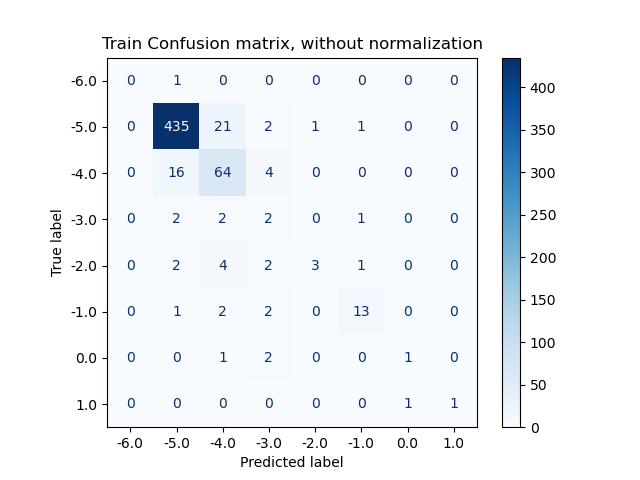

<IPython.core.display.Javascript object>


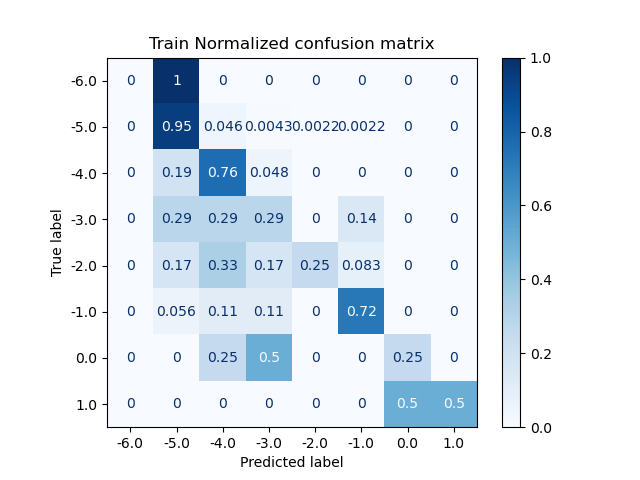

<IPython.core.display.Javascript object>


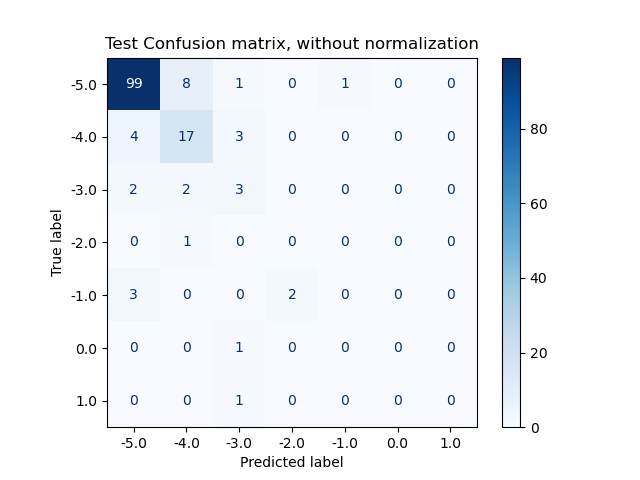

<IPython.core.display.Javascript object>


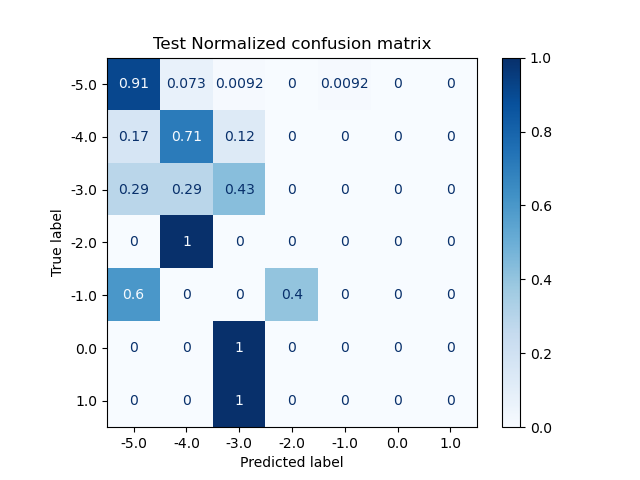

In [293]:
for key, res in {'Train': train_res, 'Test': test_res}.items():
    titles_options = [
        (key+ " Confusion matrix, without normalization", None),
        (key+" Normalized confusion matrix", "true"),
    ]
    for title, normalize in titles_options:
        disp = ConfusionMatrixDisplay.from_predictions(
            np.round(res['y_true']),
            res['y_pred'],
            labels=np.sort(list(set(list(np.round(res['y_true']).unique())).union(set(list(np.round(res['y_pred']).unique()))))),
    #         display_labels=np.sort(list(train_res['y_true'].unique())),
            cmap=plt.cm.Blues,
            normalize=normalize,
        )
        disp.ax_.set_title(title)
        cm = pd.DataFrame(disp.confusion_matrix, index=disp.display_labels, columns=disp.display_labels)
        cm.columns.name='predicted_labels'
        cm.index.name='true_labels'
        cm.to_csv('../notebooks/{}/{}_df_confusion_matrix_{}.csv'.format(exp_name, key, normalize))
        plt.savefig('../notebooks/{}/{}_confusion_matrix_{}.png'.format(exp_name, key, normalize), format='png')
plt.show()

### range result

In [294]:
equal_meaning = True

In [295]:
range_res = pd.read_csv('../notebooks/{}/range_preds.csv'.format(exp_name)).set_index('unique_id').merge(y_range, left_index=True, right_index=True, how='inner')
range_res.columns=['y_pred'] + list(range_res.columns.values)[1:]
range_res['values'] = np.round(range_res['values'])
range_res['updated_values'] = np.nan
range_res['updated_direction'] = np.nan
if equal_meaning:
        range_res.loc[range_res['direction'] == '>=','updated_values'] = range_res['values'] - 1
        range_res.loc[range_res['direction'] == '<=','updated_values'] = range_res['values'] + 1
range_res.loc[range_res['direction'] == '>=','updated_direction'] = '>'
range_res.loc[range_res['direction'] == '<=','updated_direction'] = '<'

range_res.loc[:,'updated_values'].fillna(range_res['values'], inplace=True)
range_res.loc[:,'updated_direction'].fillna(range_res['direction'], inplace=True)

range_res.loc[range_res['updated_direction'] == '>','answer'] = (range_res['y_pred'] > range_res['updated_values'])
range_res.loc[range_res['updated_direction'] == '<','answer'] = (range_res['y_pred'] < range_res['updated_values'])
train_range_res = range_res.loc[set(range_res.index).intersection(set(train.index))]
test_range_res = range_res.loc[set(range_res.index) - set(train.index)]
for key, res in {'train': train_range_res, 'test': test_range_res}.items():
    range_confusion = res.groupby(by=['direction', 'values'])['answer'].agg(['count', 'sum']).replace(True, 1)
    range_confusion['perc'] = range_confusion['sum'] / range_confusion['count']
    range_confusion.columns = ['total', 'in range', 'accuracy']
    range_confusion = pd.DataFrame(range_confusion.stack()).T.swaplevel(i=2, j=0, axis=1)
    range_confusion.index=[key]
    regression_res = pd.concat([regression_res, range_confusion], axis=1)
regression_res_cleaned = pd.DataFrame({})
for col in regression_res.columns:
    if len(regression_res[[col]].columns) > 1:
        regression_res_cleaned[col] = regression_res[[col]].iloc[:,0].fillna(regression_res[[col]].iloc[:,1])
    else:
        regression_res_cleaned[col] = regression_res[[col]]
regression_res = regression_res_cleaned

In [298]:
regression_res

,exact RMSE,exact_rounded RMSE,"(total, -6.0, <)","(in range, -6.0, <)","(accuracy, -6.0, <)","(total, 2.0, >)","(in range, 2.0, >)","(accuracy, 2.0, >)"
train,0.593355,0.586765,NaN,NaN,NaN,NaN,NaN,NaN
test,0.864756,0.912015,2266,0,0.0,3,0,0.0


In [299]:
regression_res.to_csv('../notebooks/{}/df_regression_results.csv'.format(exp_name))

In [250]:
label

'ciprofloxacin'

## Playing with h2o

In [42]:
def run_h2o(model_param, exp_name):
    print(exp_name)
    # Import a sample binary outcome train/test set into H2O
    trainH2o = h2o.import_file('../experiments/{}/train.csv'.format(exp_name))
    print(trainH2o.as_data_frame().columns[-1])
    testH2o = h2o.import_file('../experiments/{}/test.csv'.format(exp_name))
    rangeH2o = h2o.import_file('../experiments/{}/X_range.csv'.format(exp_name))
    model_name = '_'.join(['_'.join([k,str(v)]) for k,v in model_param.items()])

    # Identify predictors and response
    x = list(pd.read_csv('../experiments/{}/features.csv'.format(exp_name))['features'].values)
    y = pd.read_csv('../experiments/{}/label.csv'.format(exp_name)).loc[0, 'label']
    
    # Run AutoML for 20 base models
    aml = H2OAutoML(max_models=model_param['max_models'], seed=42, max_runtime_secs=model_param['train_time'])
    aml.train(x=x, y=y, training_frame=trainH2o)

    # View the AutoML Leaderboard
    lb = h2o.automl.get_leaderboard(aml, extra_columns = "ALL")
    lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

    model = aml.leader
    model_path = h2o.save_model(model=model, path='../experiments/{}/{}/model'.format(exp_name, model_name), force=True)
    lb.as_data_frame().to_csv('../experiments/{}/{}/leader_board.csv'.format(exp_name, model_name))
    test_preds = model.predict(testH2o).as_data_frame()
    range_preds = model.predict(rangeH2o).as_data_frame()
    test_preds.to_csv('../experiments/{}/{}/test_preds.csv'.format(exp_name, model_name))
    range_preds.to_csv('../experiments/{}/{}/range_preds.csv'.format(exp_name, model_name))
    return aml

In [51]:
species_filter_index_list = [0,1]
antibiotic_index_list = np.arange(20)

data_param = {
    'naive': False,
    'strip_range_train': False,
    'distance_range_train': True,
    'range_moved': 10,
    'reg_stratified': True,
    'species_sep': True,
    'antibiotic_sep': True,
    'exp_describtion': 'distanced_range10_strat',
}

In [52]:
model_param= {
    'model': 'h2o',
    'train_time': 3600,
    'max_models': 100,
}

In [64]:
exp_names = []
for species_filter_index in tqdm(species_filter_index_list):
    for antibiotic_index in tqdm(antibiotic_index_list):
        train, test, X_range, y_range, features, label, species, cv = get_filtered_data(
            data = 'tot_filtered_data.csv', 
            features = 'final_features',
            ASR_data = 'filtered_ASR_data.csv', 
            species_filter_index=species_filter_index, 
            antibiotic_index=antibiotic_index,
            species_sep = data_param['species_sep'], 
            antibiotic_sep = data_param['antibiotic_sep'], 
            naive = data_param['naive'], 
            strip_range_train = data_param['strip_range_train'], 
            reg_stratified = data_param['reg_stratified'],
            distance_range_train = data_param['distance_range_train'],
            range_moved = data_param['range_moved'],
            task='regression',
        )
        data_param['species'] = species
        if data_param['antibiotic_sep']:
            data_param['antibiotic'] = label
        exp_name = '{}_{}_{}'.format(species, label, data_param['exp_describtion'])
        exp_names.append(exp_name)
        os.makedirs('../experiments/{}'.format(exp_name), exist_ok=True)
        train.to_csv('../experiments/{}/train.csv'.format(exp_name))
        test.to_csv('../experiments/{}/test.csv'.format(exp_name))
        pd.DataFrame({'cv': cv}).to_csv('../experiments/{}/cv.csv'.format(exp_name))
        X_range.to_csv('../experiments/{}/X_range.csv'.format(exp_name))
        y_range.to_csv('../experiments/{}/y_range.csv'.format(exp_name))
        pd.DataFrame({'features': features}).to_csv('../experiments/{}/features.csv'.format(exp_name))
        pd.DataFrame({'label': [label]}).to_csv('../experiments/{}/label.csv'.format(exp_name))
        pd.DataFrame(data_param, index=[0]).to_csv('../experiments/{}/data_param.csv'.format(exp_name))

  0%|          | 0/20 [00:00<?, ?it/s]/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:17: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:17: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.


     biosample_id  tet(A)->seq_id  PER-1->seq_cov  ADC-58->seq_id  \
0    SAMN04901685            0.00             0.0             0.0   
1    SAMN04901671            0.00             0.0             0.0   
2    SAMN04555293            0.00             0.0             0.0   
3    SAMN04555226            0.00             0.0             0.0   
4    SAMN04446556          100.00             0.0             0.0   
..            ...             ...             ...             ...   
505  SAMN04901674            0.00             0.0             0.0   
506  SAMN04447714           99.44             0.0             0.0   
507  SAMN04445873           99.44             0.0             0.0   
508  SAMN04901681            0.00             0.0             0.0   
509  SAMN04450974           99.44             0.0             0.0   

     ADC-30->seq_id  OXA-69->seq_cov  ADC-30->seq_cov  ADC-79->seq_cov  \
0             99.91              0.0            100.0             0.00   
1            100.00    


  5%|▌         | 1/20 [00:00<00:16,  1.12it/s]/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:17: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:17: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.

 10%|█         | 2/20 [00:01<00:14,  1.20it/s]

     biosample_id  tet(A)->seq_id  ADC-58->seq_id  ADC-30->seq_id  \
0    SAMN04555480            0.00           99.22             0.0   
1    SAMN04550082            0.00            0.00             0.0   
2    SAMN04549829          100.00            0.00             0.0   
3    SAMN04555507            0.00            0.00             0.0   
4    SAMN04515808            0.00            0.00             0.0   
..            ...             ...             ...             ...   
508  SAMN04555493           99.44            0.00             0.0   
509  SAMN04555215           99.44            0.00             0.0   
510  SAMN04546729           99.44            0.00             0.0   
511  SAMN04014929            0.00            0.00             0.0   
512  SAMN04555223           99.44            0.00             0.0   

     OXA-69->seq_cov  ADC-30->seq_cov  ADC-79->seq_cov  OXA-430->seq_id  \
0                0.0              0.0              0.0              0.0   
1                0.0 

/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:17: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:17: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.

 15%|█▌        | 3/20 [00:02<00:13,  1.23it/s]

     biosample_id  tet(A)->seq_id  ADC-58->seq_id  ADC-30->seq_id  \
0    SAMN04491450             0.0             0.0             0.0   
1    SAMN04547091             0.0             0.0             0.0   
2    SAMN04550076             0.0             0.0             0.0   
3    SAMN04555214             0.0             0.0             0.0   
4    SAMN04446446             0.0             0.0             0.0   
..            ...             ...             ...             ...   
507  SAMN04457329             0.0             0.0             0.0   
508  SAMN04901688             0.0             0.0           100.0   
509  SAMN04485909             0.0             0.0           100.0   
510  SAMN04014929             0.0             0.0             0.0   
511  SAMN04480080           100.0             0.0             0.0   

     OXA-69->seq_cov  ADC-30->seq_cov  ADC-79->seq_cov  acrD->seq_id  \
0                0.0              0.0            100.0          0.00   
1              100.0       

/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:17: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:17: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.

 20%|██        | 4/20 [00:03<00:12,  1.24it/s]

     biosample_id  aadA11->seq_id  tet(A)->seq_id  PER-1->seq_cov  \
0    SAMN04546726             0.0           99.44             0.0   
1    SAMN04515809             0.0            0.00           100.0   
2    SAMN04549512             0.0           99.44             0.0   
3    SAMN04549316             0.0           99.44             0.0   
4    SAMN04547104             0.0            0.00           100.0   
..            ...             ...             ...             ...   
506  SAMN04487142             0.0            0.00             0.0   
507  SAMN04450961             0.0            0.00             0.0   
508  SAMN04485914             0.0            0.00             0.0   
509  SAMN04487135             0.0            0.00             0.0   
510  SAMN04485902             0.0            0.00             0.0   

     ADC-30->seq_id  OXA-69->seq_cov  ADC-30->seq_cov  ADC-79->seq_cov  \
0               0.0              0.0              0.0            100.0   
1               0.0    

/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:17: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:17: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.

 25%|██▌       | 5/20 [00:04<00:12,  1.22it/s]

     biosample_id  tet(A)->seq_id  OXA-69->seq_cov  ADC-79->seq_cov  \
0    SAMN04550076             0.0              0.0              0.0   
1    SAMN04555197             0.0              0.0            100.0   
2    SAMN04549824             0.0              0.0            100.0   
3    SAMN04555479             0.0              0.0            100.0   
4    SAMN04229825           100.0              0.0              0.0   
..            ...             ...              ...              ...   
507  SAMN04229826           100.0              0.0              0.0   
508  SAMN04487135             0.0              0.0              0.0   
509  SAMN04480653             0.0              0.0              0.0   
510  SAMN04485902             0.0              0.0              0.0   
511  SAMN04450960             0.0              0.0              0.0   

     acrD->seq_id  OXA-98->seq_cov  adeH->seq_id  adeK->seq_cov  \
0            0.00            100.0         98.48          100.0   
1            

/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:17: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:17: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.

 30%|███       | 6/20 [00:04<00:11,  1.22it/s]

     biosample_id  tet(A)->seq_id  PER-1->seq_cov  \
0    SAMN04488286             0.0           100.0   
1    SAMN04549501             0.0           100.0   
2    SAMN04547099             0.0           100.0   
3    SAMN04549832           100.0             0.0   
4    SAMN04568514             0.0             0.0   
..            ...             ...             ...   
505  SAMN04485902             0.0             0.0   
506  SAMN04450961             0.0             0.0   
507  SAMN04446470             0.0             0.0   
508  SAMN04487142             0.0             0.0   
509  SAMN04485910             0.0             0.0   

     Staphylococcys_aureus_LmrS->seq_id  cmlA5->seq_id  ADC-30->seq_id  \
0                                  0.00            0.0             0.0   
1                                  0.00            0.0             0.0   
2                                 99.81            0.0             0.0   
3                                  0.00            0.0             

/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:17: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:17: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.

 35%|███▌      | 7/20 [00:05<00:10,  1.25it/s]

     biosample_id  tet(A)->seq_id  ADC-58->seq_id  OXA-237->seq_cov  \
0    SAMN04546718             0.0             0.0               0.0   
1    SAMN04549556             0.0             0.0               0.0   
2    SAMN04550082             0.0             0.0               0.0   
3    SAMN04549559             0.0             0.0               0.0   
4    SAMN04549871             0.0             0.0               0.0   
..            ...             ...             ...               ...   
504  SAMN04555305             0.0             0.0               0.0   
505  SAMN04549553             0.0             0.0               0.0   
506  SAMN04550080             0.0             0.0               0.0   
507  SAMN04515792             0.0             0.0               0.0   
508  SAMN04456589             0.0             0.0               0.0   

     ADC-30->seq_id  OXA-69->seq_cov  ADC-30->seq_cov  ADC-79->seq_cov  \
0               0.0              0.0              0.0              0.0   

/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:17: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:17: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.

 40%|████      | 8/20 [00:06<00:09,  1.26it/s]

     biosample_id  aadA11->seq_id  tet(A)->seq_id  PER-1->seq_cov  \
0    SAMN04447713             0.0             0.0             0.0   
1    SAMN04549824             0.0             0.0             0.0   
2    SAMN04447710             0.0             0.0             0.0   
3    SAMN04446476             0.0             0.0             0.0   
4    SAMN04491038             0.0             0.0             0.0   
..            ...             ...             ...             ...   
503  SAMN04482435             0.0             0.0             0.0   
504  SAMN04450961             0.0             0.0             0.0   
505  SAMN04447701             0.0             0.0             0.0   
506  SAMN04485902             0.0             0.0             0.0   
507  SAMN04457322             0.0             0.0             0.0   

     Staphylococcys_aureus_LmrS->seq_id  OXA-69->seq_cov  ADC-79->seq_cov  \
0                                   0.0              0.0            100.0   
1                

/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:17: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:17: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.

 45%|████▌     | 9/20 [00:07<00:08,  1.29it/s]

     biosample_id  aadA11->seq_id  tet(A)->seq_id  PER-1->seq_cov  \
0    SAMN04487141             0.0            0.00             0.0   
1    SAMN04487133             0.0           99.44             0.0   
2    SAMN04485917             0.0           99.44             0.0   
3    SAMN04555182             0.0            0.00             0.0   
4    SAMN04515397             0.0           99.44             0.0   
..            ...             ...             ...             ...   
497  SAMN04491038             0.0            0.00             0.0   
498  SAMN04446535             0.0            0.00             0.0   
499  SAMN04446460             0.0            0.00             0.0   
500  SAMN04491438             0.0          100.00             0.0   
501  SAMN04447707             0.0            0.00             0.0   

     OXA-203->seq_cov  cmlA5->seq_id  OXA-237->seq_cov  ADC-30->seq_id  \
0                 0.0            0.0               0.0           100.0   
1                 0.0  

/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:17: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:17: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.

 50%|█████     | 10/20 [00:08<00:07,  1.28it/s]

     biosample_id  aadA11->seq_id  tet(A)->seq_id  PER-1->seq_cov  \
0    SAMN04549514             0.0            0.00             0.0   
1    SAMN04549304             0.0            0.00             0.0   
2    SAMN04550124             0.0            0.00             0.0   
3    SAMN04568523             0.0            0.00             0.0   
4    SAMN04555513             0.0           99.44             0.0   
..            ...             ...             ...             ...   
498  SAMN04549510             0.0            0.00             0.0   
499  SAMN04901672             0.0            0.00             0.0   
500  SAMN04549834             0.0            0.00             0.0   
501  SAMN04491434             0.0          100.00             0.0   
502  SAMN04549555             0.0          100.00             0.0   

     Staphylococcys_aureus_LmrS->seq_id  ADC-30->seq_id  OXA-69->seq_cov  \
0                                   0.0          100.00              0.0   
1                  

/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:17: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:17: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.

 55%|█████▌    | 11/20 [00:08<00:07,  1.28it/s]

     biosample_id  aadA11->seq_id  tet(A)->seq_id  PER-1->seq_cov  \
0    SAMN04901702             0.0             0.0             0.0   
1    SAMN04014874             0.0             0.0             0.0   
2    SAMN04901671             0.0             0.0             0.0   
3    SAMN04014876             0.0             0.0             0.0   
4    SAMN04450969             0.0             0.0             0.0   
..            ...             ...             ...             ...   
497  SAMN04488268             0.0             0.0             0.0   
498  SAMN04446441             0.0             0.0             0.0   
499  SAMN04485914             0.0             0.0             0.0   
500  SAMN04457322             0.0             0.0             0.0   
501  SAMN04447699             0.0             0.0             0.0   

     ADC-30->seq_id  OXA-69->seq_cov  ADC-30->seq_cov  ADC-79->seq_cov  \
0               0.0            100.0              0.0           100.00   
1               0.0    

/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:17: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:17: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.

 60%|██████    | 12/20 [00:09<00:06,  1.31it/s]

     biosample_id  ADC-58->seq_id  ADC-30->seq_id  ADC-30->seq_cov  \
0    SAMN04555216            0.00             0.0              0.0   
1    SAMN04516582            0.00             0.0              0.0   
2    SAMN04550078            0.00             0.0              0.0   
3    SAMN04549515           99.22             0.0              0.0   
4    SAMN04550111            0.00             0.0              0.0   
..            ...             ...             ...              ...   
474  SAMN04555220            0.00             0.0              0.0   
475  SAMN04555174            0.00           100.0            100.0   
476  SAMN04545396            0.00           100.0            100.0   
477  SAMN04450975            0.00             0.0              0.0   
478  SAMN04555179            0.00             0.0              0.0   

     ADC-79->seq_cov  OXA-430->seq_id  acrD->seq_id  OXA-98->seq_cov  \
0              100.0              0.0          0.00              0.0   
1              

/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:17: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:17: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.

 65%|██████▌   | 13/20 [00:10<00:05,  1.37it/s]

     biosample_id  cefazolin
0    SAMN04550106       16.0
1    SAMN04549881       16.0
2    SAMN04555220       16.0
3    SAMN04482444       16.0
4    SAMN04547102       16.0
..            ...        ...
475  SAMN04014929       13.0
476  SAMN04014874       13.0
477  SAMN04014919       13.0
478  SAMN04014924       13.0
479  SAMN04014893       13.0

[480 rows x 2 columns]


/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:17: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:17: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.

 70%|███████   | 14/20 [00:10<00:04,  1.36it/s]

     biosample_id  tet(A)->seq_id  ADC-58->seq_id  ADC-30->seq_id  \
0    SAMN04480655            0.00             0.0             0.0   
1    SAMN04446456            0.00             0.0             0.0   
2    SAMN04550077            0.00             0.0             0.0   
3    SAMN04014877            0.00             0.0             0.0   
4    SAMN04547092            0.00             0.0             0.0   
..            ...             ...             ...             ...   
471  SAMN04545406            0.00             0.0           100.0   
472  SAMN04491039            0.00             0.0           100.0   
473  SAMN04447703            0.00             0.0             0.0   
474  SAMN04555181           99.44             0.0             0.0   
475  SAMN04491448            0.00             0.0             0.0   

     OXA-69->seq_cov  ADC-30->seq_cov  ADC-79->seq_cov  ADC-25->seq_cov  \
0                0.0              0.0              0.0              0.0   
1              100.0 

/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:17: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:17: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.

 75%|███████▌  | 15/20 [00:11<00:03,  1.35it/s]

     biosample_id  tet(A)->seq_id  PER-1->seq_cov  OXA-69->seq_cov  \
0    SAMN04487145           99.44             0.0              0.0   
1    SAMN04555217           99.44             0.0              0.0   
2    SAMN04446520          100.00             0.0            100.0   
3    SAMN04555195           99.44             0.0              0.0   
4    SAMN02437332            0.00             0.0            100.0   
..            ...             ...             ...              ...   
467  SAMN04555230            0.00             0.0              0.0   
468  SAMN04555183            0.00             0.0              0.0   
469  SAMN04546725           99.44             0.0              0.0   
470  SAMN04482442            0.00             0.0              0.0   
471  SAMN04555189            0.00             0.0              0.0   

     ADC-79->seq_cov  adeH->seq_id  dfrA1->seq_cov  aadA17->seq_id  \
0             100.00         99.17             0.0             0.0   
1             100.0

/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:17: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:17: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.

 80%|████████  | 16/20 [00:12<00:02,  1.34it/s]

     biosample_id  tet(A)->seq_id  ADC-58->seq_id  ADC-30->seq_id  \
0    SAMN04555495            0.00             0.0             0.0   
1    SAMN04549269            0.00             0.0           100.0   
2    SAMN04485914            0.00             0.0             0.0   
3    SAMN04487143            0.00             0.0             0.0   
4    SAMN04549556            0.00             0.0             0.0   
..            ...             ...             ...             ...   
461  SAMN04550114            0.00             0.0           100.0   
462  SAMN04525200            0.00             0.0           100.0   
463  SAMN04487145           99.44             0.0             0.0   
464  SAMN04446557            0.00             0.0             0.0   
465  SAMN04550119            0.00             0.0           100.0   

     OXA-69->seq_cov  ADC-30->seq_cov  ADC-79->seq_cov  OXA-430->seq_id  \
0                0.0              0.0              0.0              0.0   
1                0.0 

/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:17: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:17: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.

 85%|████████▌ | 17/20 [00:13<00:02,  1.38it/s]

     biosample_id  cefoxitin
0    SAMN04555520       16.0
1    SAMN04555220       16.0
2    SAMN04549838       16.0
3    SAMN04544430       16.0
4    SAMN04555499       16.0
..            ...        ...
343  SAMN04014929       14.0
344  SAMN04014874       14.0
345  SAMN04014919       14.0
346  SAMN04014924       14.0
347  SAMN04014893       14.0

[348 rows x 2 columns]


/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:17: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:17: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.

 90%|█████████ | 18/20 [00:13<00:01,  1.35it/s]

     biosample_id  tet(A)->seq_id  ADC-30->seq_id  OXA-69->seq_cov  \
0    SAMN04555217           99.44             0.0              0.0   
1    SAMN04545391            0.00             0.0              0.0   
2    SAMN04555291            0.00             0.0              0.0   
3    SAMN04487132           99.44             0.0              0.0   
4    SAMN04555501            0.00           100.0              0.0   
..            ...             ...             ...              ...   
251  SAMN04555234           99.44             0.0              0.0   
252  SAMN04446540            0.00             0.0            100.0   
253  SAMN04487149           99.44             0.0              0.0   
254  SAMN04450972           99.44             0.0              0.0   
255  SAMN04446461            0.00             0.0            100.0   

     ADC-30->seq_cov  ADC-79->seq_cov  ADC-25->seq_cov  acrD->seq_id  \
0                0.0            100.0              0.0          0.00   
1              

/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:17: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:17: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.

 95%|█████████▌| 19/20 [00:14<00:00,  1.39it/s]

     biosample_id  aadA11->seq_id  aadA2->seq_cov  tet(A)->seq_id  \
0    SAMN04901672             0.0             0.0             0.0   
1    SAMN02437332             0.0             0.0             0.0   
2    SAMN04901675             0.0             0.0             0.0   
3    SAMN04252827             0.0             0.0             0.0   
4    SAMN04901679             0.0             0.0             0.0   
..            ...             ...             ...             ...   
164  SAMN04555193             0.0             0.0             0.0   
165  SAMN04446441             0.0             0.0             0.0   
166  SAMN04549317             0.0             0.0             0.0   
167  SAMN04487142             0.0             0.0             0.0   
168  SAMN04457322             0.0             0.0             0.0   

     PER-1->seq_cov  OXA-203->seq_cov  cmlA5->seq_id  ADC-30->seq_id  \
0               0.0               0.0            0.0           99.91   
1               0.0        

/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:17: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:17: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.

 50%|█████     | 1/2 [00:15<00:15, 15.22s/it]

     biosample_id  tet(A)->seq_id  PER-1->seq_cov  ADC-30->seq_id  \
0    SAMN04488273             0.0             0.0            0.00   
1    SAMN04515798             0.0             0.0            0.00   
2    SAMN04549844             0.0             0.0          100.00   
3    SAMN04555491             0.0             0.0          100.00   
4    SAMN04515401             0.0             0.0            0.00   
..            ...             ...             ...             ...   
121  SAMN04901678             0.0             0.0          100.00   
122  SAMN04901675             0.0             0.0            0.00   
123  SAMN04901695             0.0             0.0            0.00   
124  SAMN04901685             0.0             0.0           99.91   
125  SAMN04901665             0.0             0.0           99.91   

     OXA-69->seq_cov  ADC-30->seq_cov  ADC-79->seq_cov  ADC-25->seq_cov  \
0                0.0              0.0              0.0            100.0   
1                0.0 


  0%|          | 0/20 [00:00<?, ?it/s]/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:17: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:17: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.

  5%|▌         | 1/20 [00:00<00:14,  1.34it/s]

     biosample_id  QnrS1->seq_id  aadA2->seq_cov  tet(A)->seq_id  \
0    SAMN06546423          100.0             0.0             0.0   
1    SAMN06311516            0.0             0.0           100.0   
2    SAMN02356605          100.0             0.0             0.0   
3    SAMN06680409            0.0             0.0           100.0   
4    SAMN05510459          100.0             0.0             0.0   
..            ...            ...             ...             ...   
160  SAMN02356606            0.0             0.0             0.0   
161  SAMN04456590            0.0             0.0             0.0   
162  SAMN02356622            0.0             0.0             0.0   
163  SAMN04448243            0.0             0.0             0.0   
164  SAMN05170247            0.0           100.0             0.0   

     catII_from_Escherichia_coli_K-12->seq_cov  CTX-M-9->seq_id  \
0                                          0.0              0.0   
1                                          0.0   

/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:17: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:17: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.

 10%|█         | 2/20 [00:01<00:13,  1.34it/s]

     biosample_id  QnrS1->seq_id  aadA2->seq_cov  tet(A)->seq_id  \
0    SAMN05774081            0.0             0.0           100.0   
1    SAMN07291519            0.0             0.0             0.0   
2    SAMN06680398            0.0             0.0           100.0   
3    SAMN04448247            0.0             0.0             0.0   
4    SAMN06311516            0.0             0.0           100.0   
..            ...            ...             ...             ...   
158  SAMN05170144            0.0             0.0           100.0   
159  SAMN05170128            0.0           100.0             0.0   
160  SAMN05170110            0.0           100.0             0.0   
161  SAMN05170245            0.0            75.0             0.0   
162  SAMN05170194            0.0             0.0             0.0   

     catII_from_Escherichia_coli_K-12->seq_cov  CTX-M-9->seq_id  \
0                                          0.0              0.0   
1                                          0.0   

/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:17: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:17: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.

 15%|█▌        | 3/20 [00:02<00:12,  1.33it/s]

     biosample_id  QnrS1->seq_id  aadA2->seq_cov  tet(A)->seq_id  \
0    SAMN04014888            0.0            75.0             0.0   
1    SAMN04014986          100.0             0.0             0.0   
2    SAMN07291531            0.0           100.0             0.0   
3    SAMN04014970            0.0           100.0             0.0   
4    SAMN02141971            0.0             0.0             0.0   
..            ...            ...             ...             ...   
156  SAMN05170062            0.0             0.0             0.0   
157  SAMN05170128            0.0           100.0             0.0   
158  SAMN05170064          100.0             0.0             0.0   
159  SAMN05170109            0.0           100.0           100.0   
160  SAMN06680398            0.0             0.0           100.0   

     catII_from_Escherichia_coli_K-12->seq_cov  rosB->seq_id  \
0                                          0.0         69.69   
1                                          0.0         

/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:17: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:17: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.

 20%|██        | 4/20 [00:02<00:11,  1.38it/s]

     biosample_id  QnrS1->seq_id  tet(A)->seq_id  aadA5->seq_id  rosB->seq_id  \
0    SAMN06311516            0.0           100.0            0.0         69.69   
1    SAMN06546423          100.0             0.0          100.0         69.63   
2    SAMN04014958            0.0             0.0            0.0         69.75   
3    SAMN02141980          100.0             0.0            0.0         69.82   
4    SAMN02142000            0.0             0.0            0.0         69.69   
..            ...            ...             ...            ...           ...   
160  SAMN05170325            0.0             0.0            0.0         69.94   
161  SAMN05170211            0.0             0.0            0.0         68.65   
162  SAMN05170340            0.0             0.0            0.0         69.51   
163  SAMN05170194            0.0             0.0            0.0         68.84   
164  SAMN05170182            0.0             0.0            0.0         69.82   

     Klebsiella_pneumoniae_

/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:17: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:17: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.

 25%|██▌       | 5/20 [00:03<00:11,  1.36it/s]

     biosample_id  DHA-6->seq_cov  QnrS1->seq_id  aadA2->seq_cov  \
0    SAMN05170088           100.0            0.0             0.0   
1    SAMN02141980             0.0          100.0             0.0   
2    SAMN04014890             0.0            0.0           100.0   
3    SAMN04339714             0.0            0.0             0.0   
4    SAMN04014881             0.0            0.0             0.0   
..            ...             ...            ...             ...   
155  SAMN05774083             0.0            0.0             0.0   
156  SAMN06680409             0.0            0.0             0.0   
157  SAMN05806167             0.0          100.0             0.0   
158  SAMN06546423             0.0          100.0             0.0   
159  SAMN02356621             0.0            0.0             0.0   

     tet(A)->seq_id  rosB->seq_id  Klebsiella_pneumoniae_KpnH->seq_cov  \
0               0.0         69.69                                99.94   
1               0.0         69.82  

/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:17: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:17: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.

 30%|███       | 6/20 [00:04<00:10,  1.38it/s]

     biosample_id  DHA-6->seq_cov  QnrS1->seq_id  aadA2->seq_cov  \
0    SAMN04096276             0.0          100.0             0.0   
1    SAMN02141980             0.0          100.0             0.0   
2    SAMN05170343             0.0            0.0           100.0   
3    SAMN06680409             0.0            0.0             0.0   
4    SAMN04339714             0.0            0.0             0.0   
..            ...             ...            ...             ...   
153  SAMN04096279             0.0          100.0           100.0   
154  SAMN05806167             0.0          100.0             0.0   
155  SAMN04456590             0.0            0.0             0.0   
156  SAMN05170310             0.0          100.0             0.0   
157  SAMN05170170             0.0            0.0             0.0   

     tet(A)->seq_id  rosB->seq_id  Klebsiella_pneumoniae_KpnH->seq_cov  \
0             100.0         69.82                                99.94   
1               0.0         69.82  

/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:17: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:17: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.

 35%|███▌      | 7/20 [00:05<00:09,  1.36it/s]

     biosample_id  QnrS1->seq_id  aadA2->seq_cov  tet(A)->seq_id  \
0    SAMN04339714            0.0             0.0             0.0   
1    SAMN05806167          100.0             0.0             0.0   
2    SAMN06680398            0.0             0.0           100.0   
3    SAMN05510459          100.0             0.0             0.0   
4    SAMN05170124            0.0             0.0           100.0   
..            ...            ...             ...             ...   
154  SAMN04448243            0.0             0.0             0.0   
155  SAMN02141980          100.0             0.0             0.0   
156  SAMN05170340            0.0             0.0             0.0   
157  SAMN05170194            0.0             0.0             0.0   
158  SAMN05170182            0.0             0.0             0.0   

     aadA5->seq_id  rosB->seq_id  Klebsiella_pneumoniae_KpnH->seq_cov  \
0              0.0         68.65                               100.00   
1              0.0         69.63     

/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:17: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:17: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.

 40%|████      | 8/20 [00:05<00:08,  1.37it/s]

     biosample_id  QnrS1->seq_id  aadA2->seq_cov  tet(A)->seq_id  \
0    SAMN07291547            0.0             0.0             0.0   
1    SAMN02142041            0.0           100.0             0.0   
2    SAMN04014948            0.0             0.0             0.0   
3    SAMN07265011            0.0             0.0           100.0   
4    SAMN04014986          100.0             0.0             0.0   
..            ...            ...             ...             ...   
152  SAMN05170057            0.0             0.0             0.0   
153  SAMN05170108            0.0           100.0             0.0   
154  SAMN05170313            0.0             0.0             0.0   
155  SAMN05170064          100.0             0.0             0.0   
156  SAMN05774083            0.0             0.0           100.0   

     catII_from_Escherichia_coli_K-12->seq_cov  rosB->seq_id  \
0                                          0.0         69.69   
1                                          0.0         

/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:17: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:17: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.

 45%|████▌     | 9/20 [00:06<00:08,  1.34it/s]

     biosample_id  QnrS1->seq_id  aadA2->seq_cov  tet(A)->seq_id  \
0    SAMN05170170            0.0             0.0           100.0   
1    SAMN05774081            0.0             0.0           100.0   
2    SAMN04096276          100.0             0.0           100.0   
3    SAMN05170304            0.0             0.0             0.0   
4    SAMN05170186            0.0             0.0           100.0   
..            ...            ...             ...             ...   
151  SAMN06680408            0.0            75.0             0.0   
152  SAMN06546423          100.0             0.0             0.0   
153  SAMN06680409            0.0             0.0           100.0   
154  SAMN06680398            0.0             0.0           100.0   
155  SAMN02142019            0.0           100.0             0.0   

     catII_from_Escherichia_coli_K-12->seq_cov  CTX-M-9->seq_id  \
0                                          0.0              0.0   
1                                          0.0   

/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:17: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:17: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.

 50%|█████     | 10/20 [00:07<00:07,  1.32it/s]

     biosample_id  DHA-6->seq_cov  QnrS1->seq_id  aadA2->seq_cov  \
0    SAMN05806167             0.0          100.0             0.0   
1    SAMN06680409             0.0            0.0             0.0   
2    SAMN06546423             0.0          100.0             0.0   
3    SAMN06754739             0.0            0.0           100.0   
4    SAMN06754741             0.0            0.0             0.0   
..            ...             ...            ...             ...   
151  SAMN05170109             0.0            0.0           100.0   
152  SAMN04456590             0.0            0.0             0.0   
153  SAMN05510459             0.0          100.0             0.0   
154  SAMN05170211             0.0            0.0             0.0   
155  SAMN05170064             0.0          100.0             0.0   

     tet(A)->seq_id  aadA5->seq_id  rosB->seq_id  \
0               0.0            0.0         69.63   
1             100.0            0.0         69.69   
2               0.0        

/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:17: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:17: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.

 55%|█████▌    | 11/20 [00:08<00:06,  1.33it/s]

     biosample_id  QnrS1->seq_id  aadA2->seq_cov  tet(A)->seq_id  \
0    SAMN06754741            0.0             0.0           100.0   
1    SAMN04096279          100.0           100.0             0.0   
2    SAMN06311516            0.0             0.0           100.0   
3    SAMN05510459          100.0             0.0             0.0   
4    SAMN05774083            0.0             0.0           100.0   
..            ...            ...             ...             ...   
148  SAMN05170064          100.0             0.0             0.0   
149  SAMN05170247            0.0           100.0             0.0   
150  SAMN04456590            0.0             0.0             0.0   
151  SAMN05170194            0.0             0.0             0.0   
152  SAMN02141980          100.0             0.0             0.0   

     aadA5->seq_id  rosB->seq_id  Klebsiella_pneumoniae_KpnH->seq_cov  \
0              0.0         69.63                                99.94   
1              0.0         68.65     

/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:17: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:17: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.

 60%|██████    | 12/20 [00:08<00:05,  1.35it/s]

     biosample_id  tet(A)->seq_id  rosB->seq_id  \
0    SAMN05170325             0.0         69.94   
1    SAMN06680398           100.0         69.69   
2    SAMN04014954             0.0         69.69   
3    SAMN04014953             0.0         69.69   
4    SAMN04514120             0.0         69.69   
..            ...             ...           ...   
147  SAMN05170124           100.0         69.75   
148  SAMN06680399             0.0         69.69   
149  SAMN05170158             0.0         69.69   
150  SAMN02356602             0.0         69.69   
151  SAMN05170131             0.0         69.69   

     Klebsiella_pneumoniae_KpnH->seq_cov  dfrA14->seq_id  H-NS->seq_cov  \
0                                  99.94            0.00          97.83   
1                                  99.94           99.79          97.83   
2                                  99.94            0.00          97.83   
3                                  99.94            0.00          97.83   
4           

/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:17: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:17: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.

 65%|██████▌   | 13/20 [00:09<00:05,  1.33it/s]

     biosample_id  QnrS1->seq_id  aadA2->seq_cov  tet(A)->seq_id  \
0    SAMN06680398            0.0             0.0           100.0   
1    SAMN06680408            0.0            75.0             0.0   
2    SAMN05170182            0.0             0.0             0.0   
3    SAMN07291519            0.0             0.0             0.0   
4    SAMN05170118            0.0            75.0             0.0   
..            ...            ...             ...             ...   
143  SAMN06311516            0.0             0.0           100.0   
144  SAMN05510459          100.0             0.0             0.0   
145  SAMN05170064          100.0             0.0             0.0   
146  SAMN05170340            0.0             0.0             0.0   
147  SAMN05170211            0.0             0.0             0.0   

     rosB->seq_id  Klebsiella_pneumoniae_KpnH->seq_cov  dfrA14->seq_id  \
0           69.69                                99.94           99.79   
1           69.69                  

/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:17: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:17: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.

 70%|███████   | 14/20 [00:10<00:04,  1.32it/s]

     biosample_id  DHA-6->seq_cov  QnrS1->seq_id  aadA2->seq_cov  \
0    SAMN04448246             0.0            0.0             0.0   
1    SAMN04014888             0.0            0.0            75.0   
2    SAMN05170088           100.0            0.0             0.0   
3    SAMN04448235             0.0            0.0             0.0   
4    SAMN04448225             0.0            0.0             0.0   
..            ...             ...            ...             ...   
141  SAMN02142019             0.0            0.0           100.0   
142  SAMN02356624             0.0            0.0             0.0   
143  SAMN02356622             0.0            0.0             0.0   
144  SAMN02356623             0.0            0.0             0.0   
145  SAMN02356605             0.0          100.0             0.0   

     tet(A)->seq_id  catII_from_Escherichia_coli_K-12->seq_cov  \
0             100.0                                        0.0   
1               0.0                                

/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:17: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:17: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.

 75%|███████▌  | 15/20 [00:11<00:03,  1.31it/s]

     biosample_id  QnrS1->seq_id  aadA2->seq_cov  rosB->seq_id  \
0    SAMN02141980          100.0             0.0         69.82   
1    SAMN04448243            0.0             0.0         69.51   
2    SAMN02141994            0.0            75.0         69.69   
3    SAMN02356624            0.0             0.0         69.69   
4    SAMN02356602            0.0            75.0         69.69   
..            ...            ...             ...           ...   
141  SAMN04448225            0.0             0.0         69.69   
142  SAMN04014887            0.0             0.0         69.55   
143  SAMN05170247            0.0           100.0         69.69   
144  SAMN05170211            0.0             0.0         68.65   
145  SAMN02356622            0.0             0.0         69.88   

     Klebsiella_pneumoniae_KpnH->seq_cov  SHV-11->seq_cov  dfrA14->seq_id  \
0                                  99.94              0.0            0.00   
1                                  99.94            1

/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:17: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:17: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.

 80%|████████  | 16/20 [00:11<00:02,  1.36it/s]

     biosample_id  cefazolin
0    SAMN07291505       13.0
1    SAMN05170304       13.0
2    SAMN04448235       13.0
3    SAMN04448228       13.0
4    SAMN05170322       13.0
..            ...        ...
138  SAMN06680399       16.0
139  SAMN06546424       16.0
140  SAMN05170325      -10.0
141  SAMN02356622       -9.0
142  SAMN02356606       -9.0

[143 rows x 2 columns]


/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:17: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:17: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.

 85%|████████▌ | 17/20 [00:12<00:02,  1.38it/s]

     biosample_id  QnrS1->seq_id  aadA2->seq_cov  tet(A)->seq_id  \
0    SAMN04448243            0.0             0.0             0.0   
1    SAMN06680399            0.0           100.0             0.0   
2    SAMN06680398            0.0             0.0           100.0   
3    SAMN05774081            0.0             0.0           100.0   
4    SAMN06754741            0.0             0.0           100.0   
..            ...            ...             ...             ...   
137  SAMN05170170            0.0             0.0           100.0   
138  SAMN05170075            0.0           100.0             0.0   
139  SAMN05170329          100.0             0.0             0.0   
140  SAMN05170110            0.0           100.0             0.0   
141  SAMN05170088            0.0             0.0             0.0   

     rosB->seq_id  Klebsiella_pneumoniae_KpnH->seq_cov  SHV-11->seq_cov  \
0           69.51                                99.94            100.0   
1           69.69                

/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:17: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:17: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.

 90%|█████████ | 18/20 [00:13<00:01,  1.35it/s]

     biosample_id  DHA-6->seq_cov  QnrS1->seq_id  aadA2->seq_cov  \
0    SAMN04014966             0.0            0.0            75.0   
1    SAMN07291504             0.0            0.0            75.0   
2    SAMN07291519             0.0            0.0             0.0   
3    SAMN07291531             0.0            0.0           100.0   
4    SAMN04014953             0.0            0.0            75.0   
..            ...             ...            ...             ...   
135  SAMN05170182             0.0            0.0             0.0   
136  SAMN05170264             0.0            0.0           100.0   
137  SAMN05170218             0.0            0.0           100.0   
138  SAMN05170158             0.0            0.0           100.0   
139  SAMN05170101             0.0            0.0           100.0   

     catII_from_Escherichia_coli_K-12->seq_cov  aadA5->seq_id  rosB->seq_id  \
0                                          0.0            0.0         69.69   
1                        

/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:17: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:17: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.

 95%|█████████▌| 19/20 [00:14<00:00,  1.34it/s]

     biosample_id  QnrS1->seq_id  aadA2->seq_cov  tet(A)->seq_id  \
0    SAMN04014948            0.0             0.0             0.0   
1    SAMN02141971            0.0             0.0             0.0   
2    SAMN04014999            0.0             0.0             0.0   
3    SAMN02141991            0.0             0.0             0.0   
4    SAMN02141979            0.0             0.0             0.0   
..            ...            ...             ...             ...   
135  SAMN05170134            0.0             0.0             0.0   
136  SAMN05170242          100.0            75.0             0.0   
137  SAMN05170193            0.0           100.0             0.0   
138  SAMN05170101            0.0           100.0             0.0   
139  SAMN02356605          100.0             0.0             0.0   

     catII_from_Escherichia_coli_K-12->seq_cov  CTX-M-9->seq_id  rosB->seq_id  \
0                                        100.0              0.0         69.75   
1                    

/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:17: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:17: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.

100%|██████████| 2/2 [00:30<00:00, 15.04s/it]

     biosample_id  aadA2->seq_cov  tet(A)->seq_id  rosB->seq_id  \
0    SAMN05170158           100.0             0.0         69.69   
1    SAMN04014887             0.0           100.0         69.55   
2    SAMN05170344            75.0             0.0         69.69   
3    SAMN07291505           100.0             0.0         69.69   
4    SAMN05170266           100.0             0.0         69.69   
..            ...             ...             ...           ...   
136  SAMN02141989             0.0             0.0         69.69   
137  SAMN02142048           100.0             0.0         69.69   
138  SAMN04448243             0.0             0.0         69.51   
139  SAMN05170325             0.0             0.0         69.94   
140  SAMN05170211             0.0             0.0         68.65   

     Klebsiella_pneumoniae_KpnH->seq_cov  SHV-11->seq_cov  H-NS->seq_cov  \
0                                  99.94              0.0          97.83   
1                                  99.94   

In [ ]:
# Start the H2O cluster (locally)
h2o.init()
for exp_name in tqdm(exp_names):
    a = run_h2o(model_param, exp_name)

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,8 hours 21 mins
H2O_cluster_timezone:,Asia/Jerusalem
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.36.0.1
H2O_cluster_version_age:,2 months and 13 days
H2O_cluster_name:,H2O_from_python_amitdanw_auth_ad_bgu_ac_il_71hfe8
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,6.686 Gb
H2O_cluster_total_cores:,6
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


  0%|          | 0/40 [00:00<?, ?it/s]

abaumannii_tobramycin_distanced_range10_strat
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
tobramycin
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |
11:20:16.865: _train param, Dropping bad and constant columns: [abeM->seq_cov, adeJ->seq_cov, adeI->seq_cov]


11:20:17.869: _train param, Dropping bad and constant columns: [abeM->seq_cov, adeJ->seq_cov, adeI->seq_cov]

███
11:20:19.871: _train param, Dropping bad and constant columns: [abeM->seq_cov, adeJ->seq_cov, adeI->seq_cov]
11:20:22.874: _train param, Dropping unused columns: [abeM->seq_cov, adeJ->seq_cov, adeI->seq_cov]

█
11:20:23.875: _train param, Dropping bad and constant columns: [abeM->seq_cov, adeJ->seq_cov, adeI->seq_cov]
11:20:24.877: _train param, Dropping bad and constant columns: [abeM->seq_cov, adeJ->seq_cov, 

  2%|▎         | 1/40 [52:51<34:21:40, 3171.80s/it]

███████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
abaumannii_ceftriaxone_distanced_range10_strat
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
ceftriaxone
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |
12:13:08.618: _train param, Dropping bad and constant columns: [adeF->seq_cov, OXA-413->seq_cov, OXA-413->seq_id, abeM->seq_cov, adeJ->seq_cov]

█
12:13:10.620: _train param, Dropping bad and constant columns: [adeF->seq_cov, OXA-413->seq_cov, OXA-413->seq_id, abeM->seq_cov, adeJ->seq_cov]

███
12:13:12.621: _train param, Dropping bad and constant columns: [adeF->seq_cov, OXA-413->seq_cov, OXA-413->seq_id, abeM->seq_cov, adeJ->seq_cov]
12:13:17.623: _train param, Dropping unused c

In [141]:
preds = a.predict(testH2o)

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


## Playing with Amoxicillin - Clavulanic acid as regression

In [223]:
X = filtered_data[features]
y = filtered_data[best_label+'_filtered']

In [226]:
kf = KFold(n_splits=10, shuffle=True, random_state=rng)

In [228]:
tot_actuals = []
tot_predictions = []
tot_rounded_predictions = []
for train_index, test_index in kf.split(X):
    xgb_model = xgb.XGBRegressor(n_jobs=1, tree_method='gpu_hist', gpu_id=0).fit(X.iloc[train_index], y.iloc[train_index])
    predictions = xgb_model.predict(X[test_index])
    actuals = y[test_index]
    rounded_predictions = [min(final_dict.values(), key=lambda x:abs(x-pred)) for pred in predictions]
    print("rounded: ", rounded_predictions)
    print("actual: ", actuals.T[0])
    print(mean_squared_error(actuals, predictions))
    print(confusion_matrix([str(x) for x in actuals.T[0]], [str(x) for x in rounded_predictions]))
    tot_actuals += list(actuals.T[0])
    tot_rounded_predictions += rounded_predictions
    tot_predictions += list(predictions)

XGBoostError: [11:31:40] /home/conda/feedstock_root/build_artifacts/xgboost-split_1637426272325/work/src/gbm/../common/common.h:157: XGBoost version not compiled with GPU support.
Stack trace:
  [bt] (0) /home/amitdanw/.conda/envs/gps/lib/libxgboost.so(+0x1a393b) [0x7f992193f93b]
  [bt] (1) /home/amitdanw/.conda/envs/gps/lib/libxgboost.so(+0x1a39cc) [0x7f992193f9cc]
  [bt] (2) /home/amitdanw/.conda/envs/gps/lib/libxgboost.so(xgboost::gbm::GBTree::ConfigureUpdaters()+0xa5) [0x7f992193fa85]
  [bt] (3) /home/amitdanw/.conda/envs/gps/lib/libxgboost.so(xgboost::gbm::GBTree::Configure(std::vector<std::pair<std::__cxx11::basic_string<char, std::char_traits<char>, std::allocator<char> >, std::__cxx11::basic_string<char, std::char_traits<char>, std::allocator<char> > >, std::allocator<std::pair<std::__cxx11::basic_string<char, std::char_traits<char>, std::allocator<char> >, std::__cxx11::basic_string<char, std::char_traits<char>, std::allocator<char> > > > > const&)+0x309) [0x7f9921956039]
  [bt] (4) /home/amitdanw/.conda/envs/gps/lib/libxgboost.so(+0x1e67fd) [0x7f99219827fd]
  [bt] (5) /home/amitdanw/.conda/envs/gps/lib/libxgboost.so(+0x1d5787) [0x7f9921971787]
  [bt] (6) /home/amitdanw/.conda/envs/gps/lib/libxgboost.so(XGBoosterUpdateOneIter+0x4c) [0x7f9921855abc]
  [bt] (7) /home/amitdanw/.conda/envs/gps/lib/python3.10/lib-dynload/../../libffi.so.8(+0x6a4a) [0x7f999bbf1a4a]
  [bt] (8) /home/amitdanw/.conda/envs/gps/lib/python3.10/lib-dynload/../../libffi.so.8(+0x5fea) [0x7f999bbf0fea]



In [291]:
print(mean_squared_error(tot_actuals, tot_predictions))

0.7742366563759465


<IPython.core.display.Javascript object>


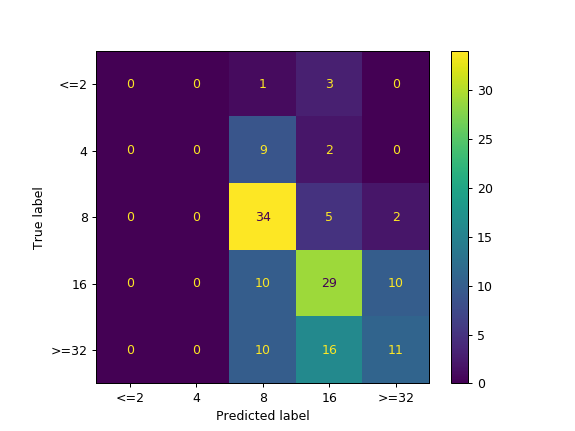

In [292]:
cm = confusion_matrix(
    [str(x) for x in tot_actuals], 
    [str(x) for x in tot_rounded_predictions], 
    labels=[str(x) for x in final_dict.values()],
)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=[str(x) for x in final_dict.keys()],
)
disp.plot() 

### run Parameter Opt

In [319]:
param_grid = {
    'max_depth':[3, 4, 6, 8, 10], 
    'n_estimators': [20, 50, 100, 200],
    'eta': uniform(loc=0, scale=1),
    'gamma': uniform(loc=0, scale=100),
    'min_child_weight': uniform(loc=0, scale=10),
    ''
}

In [320]:
xgb_model = xgb.XGBRegressor(n_jobs=1, tree_method='gpu_hist', gpu_id=0)

In [321]:
kf = KFold(n_splits=10, shuffle=True, random_state=rng)

In [322]:
clf = RandomizedSearchCV(xgb_model, param_distributions=param_grid, random_state=rng, cv = kf)

In [323]:
search = clf.fit(X, y)
search.best_params_
search.best_score_

[18:35:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

0.2719582886878314

[18:35:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

<IPython.core.display.Javascript object>


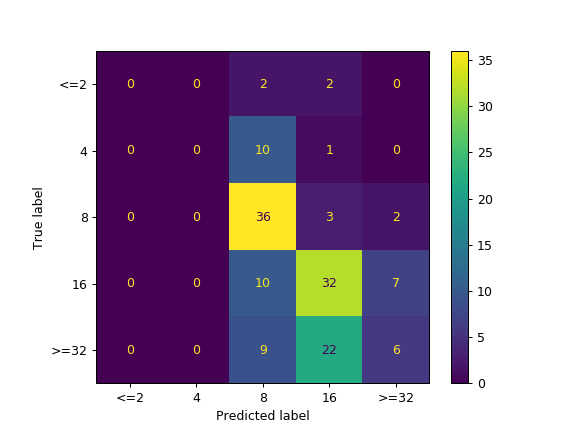

In [324]:
tot_actuals = []
tot_predictions = []
tot_rounded_predictions = []
for train_index, test_index in kf.split(X):
    xgb_model = xgb.XGBRegressor(n_jobs=1, **search.best_params_).fit(X[train_index], y[train_index])
    predictions = xgb_model.predict(X[test_index])
    actuals = y[test_index]
    rounded_predictions = [min(final_dict.values(), key=lambda x:abs(x-pred)) for pred in predictions]
    tot_actuals += list(actuals.T[0])
    tot_rounded_predictions += rounded_predictions
    tot_predictions += list(predictions)
    
print(mean_squared_error(tot_actuals, tot_predictions))
cm = confusion_matrix(
    [str(x) for x in tot_actuals], 
    [str(x) for x in tot_rounded_predictions], 
    labels=[str(x) for x in final_dict.values()],
)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=[str(x) for x in final_dict.keys()],
)
disp.plot() 

In [318]:
xgb_model

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=4, min_child_weight=1, missing=None, n_estimators=50,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)